# Data preprocessing

In [42]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt


In [43]:
df = pd.read_csv('C:\\Users\\praba\\Documents\\GitHub\\research-project-on-physics-informed-machine-learning-on-transcriptomics-data\\arabido_example_genes.csv')

In [44]:
# df = pd.read_csv('C:\\Users\\praba\\Documents\\GitHub\\research-project-on-physics-informed-machine-learning-on-transcriptomics-data\\some extra papers\\examples.csv',sep=';')

In [45]:
df

Unnamed: 0  Hpa-NO_1d  Hpa-NO_2d  Hpa-NO_4d
0  AT5G40100  -0.447960  -0.560155  -5.091964
1  AT1G06930   1.778359   0.000000   0.000000
2  AT1G04470   0.000000   1.175150   0.000000
3  AT5G66730   0.055375   0.098435  -0.101757
4  AT2G38471   0.505000   0.505000   0.505000
5  AT2G38472   0.900000   0.500000   0.000000
6  AT2G38473   0.700000   0.700000   0.700000
7  AT2G38474   0.000000   0.500000   0.000000
8  AT2G38470   0.906000   0.906000   0.906000

In [46]:
df.info()  # Check data types
df.describe()  # Statistical summary


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  9 non-null      object 
 1   Hpa-NO_1d   9 non-null      float64
 2   Hpa-NO_2d   9 non-null      float64
 3   Hpa-NO_4d   9 non-null      float64
dtypes: float64(3), object(1)
memory usage: 420.0+ bytes


Hpa-NO_1d  Hpa-NO_2d  Hpa-NO_4d
count   9.000000   9.000000   9.000000
mean    0.488530   0.424937  -0.342525
std     0.670280   0.517827   1.818255
min    -0.447960  -0.560155  -5.091964
25%     0.000000   0.098435   0.000000
50%     0.505000   0.500000   0.000000
75%     0.900000   0.700000   0.505000
max     1.778359   1.175150   0.906000

In [47]:
print(df.columns)

Index(['Unnamed: 0', 'Hpa-NO_1d', 'Hpa-NO_2d', 'Hpa-NO_4d'], dtype='object')


In [48]:
# print(df.columns.tolist())

# Neural ode +Inverse Pinn
# Combine t and y into a feature vector
inputs = torch.cat([torch.ones_like(y) * t, y], dim=1)

dy_dt = self.net(inputs)

return dy_dt

       # Combine t and y into a feature vector
        inputs = torch.cat([torch.ones_like(y) * t, y], dim=1)
        dy_dt = self.net(inputs)
        return dy_dt

In [67]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt

##############################################################################
# Data Setup (Row-wise: Each row is a gene; columns are Day1, Day2, Day4)
##############################################################################

# # Example dataset
# data = {
#     "Gene": ["AT5G40100", "AT1G06930", "AT1G04470", "AT5G66730"],
#     "Day1":  [-0.44796,    1.77836,     0.0,         0.05537],
#     "Day2":  [-0.56015,    0.0,         1.17515,     0.09843],
#     "Day4":  [-5.09196,    0.0,         0.0,        -0.10176],
# }
# df = pd.DataFrame(data)
# print("Original Data:")
# print(df)

# # Time points (in days)
time_points = np.array([1.0, 2.0, 4.0], dtype=np.float32)  # Day1, Day2, Day4

# # gene_data shape: (num_genes, num_time_points)
# gene_data = df[["Day1", "Day2", "Day4"]].values
gene_data = df[["Hpa-NO_1d", "Hpa-NO_2d", "Hpa-NO_4d"]].values


# gene_data = df[['Bc_0h_r1', 'Bc_0h_r2', 'Bc_0h_r3', 'Bc_16h_r1', 'Bc_16h_r2',
#        'Bc_16h_r3', 'Bc_23h_r1', 'Bc_23h_r2', 'Bc_23h_r3', 'Bc_40h_r1',
#        'Bc_40h_r2', 'Bc_40h_r3', 'Bc_47h_r1', 'Bc_47h_r2', 'Bc_47h_r3']].values



# Convert to PyTorch tensors
time_points_tensor = torch.tensor(time_points, dtype=torch.float32, requires_grad=True)
gene_data_tensor = torch.tensor(gene_data, dtype=torch.float32)

##############################################################################
# Neural ODE Model for Each Gene
##############################################################################

# class GeneSpecificODE(nn.Module):
#     """
#     A small neural network that models dY/dt for a single gene as a function of time.
#     """
#     def __init__(self):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Linear(1, 16),  # Input: time (scalar)
#             nn.Tanh(),
#             nn.Linear(16, 1)   # Output: derivative dY/dt
#         )

#     def forward(self, t, y):
#         # Here we use only time t as input (y can be concatenated if needed)
#         t_tensor = torch.ones_like(y) * t  # replicate t to match the shape of y
#         dy_dt = self.net(t_tensor)
#         return dy_dt

    
class GeneSpecificODE(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 16),  # Input: [t, y]
            nn.Tanh(),
            nn.Linear(16, 1)   # Output: dy/dt
        )

    def forward(self, t, y):
        # Ensure y has the correct shape for concatenation
        if y.dim() == 1:
            y = y.unsqueeze(1)
        # Combine t and y into a feature vector
        inputs = torch.cat([torch.ones_like(y) * t, y], dim=1)
        dy_dt = self.net(inputs)
        return dy_dt

# Create one ODE model per gene
num_genes = gene_data_tensor.shape[0]
ode_models = nn.ModuleList([GeneSpecificODE() for _ in range(num_genes)])

##############################################################################
# Inverse PINN Loss Function (Data loss + Physics loss)
##############################################################################

def inverse_pinn_loss(ode_models, time_points, gene_data, lambda_physics=0.1):
    total_data_loss = 0.0
    total_physics_loss = 0.0
    n_genes = gene_data.shape[0]

    for i in range(n_genes):
        y_observed = gene_data[i]   # shape: (num_time_points,)

        # Use the first time point as the initial condition
        y0 = y_observed[0].unsqueeze(0)  # shape: (1,)

        # Solve the ODE for gene i over the time points
        preds = odeint(ode_models[i], y0, time_points).squeeze()  # shape: (num_time_points,)

        # Data loss: Mean Squared Error between predictions and observed data
        data_loss = torch.mean((preds - y_observed)**2)

        # Physics loss: Ensure that the derivative from the prediction matches the network output
        dy_dt_pred = torch.autograd.grad(
            outputs=preds,
            inputs=time_points,
            grad_outputs=torch.ones_like(preds),
            create_graph=True,
            retain_graph=True
        )[0]

        # Evaluate the derivative using the ODE network for each time point
        dy_dt_ode = []
        for t_val, p_val in zip(time_points, preds):
            deriv = ode_models[i](t_val, p_val.unsqueeze(0))
            dy_dt_ode.append(deriv.squeeze())
        dy_dt_ode = torch.stack(dy_dt_ode)

        physics_loss = torch.mean((dy_dt_pred - dy_dt_ode)**2)

        total_data_loss += data_loss
        total_physics_loss += physics_loss

    avg_data_loss = total_data_loss / n_genes
    avg_physics_loss = total_physics_loss / n_genes
    total_loss = avg_data_loss + lambda_physics * avg_physics_loss
    return total_loss, avg_data_loss, avg_physics_loss

##############################################################################
# Training Loop
##############################################################################

optimizer = optim.Adam(ode_models.parameters(), lr=0.01)
epochs = 20

for epoch in range(epochs):
    optimizer.zero_grad()
    total_loss, data_loss, physics_loss = inverse_pinn_loss(ode_models, time_points_tensor, gene_data_tensor, lambda_physics=0.1)
    total_loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch:4d} | Total Loss: {total_loss.item():.4f} | Data Loss: {data_loss.item():.4f} | Physics Loss: {physics_loss.item():.4f}")




Epoch    0 | Total Loss: 2.4745 | Data Loss: 2.4265 | Physics Loss: 0.4797
Epoch   10 | Total Loss: 0.2629 | Data Loss: 0.2095 | Physics Loss: 0.5333


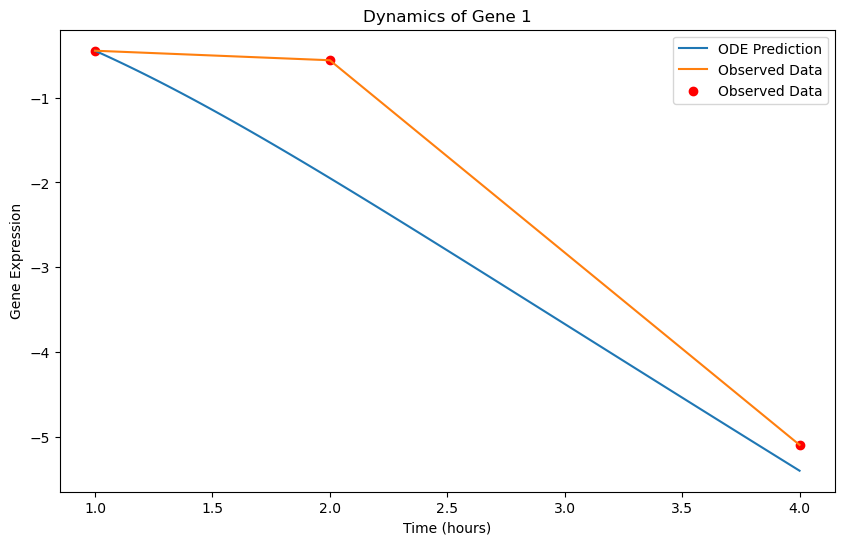

In [68]:
with torch.no_grad():
    gene_idx = 0
    y0 = gene_data_tensor[gene_idx, 0].unsqueeze(0)
    t_plot = torch.linspace(time_points[0], time_points[-1], 100)
    preds = odeint(ode_models[gene_idx], y0, t_plot).squeeze()

plt.figure(figsize=(10, 6))
plt.plot(t_plot.numpy(), preds.numpy(), label='ODE Prediction')
plt.plot(time_points, gene_data_tensor[gene_idx].numpy(), label='Observed Data')

plt.scatter(time_points, gene_data_tensor[gene_idx].numpy(), c='red', label='Observed Data')
plt.xlabel("Time (hours)")
plt.ylabel("Gene Expression")
plt.title(f"Dynamics of Gene {gene_idx+1}")
plt.legend()
plt.show()

In [69]:
##############################################################################
# Print Discovered ODEs and Parameters
##############################################################################

def print_ode_equations(ode_models):
    for i, model in enumerate(ode_models):
        # Extract weights and biases from the neural network layers
        layer1_weight = model.net[0].weight.data.numpy()
        layer1_bias = model.net[0].bias.data.numpy()
        layer2_weight = model.net[2].weight.data.numpy()
        layer2_bias = model.net[2].bias.data.numpy()
        
        # Format the equation
        equation = (
            f"Gene {i+1} ODE:\n"
            f"dy/dt = tanh("
            f"{layer1_weight[0,0]:.3f}·t + {layer1_weight[0,1]:.3f}·y + {layer1_bias[0]:.3f}"
            f") * {layer2_weight[0,0]:.3f} + ... + "
            f"tanh({layer1_weight[-1,0]:.3f}·t + {layer1_weight[-1,1]:.3f}·y + {layer1_bias[-1]:.3f})"
            f" * {layer2_weight[0,-1]:.3f} + {layer2_bias[0]:.3f}"
        )
        
        print("-" * 80)
        print(equation)
        print("First layer weights (16 neurons):")
        print(np.round(layer1_weight, 3))
        print("First layer biases:")
        print(np.round(layer1_bias, 3))
        print("Second layer weights:")
        print(np.round(layer2_weight, 3))
        print("Second layer bias:")
        print(np.round(layer2_bias, 3))

print_ode_equations(ode_models)

--------------------------------------------------------------------------------
Gene 1 ODE:
dy/dt = tanh(0.287·t + 0.451·y + -0.114) * -0.023 + ... + tanh(0.709·t + -0.450·y + 0.748) * -0.237 + 0.028
First layer weights (16 neurons):
[[ 0.287  0.451]
 [ 0.484 -0.069]
 [-0.002 -0.724]
 [-0.623 -0.514]
 [ 0.034 -0.49 ]
 [-0.233 -0.706]
 [-0.473 -0.182]
 [-0.019  0.569]
 [ 0.197 -0.623]
 [ 0.21  -0.454]
 [-0.391 -0.506]
 [-0.234  0.524]
 [-0.241  0.182]
 [-0.638  0.221]
 [ 0.106  0.342]
 [ 0.709 -0.45 ]]
First layer biases:
[-0.114  0.627  0.531 -0.682 -0.08   0.371 -0.604  0.35   0.358  0.103
 -0.054 -0.639  0.027  0.07   0.463  0.748]
Second layer weights:
[[-0.023 -0.137 -0.204  0.19  -0.119 -0.038  0.245  0.02   0.082 -0.378
   0.066  0.171 -0.096  0.348  0.063 -0.237]]
Second layer bias:
[0.028]
--------------------------------------------------------------------------------
Gene 2 ODE:
dy/dt = tanh(0.425·t + -0.689·y + -0.057) * 0.122 + ... + tanh(-0.343·t + 0.030·y + 0.572) * 0.04

In [ ]:
##############################################################################
# Plotting Predictions and Printing ODE Parameters
##############################################################################

with torch.no_grad():
    for i, gene_id in enumerate(df['Unnamed: 0']):
        # Use the initial condition from Day1 for each gene
        y0 = gene_data_tensor[i, 0].unsqueeze(0)  # shape: (1,)

        # Solve the ODE to get predictions over the time points
        preds = odeint(ode_models[i], y0, time_points_tensor).squeeze().numpy()

        # Plot observed data vs. Neural ODE predictions
        plt.figure()
        plt.scatter(time_points, gene_data[i], c='b', label="Observed Data")
        plt.plot(time_points, gene_data[i], 'b-', label="Observed Curve")
        plt.plot(time_points, preds, 'r--', label="Neural ODE Prediction")
        plt.title(f"Gene: {gene_id}")
        plt.xlabel("Time (days)")
        plt.ylabel("Expression Level")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Print the learned ODE parameters (weights and biases)
        print(f"ODE Parameters for Gene {gene_id}:")
        for name, param in ode_models[i].named_parameters():
            if param.requires_grad:
                print(f"  {name}: {param.data}")

        # Optionally, display a formatted ODE equation (using only the first neuron in each layer)
        W1 = ode_models[i].net[0].weight.detach().numpy()  # shape (16, 1)
        b1 = ode_models[i].net[0].bias.detach().numpy()      # shape (16,)
        W2 = ode_models[i].net[2].weight.detach().numpy()     # shape (1, 16)
        b2 = ode_models[i].net[2].bias.detach().numpy()       # shape (1,)

        # For a simplified representation, we take the first hidden neuron:
        equation = f"d{gene_id}/dt = {W2[0,0]:.4f} * tanh({W1[0,0]:.4f} * t + {b1[0]:.4f}) + {b2[0]:.4f}"
        print("Formatted ODE Equation:", equation, "\n")

Yes, this code **satisfies the condition** that each gene is modeled as an independent time series.

---

### **Key Design Choices**
1. **Gene-Specific ODE Models**:  
   - Each gene has its own `GeneSpecificODE` model (created via `nn.ModuleList`).  
   - The ODE for gene \(i\) depends **only** on its own expression \(y_i(t)\) and time \(t\), not on other genes' states.  

2. **Input Structure**:  
   The ODE for gene \(i\) is defined as:  
   \[
   \frac{dy_i}{dt} = f_{\theta_i}(t, y_i(t))
   \]
   - Inputs to the neural network are `[t, y_i(t)]` (time and the gene’s own expression).  
   - No cross-gene terms (e.g., \(y_j(t)\) or \(y_i(t)y_j(t)\)) are included.  

3. **Training Loop**:  
   - The loss is computed **independently for each gene** (loop over `n_genes`).  
   - Gradients are calculated separately for each gene’s ODE model.  

---

### **Why This Works**
- **Independent Dynamics**: Each gene’s ODE is parameterized by its own neural network, and the dynamics are decoupled from other genes.  
- **No Shared Parameters**: The `ModuleList` ensures that the weights of the neural network for gene \(i\) are distinct from those for gene \(j\).  
- **Physics-Informed Loss**: The physics loss enforces consistency between the predicted trajectory and the ODE’s derivative, but this is done **per gene**, not across genes.  




### **Limitations**
- **Scalability**: Using a separate neural network per gene becomes computationally expensive for large datasets (e.g., 20,000 genes).  
- **No Shared Dynamics**: If genes share underlying regulatory mechanisms, this approach cannot exploit such patterns.  

---

### **How to Verify**
1. **Check Inputs to the ODE**:  
   The `forward` method of `GeneSpecificODE` uses only `t` and `y` (the gene’s own state):  
   ```python
   inputs = torch.cat([torch.ones_like(y) * t, y], dim=1)  # No cross-gene terms
   ```

2. **Inspect the Training Loop**:  
   ```python
   for i in range(n_genes):
       y_observed = gene_data[i]  # Isolate gene i's data
       y0 = y_observed[0]         # Initial condition for gene i
       preds = odeint(ode_models[i], y0, time_points)  # Solve ODE for gene i
   ```

---

### **Conclusion**
This code explicitly models **independent dynamics for each gene** and satisfies the requirement that each row (gene) is treated as a separate, independent time series.

### Key Features:
1. **Equation Structure**:  
   The ODE for each gene has the form:  
$$
\frac{dy}{dt} = \sum_{i=1}^{16} w_i^{(2)} \cdot \tanh(w_{i,1}^{(1)} t + w_{i,2}^{(1)} y + b_i^{(1)}) + b^{(2)}
$$

   Where:
   - \(w^{(1)}, b^{(1)}\): First layer weights/biases (16 hidden neurons)
   - \(w^{(2)}, b^{(2)}\): Second layer weights/biases

2. **Parameters Shown**:
   - First layer weights (16×2 matrix)
   - First layer biases (16×1 vector)
   - Second layer weights (1×16 matrix)
   - Second layer bias (scalar)

3. **Interpretation**:
   - Each gene's ODE is a neural network with 16 hidden neurons
   - The network takes \(t\) and \(y\) as inputs
   - The derivative \(dy/dt\) is computed through the network's nonlinear transformations

This code satisfies the requirement of modeling each gene independently while providing full transparency into the learned dynamics through parameter inspection.

# Neural ode +Inverse Pinn

## Create a class that defines the ODE function. This class should inherit from nn.Module and implement the forward method, which takes the current time t and state y as inputs and returns the derivative of the state.

      t_tensor = torch.ones_like(y) * t  # shape: (batch_size, 1)
        dy_dt = self.net(t_tensor)
        return dy_dt

Epoch    0 | Total Loss: 1.2820 | Data Loss: 1.2392 | Physics Loss: 0.4280
Epoch   10 | Total Loss: 0.3139 | Data Loss: 0.2659 | Physics Loss: 0.4798
Epoch   20 | Total Loss: 0.1953 | Data Loss: 0.1695 | Physics Loss: 0.2586


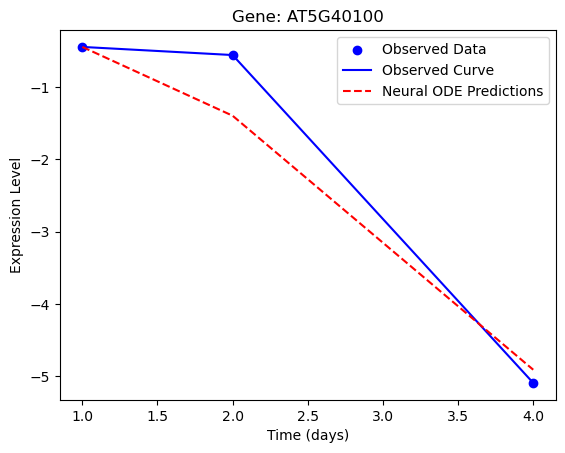

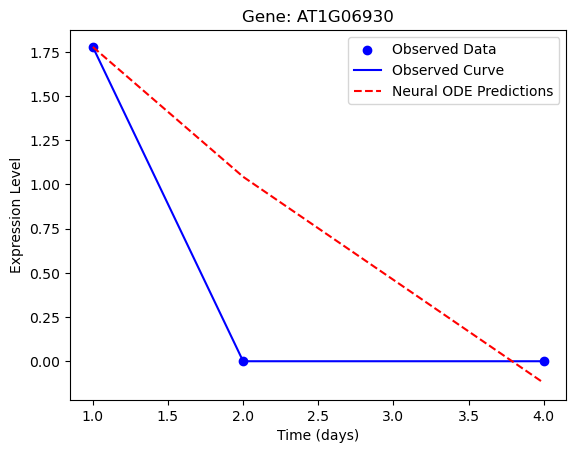

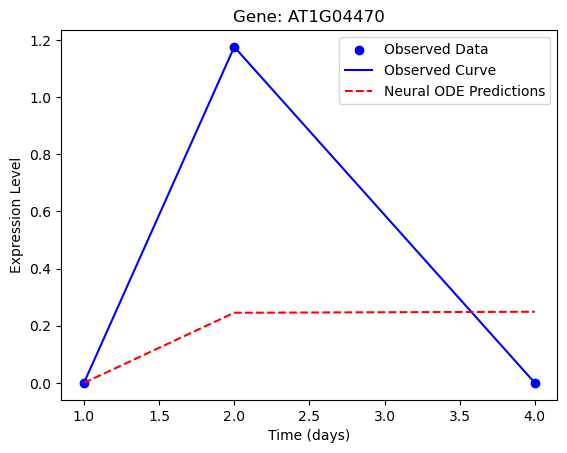

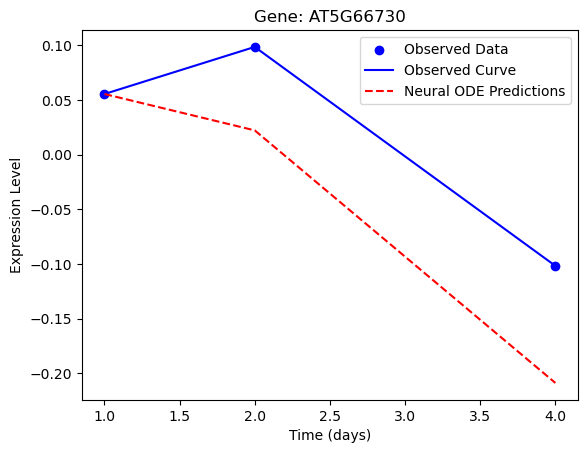

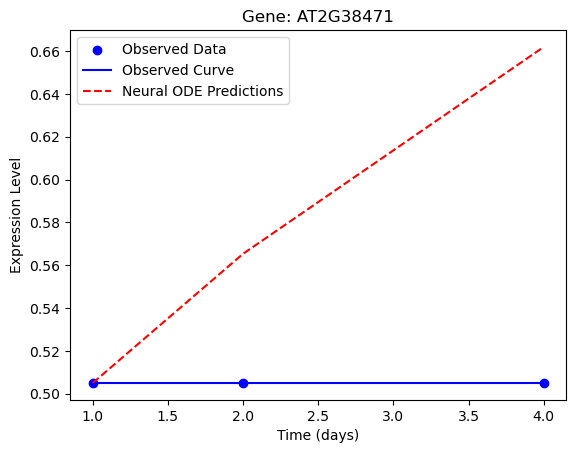

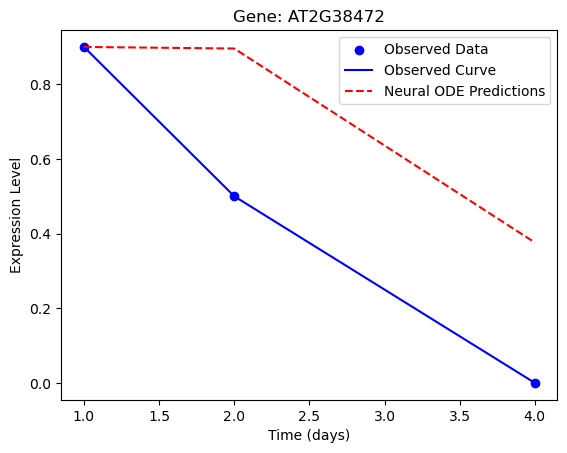

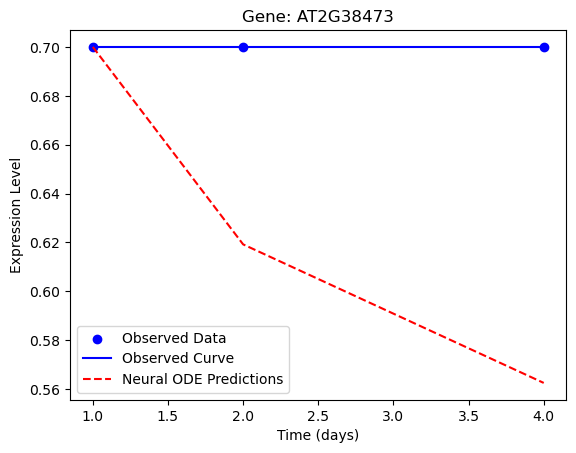

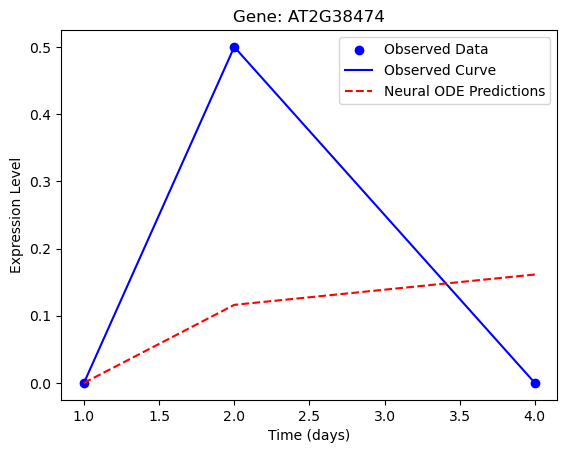

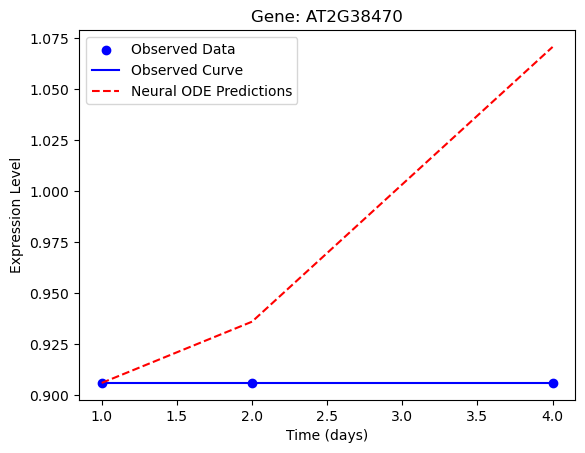

In [70]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt

##############################################################################
# Data Setup (Row-wise, Each Column is a Different Day)
##############################################################################

# data = {
#     "Gene": ["AT5G40100", "AT1G06930", "AT1G04470", "AT5G66730", "AT2G384713"],
#     "Day1":  [-0.44796,    1.77836,     0.0,         0.05537,    0.505000   ],
#     "Day2":  [-0.56015,    0.0,         1.17515,     0.09843,  0.505000   ],
#     "Day4":  [-5.09196,    0.0,         0.0,        -0.10176,  0.505000   ],
# }

# df = pd.DataFrame(data)
df =df
# Time points (in days)
time_points = np.array([1.0, 2.0, 4.0], dtype=np.float32)  # day1, day2, day4

# gene_data shape: (num_genes, num_time_points)
# gene_data = df[["Day1", "Day2", "Day4"]].values  # 4 genes x 3 time points
gene_data = df[["Hpa-NO_1d", "Hpa-NO_2d", "Hpa-NO_4d"]].values

# Convert to PyTorch tensors
time_points_tensor = torch.tensor(time_points,dtype=torch.float32,  requires_grad=True)
gene_data_tensor = torch.tensor(gene_data, dtype=torch.float32)


##############################################################################
# Neural ODE Model for Each Gene
##############################################################################

class GeneSpecificODE(nn.Module):
    """
    A small neural network that models dY/dt for a single gene as a function of time, t.
    The forward() method returns the derivative dy/dt given (t, y).
    """
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 16),  # input: scalar t, output: hidden dimension
            nn.Tanh(),
            nn.Linear(16, 1)   # output: derivative dY/dt
        )

    def forward(self, t, y):
        """
        :param t: current time (scalar)
        :param y: current expression (ignored in this minimal model)
        :return: dy/dt predicted by the neural net
        """
        # For simplicity, we only pass time t into the net (and ignore y).
        # If you want Y dependence, you could concatenate [t, y] as input.
        t_tensor = torch.ones_like(y) * t  # shape: (batch_size, 1)
        dy_dt = self.net(t_tensor)
        return dy_dt


# Create one ODE model per gene
num_genes = gene_data_tensor.shape[0]
ode_models = nn.ModuleList([GeneSpecificODE() for _ in range(num_genes)])


##############################################################################
# Training Loss Function
##############################################################################

def inverse_pinn_loss(ode_models, time_points, gene_data, lambda_physics=0.1):
    """
    :param ode_models: list of neural ODE models, one per gene
    :param time_points: tensor of shape (num_time_points,)
    :param gene_data: tensor of shape (num_genes, num_time_points)
    :param lambda_physics: weight for the physics/ODE consistency term
    :return: (total_loss, data_loss, physics_loss)
    """
    total_data_loss = 0.0
    total_physics_loss = 0.0
    n_genes = gene_data.shape[0]

    for i in range(n_genes):
        y_observed = gene_data[i]  # e.g. [-0.45, -0.56, -5.09]

        # The first time point is our "initial condition"
        y0 = y_observed[0].unsqueeze(0)  # shape (1,)

        # odeint() requires an initial condition shape (batch_size,) or (batch_size, dim)
        preds = odeint(ode_models[i], y0, time_points).squeeze()

        # 1) Data loss: MSE between predicted and observed
        data_loss = torch.mean((preds - y_observed) ** 2)

        # 2) Physics loss: measure how consistent the predicted derivative is with the ODE network
        dy_dt_pred = torch.autograd.grad(
            outputs=preds,
            inputs=time_points,
            grad_outputs=torch.ones_like(preds),
            create_graph=True,
            retain_graph=True
        )[0]  # shape: (num_time_points,)

        # Evaluate the ODE derivative from the model
        dy_dt_ode = []
        for t_val, p_val in zip(time_points, preds):
            # The ODE model expects (t, y) but we're ignoring y in forward()
            deriv = ode_models[i](t_val, p_val.unsqueeze(0))
            dy_dt_ode.append(deriv.squeeze())
        dy_dt_ode = torch.stack(dy_dt_ode)

        physics_loss = torch.mean((dy_dt_pred - dy_dt_ode) ** 2)

        total_data_loss += data_loss
        total_physics_loss += physics_loss

    avg_data_loss = total_data_loss / n_genes
    avg_physics_loss = total_physics_loss / n_genes

    total_loss = avg_data_loss + lambda_physics * avg_physics_loss
    return total_loss, avg_data_loss, avg_physics_loss


##############################################################################
# Training Loop
##############################################################################

optimizer = optim.Adam(ode_models.parameters(), lr=0.01)
epochs = 30

for epoch in range(epochs):
    optimizer.zero_grad()
    total_loss, data_loss, physics_loss = inverse_pinn_loss(
        ode_models, time_points_tensor, gene_data_tensor, lambda_physics=0.1
    )
    total_loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch:4d} | "
              f"Total Loss: {total_loss.item():.4f} | "
              f"Data Loss: {data_loss.item():.4f} | "
              f"Physics Loss: {physics_loss.item():.4f}")


##############################################################################
# Plotting and Printing Results
##############################################################################

with torch.no_grad():
    # for i, gene_id in enumerate(df['Gene']):
    for i, gene_id in enumerate(df['Unnamed: 0']):

        y0 = gene_data_tensor[i, 0].unsqueeze(0)  # shape (1,)
        preds = odeint(ode_models[i], y0, time_points_tensor).squeeze().numpy()

        # Plot observed data and model predictions
        plt.figure()
        plt.scatter(time_points, gene_data[i], c='b', label="Observed Data")
        plt.plot(time_points, gene_data[i], 'b-', label="Observed Curve")
        plt.plot(time_points, preds, 'r--', label="Neural ODE Predictions")
        plt.title(f"Gene: {gene_id}")
        plt.xlabel("Time (days)")
        plt.ylabel("Expression Level")
        plt.legend()
        plt.show()



In [71]:

# ##############################################################################
# # Print Learned ODE Equations and Parameters
# ##############################################################################

# print("\nLearned ODE Parameters and Equations:")
# # for i, gene_id in enumerate(df["Gene"]):
# for i, gene_id in enumerate(df['Unnamed: 0']):

#     model = ode_models[i]
#     print(f"Gene: {gene_id}")

#     # Print each parameter (weights and biases)
#     for name, param in model.named_parameters():
#         if param.requires_grad:
#             print(f"  {name}: {param.data}")

#     # For demonstration, we assume the ODE is:
#     # dY/dt = W2 * tanh(W1 * t + b1) + b2
#     # (since we only pass t to the net, ignoring Y)
#     W1 = model.net[0].weight.detach().numpy().flatten()
#     b1 = model.net[0].bias.detach().numpy().flatten()
#     W2 = model.net[2].weight.detach().numpy().flatten()
#     b2 = model.net[2].bias.detach().numpy().flatten()

#     eq_str = f"d({gene_id})/dt = {W2[0]:.4f} * tanh({W1[0]:.4f} * t + {b1[0]:.4f}) + {b2[0]:.4f}"
#     print("  " + eq_str + "\n")



##############################################################################
# Print Learned ODE Equations
##############################################################################

print("\nLearned ODE Equations:")
# for i, gene_id in enumerate(df["Gene"]):
for i, gene_id in enumerate(df['Unnamed: 0']):

    model = ode_models[i]
    print(f"Gene: {gene_id}")

    # Print each parameter (weights and biases)
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"  {name}: {param.data}")
    
    # Extract parameters from network layers
    W1 = model.net[0].weight.detach().numpy().flatten()
    b1 = model.net[0].bias.detach().numpy().flatten()
    W2 = model.net[2].weight.detach().numpy().flatten()
    b2 = model.net[2].bias.detach().numpy().item()
    
    # Format equation components
    equation = f"dy/dt = "
    for j in range(16):  # For each hidden neuron
        equation += f"({W2[j]:.3f}) * tanh({W1[j]:.3f}·t + {b1[j]:.3f}) + "
    equation += f"{b2:.3f}"
    
    print(f"\nGene: {gene_id}")
    print("Structure: dy/dt = Σ[w2_i * tanh(w1_i*t + b1_i)] + b2")
    print("Full equation:")
    print(equation)


Learned ODE Equations:
Gene: AT5G40100
  net.0.weight: tensor([[ 0.7003],
        [ 0.8203],
        [ 0.3901],
        [-0.0605],
        [ 0.9000],
        [ 0.5678],
        [-0.5909],
        [ 0.8136],
        [-0.1357],
        [ 0.0186],
        [ 0.5863],
        [-0.4227],
        [-0.8298],
        [ 0.3751],
        [-0.4476],
        [ 0.0253]])
  net.0.bias: tensor([ 0.4146, -0.2285, -0.0549,  0.6379,  0.9384, -0.2418,  0.5405,  0.7582,
        -0.2772, -0.3975,  0.8470,  0.2659,  0.7794, -0.5326,  0.6667,  0.4453])
  net.2.weight: tensor([[-0.2132, -0.1147, -0.2720, -0.0808,  0.1796, -0.3204,  0.1399,  0.1456,
         -0.0064,  0.1195, -0.1275,  0.2235,  0.3216, -0.2690,  0.2393,  0.1200]])
  net.2.bias: tensor([-0.2780])

Gene: AT5G40100
Structure: dy/dt = Σ[w2_i * tanh(w1_i*t + b1_i)] + b2
Full equation:
dy/dt = (-0.213) * tanh(0.700·t + 0.415) + (-0.115) * tanh(0.820·t + -0.229) + (-0.272) * tanh(0.390·t + -0.055) + (-0.081) * tanh(-0.061·t + 0.638) + (0.180) * tanh(

# Neural ode +Inverse Pinn

## LSTM 

        t_tensor = torch.ones_like(y) * t  # shape (batch_size, 1)
        # Concatenate along the last dimension to form (batch_size, 2)
        combined = torch.cat([y, t_tensor], dim=-1)
        # Add sequence dimension: (batch_size, seq_len=1, input_size=2)
        seq_input = combined.unsqueeze(1)
        # Pass through the LSTM. Here, we ignore the hidden state between calls.
        lstm_out, _ = self.lstm(seq_input)
        # Take the output of the last time step and pass it through the linear layer.
        dy_dt = self.linear(lstm_out[:, -1, :])
        return dy_dt

In [72]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt

# Example data (each row is one gene, each column is a time point)
# data = {
#     "Gene": ["AT5G40100", "AT1G06930", "AT1G04470", "AT5G66730"],
#     "Day1":  [-0.44796, 1.77836, 0.0, 0.05537],
#     "Day2":  [-0.56015, 0.0, 1.17515, 0.09843],
#     "Day3":  [-5.09196, 0.0, 0.0, -0.10176]
# }

data = {
    "Gene": ["AT5G40100", "AT1G06930", "AT1G04470", "AT5G66730", "AT2G384713"],
    "Day1":  [-0.44796,    1.77836,     0.0,         0.05537,    0.505000   ],
    "Day2":  [-0.56015,    0.0,         1.17515,     0.09843,  0.505000   ],
    "Day4":  [-5.09196,    0.0,         0.0,        -0.10176,  0.505000   ],
}

df = pd.DataFrame(data)
time_points = np.array([1.0, 2.0, 3.0], dtype=np.float32)
gene_data = df[["Day1", "Day2", "Day4"]].values  # Shape: (num_genes, num_time_points)

# Convert to PyTorch tensors
time_points_tensor = torch.tensor(time_points, dtype=torch.float32, requires_grad=True)
gene_data_tensor = torch.tensor(gene_data, dtype=torch.float32)

##############################################################################
# Neural ODE with LSTM
##############################################################################

class GeneSpecificODE_LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        # Here, we use an LSTM to process a 2D input: [y, t]
        # We treat each evaluation as a sequence of length 1.
        self.lstm = nn.LSTM(input_size=2, hidden_size=16, num_layers=1, batch_first=True)
        self.linear = nn.Linear(16, 1)  # Map LSTM output to the derivative

    def forward(self, t, y):
        # y: shape (batch_size, 1) -- current gene expression.
        # We combine y and t into a 2-element feature.
        # Create a tensor for t of the same shape as y.
        t_tensor = torch.ones_like(y) * t  # shape (batch_size, 1)
        # Concatenate along the last dimension to form (batch_size, 2)
        combined = torch.cat([y, t_tensor], dim=-1)
        # Add sequence dimension: (batch_size, seq_len=1, input_size=2)
        seq_input = combined.unsqueeze(1)
        # Pass through the LSTM. Here, we ignore the hidden state between calls.
        lstm_out, _ = self.lstm(seq_input)
        # Take the output of the last time step and pass it through the linear layer.
        dy_dt = self.linear(lstm_out[:, -1, :])
        return dy_dt

# Initialize one LSTM-based ODE model per gene
n_genes = gene_data_tensor.shape[0]
ode_models_lstm = nn.ModuleList([GeneSpecificODE_LSTM() for _ in range(n_genes)])

##############################################################################
# Define the Training Loss Function
##############################################################################

def inverse_pinn_loss(ode_models, time_points, gene_data, lambda_physics=0.1):
    total_data_loss = 0.0
    total_physics_loss = 0.0
    n_genes = gene_data.shape[0]

    for i in range(n_genes):
        y_true = gene_data[i].unsqueeze(-1)  # shape: (num_time_points, 1)
        y0 = y_true[0].unsqueeze(0)  # initial condition

        preds = odeint(ode_models[i], y0, time_points).squeeze()  # shape: (num_time_points,)
        data_loss = torch.mean((preds - y_true.squeeze()) ** 2)

        dy_dt_pred = torch.autograd.grad(
            outputs=preds,
            inputs=time_points,
            grad_outputs=torch.ones_like(preds),
            create_graph=True,
            retain_graph=True
        )[0]

        # Reshape 'p' to (batch_size, 1) before concatenating with 't_tensor'
        dy_dt_ode = torch.stack([ode_models[i](t, p.reshape(-1, 1)) for t, p in zip(time_points, preds)]).squeeze()
        physics_loss = torch.mean((dy_dt_pred - dy_dt_ode) ** 2)

        total_data_loss += data_loss
        total_physics_loss += physics_loss

    avg_data_loss = total_data_loss / n_genes
    avg_physics_loss = total_physics_loss / n_genes
    total_loss = avg_data_loss + lambda_physics * avg_physics_loss
    return total_loss, avg_data_loss, avg_physics_loss

##############################################################################
# Training Loop
##############################################################################

optimizer = optim.Adam(ode_models_lstm.parameters(), lr=0.01)
epochs = 30

for epoch in range(epochs):
    optimizer.zero_grad()
    total_loss, data_loss, physics_loss = inverse_pinn_loss(
        ode_models_lstm, time_points_tensor, gene_data_tensor, lambda_physics=0.1
    )
    total_loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch:4d} | Total Loss: {total_loss.item():.4f} | Data Loss: {data_loss.item():.4f} | Physics Loss: {physics_loss.item():.4f}")



Epoch    0 | Total Loss: 1.8957 | Data Loss: 1.8946 | Physics Loss: 0.0114
Epoch   10 | Total Loss: 1.0412 | Data Loss: 1.0075 | Physics Loss: 0.3378
Epoch   20 | Total Loss: 0.5551 | Data Loss: 0.4026 | Physics Loss: 1.5245


In [73]:
print("\nLearned ODE Equations (LSTM-based):")
for i, gene_id in enumerate(df["Gene"]):
    model = ode_models_lstm[i]
    print(f"\nGene: {gene_id}")
    
    # Extract LSTM parameters
    lstm_weights = {}
    for name, param in model.lstm.named_parameters():
        if param.requires_grad:
            lstm_weights[name] = param.data.detach().numpy()
    
    # Extract linear layer parameters
    W_linear = model.linear.weight.detach().numpy().flatten()
    b_linear = model.linear.bias.detach().numpy().item()
    
    # Symbolic representation of the LSTM-based ODE
    print("ODE Structure:")
    print("dy/dt = LinearLayer(LSTM([y(t), t]))")
    print("Where LSTM processes [y(t), t] as a sequence of length 1.")
    print(f"LSTM hidden size: {model.lstm.hidden_size}")
    print(f"Linear layer weights: {W_linear}")
    print(f"Linear layer bias: {b_linear:.4f}")
    
    # Detailed parameter dump (optional)
    print("\nLSTM Parameters:")
    for name, value in lstm_weights.items():
        print(f"{name}: shape={value.shape}")


Learned ODE Equations (LSTM-based):

Gene: AT5G40100
ODE Structure:
dy/dt = LinearLayer(LSTM([y(t), t]))
Where LSTM processes [y(t), t] as a sequence of length 1.
LSTM hidden size: 16
Linear layer weights: [ 0.40225628 -0.26758382 -0.13196081 -0.33037254 -0.42143643  0.19810365
  0.17358331 -0.27119794 -0.09886727 -0.08319629 -0.35171762 -0.3153888
 -0.33712244  0.11258937 -0.24691011  0.27255   ]
Linear layer bias: -0.3093

LSTM Parameters:
weight_ih_l0: shape=(64, 2)
weight_hh_l0: shape=(64, 16)
bias_ih_l0: shape=(64,)
bias_hh_l0: shape=(64,)

Gene: AT1G06930
ODE Structure:
dy/dt = LinearLayer(LSTM([y(t), t]))
Where LSTM processes [y(t), t] as a sequence of length 1.
LSTM hidden size: 16
Linear layer weights: [-0.01036697  0.26167852 -0.2560707   0.2876018   0.42153186 -0.03870848
  0.23228703 -0.20179336  0.25117305 -0.3791176   0.40670514 -0.07306175
  0.05855553  0.12341093  0.01380482 -0.39224085]
Linear layer bias: -0.0814

LSTM Parameters:
weight_ih_l0: shape=(64, 2)
weight_hh

In [75]:


##############################################################################
# Print Learned ODE Parameters and Equations for Each Gene
##############################################################################

print("\nLearned ODE Parameters and Equations (LSTM version):")
for i, gene_id in enumerate(df["Gene"]):
    model = ode_models_lstm[i]
    print(f"Gene: {gene_id}")
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"  {name}: {param.data}")

    # For the sake of interpretation, we note that the derivative is computed as:
    # dY/dt = Linear( LSTM( [Y, t] ) )
    # Here we extract the linear layer parameters.
    W_linear = model.linear.weight.detach().numpy().flatten()
    b_linear = model.linear.bias.detach().numpy().flatten()
    equation = f"d({gene_id})/dt = LSTM_output*({W_linear[0]:.4f}) + {b_linear[0]:.4f}"
    print("  " + equation + "\n")



Learned ODE Parameters and Equations (LSTM version):
Gene: AT5G40100
  lstm.weight_ih_l0: tensor([[-0.0236,  0.3912],
        [-0.4661,  0.1514],
        [-0.1076, -0.0029],
        [-0.4443,  0.2021],
        [-0.1966,  0.4651],
        [ 0.0924,  0.2260],
        [-0.2952,  0.1502],
        [-0.4315,  0.3153],
        [ 0.1954, -0.1694],
        [ 0.2491, -0.2683],
        [-0.2157,  0.2230],
        [ 0.0089,  0.0674],
        [-0.4227,  0.3650],
        [-0.0307, -0.1128],
        [-0.2113,  0.2964],
        [-0.3178,  0.2686],
        [ 0.0878,  0.0377],
        [ 0.1538,  0.1878],
        [ 0.0936, -0.0115],
        [ 0.0091, -0.1721],
        [ 0.1531, -0.1431],
        [-0.1051, -0.2299],
        [ 0.2047, -0.1046],
        [ 0.1358,  0.1111],
        [-0.0313, -0.1172],
        [ 0.1816,  0.0331],
        [ 0.1977,  0.1147],
        [ 0.0320, -0.2328],
        [-0.1930,  0.1802],
        [-0.1134, -0.2311],
        [ 0.2452, -0.0493],
        [ 0.1752, -0.1613],
        [ 0.2

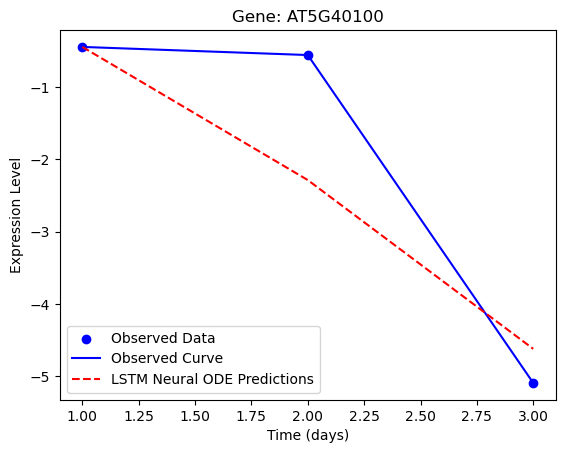

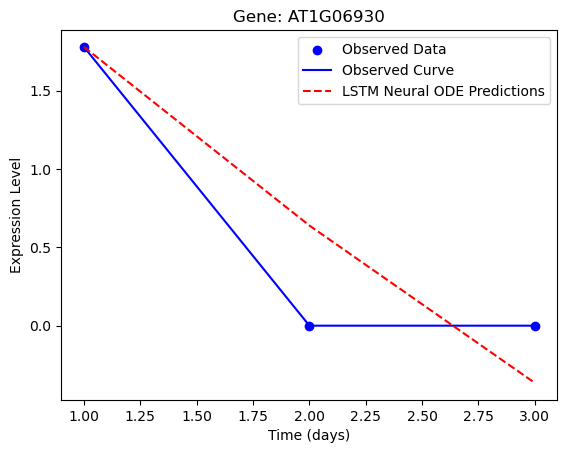

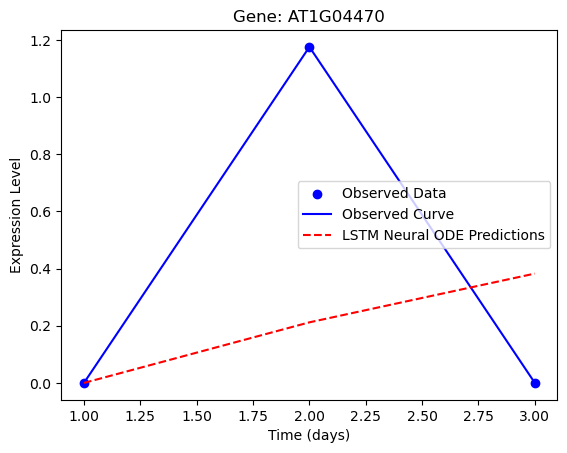

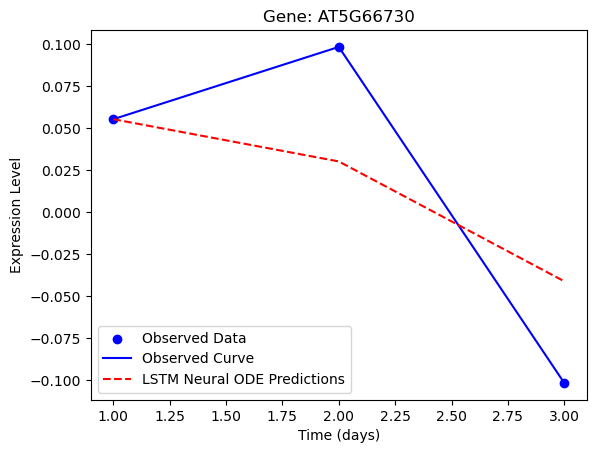

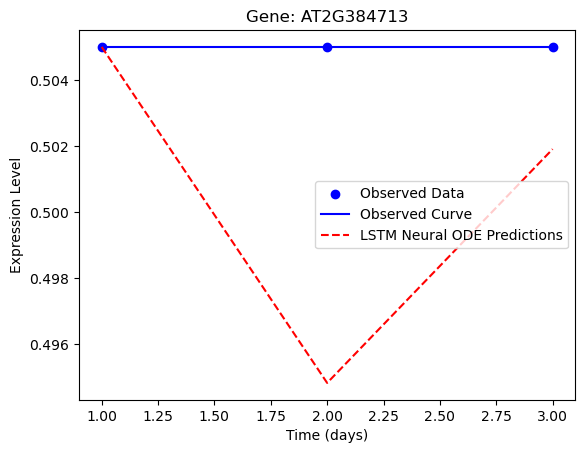

In [76]:
##############################################################################
# Plotting and Printing Results
##############################################################################

with torch.no_grad():
    for i, gene_id in enumerate(df["Gene"]):
        y0 = gene_data_tensor[i, 0].unsqueeze(0).unsqueeze(-1)
        preds = odeint(ode_models_lstm[i], y0, time_points_tensor).squeeze().numpy()
        plt.figure()
        plt.scatter(time_points, gene_data[i], c='b', label="Observed Data")
        plt.plot(time_points, gene_data[i], 'b-', label="Observed Curve")
        plt.plot(time_points, preds, 'r--', label="LSTM Neural ODE Predictions")
        plt.title(f"Gene: {gene_id}")
        plt.xlabel("Time (days)")
        plt.ylabel("Expression Level")
        plt.legend()
        plt.show()

# Neural ode +Inverse Pinn

## Parametric ODE Model for Each Gene: dy/dt = α + β * y(t) + γ * t


Original Data:
         Gene  Hpa-NO_1d  Hpa-NO_2d  Hpa-NO_4d
0   AT5G40100   -0.44796   -0.56015   -5.09196
1   AT1G06930    1.77836    0.00000    0.00000
2   AT1G04470    0.00000    1.17515    0.00000
3   AT5G66730    0.05537    0.09843   -0.10176
4  AT2G384713    0.50500    0.50500    0.50500
Epoch    0 | Total Loss: 3.7946 | Data Loss: 3.7698 | Physics Loss: 0.2482
Epoch  100 | Total Loss: 0.2664 | Data Loss: 0.1948 | Physics Loss: 0.7163


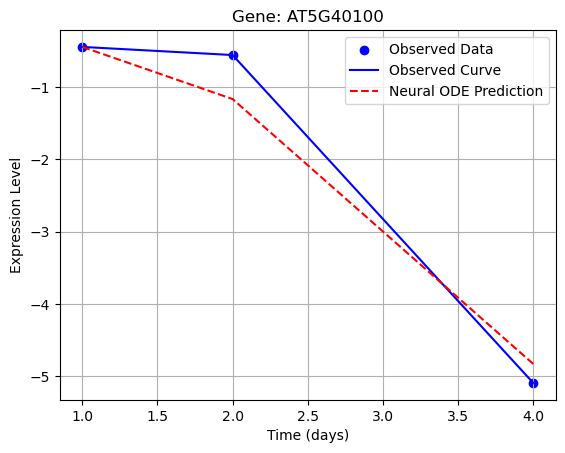

Learned ODE for Gene AT5G40100:
  dy/dt = -0.0326 + 0.3630 * y + -0.2739 * t
Formatted ODE Equation: dy/dt = -0.0326 + 0.3630 * y(t) + -0.2739 * t



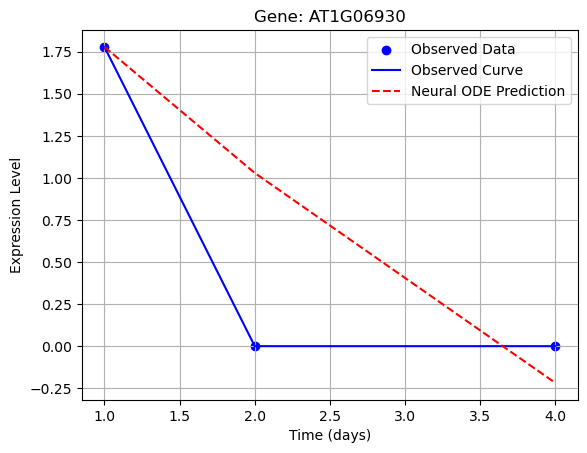

Learned ODE for Gene AT1G06930:
  dy/dt = -0.2003 + -0.2799 * y + -0.1055 * t
Formatted ODE Equation: dy/dt = -0.2003 + -0.2799 * y(t) + -0.1055 * t



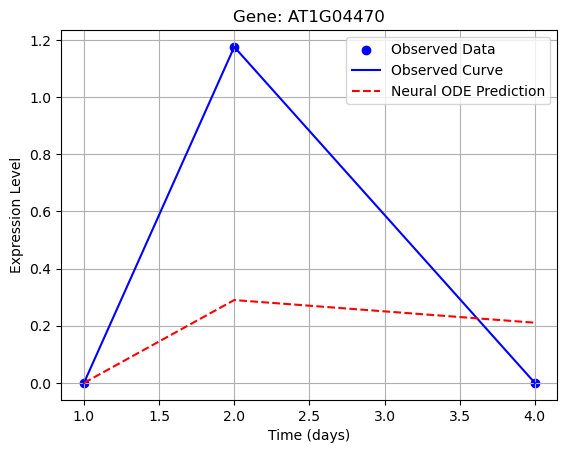

Learned ODE for Gene AT1G04470:
  dy/dt = 0.6305 + -0.3582 * y + -0.1867 * t
Formatted ODE Equation: dy/dt = 0.6305 + -0.3582 * y(t) + -0.1867 * t



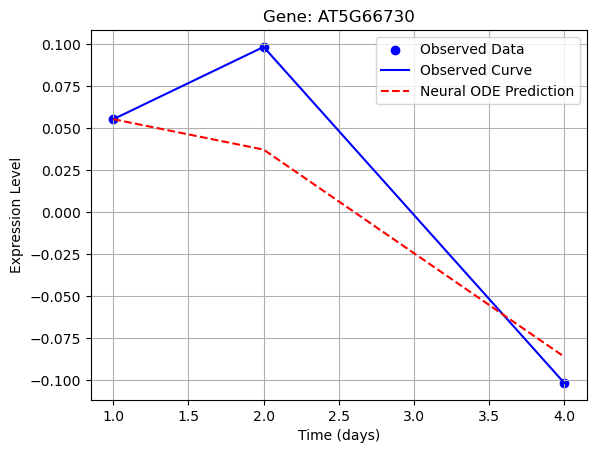

Learned ODE for Gene AT5G66730:
  dy/dt = 0.0313 + -0.0517 * y + -0.0313 * t
Formatted ODE Equation: dy/dt = 0.0313 + -0.0517 * y(t) + -0.0313 * t



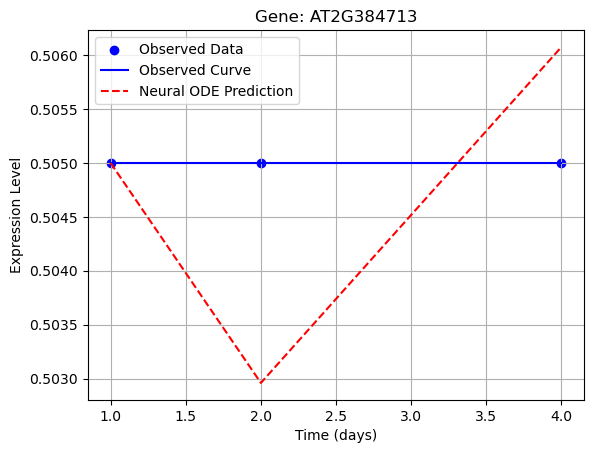

Learned ODE for Gene AT2G384713:
  dy/dt = 0.0071 + -0.0253 * y + 0.0024 * t
Formatted ODE Equation: dy/dt = 0.0071 + -0.0253 * y(t) + 0.0024 * t



In [86]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt

##############################################################################
# Data Setup (Row-wise: Each row is a gene; columns are Day1, Day2, Day4)
##############################################################################

# Example dataset (here using gene names and expression values)
# data = {
#     "Gene": ["AT5G40100", "AT1G06930", "AT1G04470", "AT5G66730"],
#     "Hpa-NO_1d": [-0.44796, 1.77836, 0.0, 0.05537],
#     "Hpa-NO_2d": [-0.56015, 0.0, 1.17515, 0.09843],
#     "Hpa-NO_4d": [-5.09196, 0.0, 0.0, -0.10176],
# }


data = {
    "Gene": ["AT5G40100", "AT1G06930", "AT1G04470", "AT5G66730", "AT2G384713"],
    "Hpa-NO_1d":  [-0.44796,    1.77836,     0.0,         0.05537,    0.505000   ],
    "Hpa-NO_2d":  [-0.56015,    0.0,         1.17515,     0.09843,  0.505000   ],
    "Hpa-NO_4d":  [-5.09196,    0.0,         0.0,        -0.10176,  0.505000   ],
}


df = pd.DataFrame(data)
df = df 
print("Original Data:")
print(df)

# Time points (in days)
time_points = np.array([1.0, 2.0, 4.0], dtype=np.float32)  # Day1, Day2, Day4

# Extract gene expression data (each row is one gene)
gene_data = df[["Hpa-NO_1d", "Hpa-NO_2d", "Hpa-NO_4d"]].values

# Convert to PyTorch tensors
time_points_tensor = torch.tensor(time_points, dtype=torch.float32, requires_grad=True)
gene_data_tensor = torch.tensor(gene_data, dtype=torch.float32)

##############################################################################
# Parametric ODE Model for Each Gene: dy/dt = α + β * y(t) + γ * t
##############################################################################

class GeneParametricODE(nn.Module):
    def __init__(self):
        super(GeneParametricODE, self).__init__()
        # Learnable parameters: α, β, and γ
        self.alpha = nn.Parameter(torch.tensor(0.1))
        self.beta = nn.Parameter(torch.tensor(0.1))
        self.gamma = nn.Parameter(torch.tensor(0.1))
    
    def forward(self, t, y):
        # ODE: dy/dt = α + β * y(t) + γ * t
        return self.alpha + self.beta * y + self.gamma * t

# Create one ODE model per gene
num_genes = gene_data_tensor.shape[0]
ode_models = nn.ModuleList([GeneParametricODE() for _ in range(num_genes)])

##############################################################################
# Inverse PINN Loss Function (Data Loss + Physics Loss)
##############################################################################

def inverse_pinn_loss(ode_models, time_points, gene_data, lambda_physics=0.1):
    total_data_loss = 0.0
    total_physics_loss = 0.0
    n_genes = gene_data.shape[0]
    
    for i in range(n_genes):
        # Observed expression for gene i (shape: (num_time_points,))
        y_observed = gene_data[i]
        # Use the first time point as the initial condition
        y0 = y_observed[0].unsqueeze(0)  # shape: (1,)
        
        # Solve the ODE for gene i over the time points
        preds = odeint(ode_models[i], y0, time_points).squeeze()  # shape: (num_time_points,)
        
        # Data loss: Mean squared error between predictions and observed values
        data_loss = torch.mean((preds - y_observed)**2)
        
        # Physics loss: Enforce that the derivative from autograd matches the ODE output
        dy_dt_pred = torch.autograd.grad(
            outputs=preds,
            inputs=time_points,
            grad_outputs=torch.ones_like(preds),
            create_graph=True,
            retain_graph=True
        )[0]
        
        dy_dt_ode = []
        for t_val, p_val in zip(time_points, preds):
            deriv = ode_models[i](t_val, p_val.unsqueeze(0))
            dy_dt_ode.append(deriv.squeeze())
        dy_dt_ode = torch.stack(dy_dt_ode)
        
        physics_loss = torch.mean((dy_dt_pred - dy_dt_ode)**2)
        
        total_data_loss += data_loss
        total_physics_loss += physics_loss
    
    avg_data_loss = total_data_loss / n_genes
    avg_physics_loss = total_physics_loss / n_genes
    total_loss = avg_data_loss + lambda_physics * avg_physics_loss
    return total_loss, avg_data_loss, avg_physics_loss

##############################################################################
# Training Loop
##############################################################################

optimizer = optim.Adam(ode_models.parameters(), lr=0.01)
epochs = 200

for epoch in range(epochs):
    optimizer.zero_grad()
    total_loss, data_loss, physics_loss = inverse_pinn_loss(ode_models, time_points_tensor, gene_data_tensor, lambda_physics=0.1)
    total_loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch:4d} | Total Loss: {total_loss.item():.4f} | Data Loss: {data_loss.item():.4f} | Physics Loss: {physics_loss.item():.4f}")

##############################################################################
# Plotting Predictions and Printing Learned ODE Parameters
##############################################################################

with torch.no_grad():
    for i, gene_id in enumerate(df['Gene']):
        # Use the Day1 value as the initial condition for each gene
        y0 = gene_data_tensor[i, 0].unsqueeze(0)  # shape: (1,)
        preds = odeint(ode_models[i], y0, time_points_tensor).squeeze().numpy()
        
        # Plot observed data vs. Neural ODE predictions
        plt.figure()
        plt.scatter(time_points, gene_data[i], c='b', label="Observed Data")
        plt.plot(time_points, gene_data[i], 'b-', label="Observed Curve")
        plt.plot(time_points, preds, 'r--', label="Neural ODE Prediction")
        plt.title(f"Gene: {gene_id}")
        plt.xlabel("Time (days)")
        plt.ylabel("Expression Level")
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # Print learned parameters for the gene
        model = ode_models[i]
        alpha = model.alpha.item()
        beta = model.beta.item()
        gamma = model.gamma.item()
        print(f"Learned ODE for Gene {gene_id}:")
        print(f"  dy/dt = {alpha:.4f} + {beta:.4f} * y + {gamma:.4f} * t")
        print(f"Formatted ODE Equation: dy/dt = {alpha:.4f} + {beta:.4f} * y(t) + {gamma:.4f} * t\n")



Learned Parameters:
         Gene     alpha      beta     gamma
0   AT5G40100 -0.032625  0.362959 -0.273890
1   AT1G06930 -0.200344 -0.279882 -0.105488
2   AT1G04470  0.630494 -0.358244 -0.186680
3   AT5G66730  0.031281 -0.051666 -0.031253
4  AT2G384713  0.007093 -0.025270  0.002398


c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


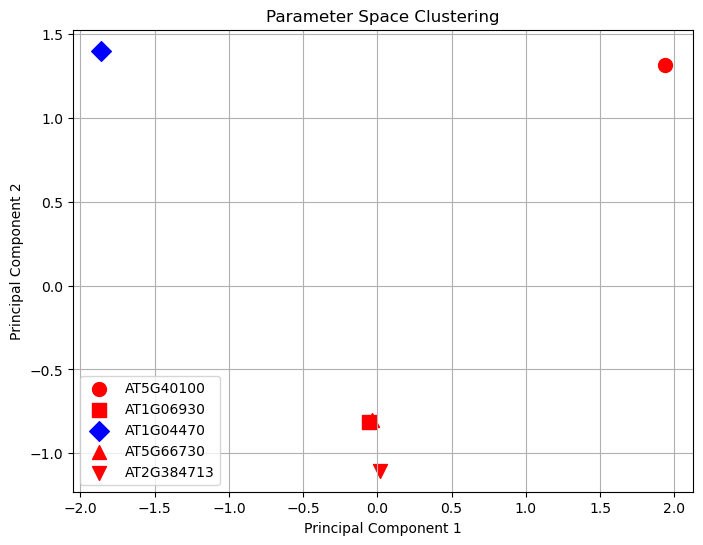


Cluster Analysis:

Cluster 0 - Genes:
AT5G40100, AT1G06930, AT5G66730, AT2G384713
Parameter Statistics:
Alpha: μ = -0.0486 ± 0.1045
Beta:  μ = 0.0015 ± 0.2667
Gamma: μ = -0.1021 ± 0.1231

Cluster 1 - Genes:
AT1G04470
Parameter Statistics:
Alpha: μ = 0.6305 ± nan
Beta:  μ = -0.3582 ± nan
Gamma: μ = -0.1867 ± nan

Parameters saved to gene_ode_parameters.csv


In [90]:
##############################################################################
# Step 1: Store and Print Learned Parameters
##############################################################################

# Create a DataFrame to store parameters
params_df = pd.DataFrame(columns=['Gene', 'alpha', 'beta', 'gamma'])

with torch.no_grad():
    for i, gene_id in enumerate(df['Gene']):
        model = ode_models[i]
        params_df.loc[i] = [
            gene_id,
            model.alpha.item(),
            model.beta.item(),
            model.gamma.item()
        ]

print("\nLearned Parameters:")
print(params_df)

##############################################################################
# Step 2: Parameter Clustering using K-means
##############################################################################

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Prepare data for clustering
X = params_df[['alpha', 'beta', 'gamma']].values

# Normalize parameters
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform K-means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add clusters to DataFrame
params_df['cluster'] = clusters

##############################################################################
# Step 3: Visualize Clusters with PCA
##############################################################################

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

# Create plot
plt.figure(figsize=(8, 6))
colors = ['r', 'b', 'g', 'm', 'y']
markers = ['o', 's', 'D', '^', 'v']

for i, gene in enumerate(params_df['Gene']):
    plt.scatter(
        principal_components[i, 0], 
        principal_components[i, 1],
        c=colors[clusters[i]],
        marker=markers[i],
        s=100,
        label=gene
    )

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Parameter Space Clustering')
plt.legend()
plt.grid(True)
plt.show()

##############################################################################
# Step 4: Cluster Analysis
##############################################################################

print("\nCluster Analysis:")
for cluster_id in sorted(params_df['cluster'].unique()):
    cluster_data = params_df[params_df['cluster'] == cluster_id]
    
    print(f"\nCluster {cluster_id} - Genes:")
    print(", ".join(cluster_data['Gene'].values))
    
    print("Parameter Statistics:")
    print(f"Alpha: μ = {cluster_data['alpha'].mean():.4f} ± {cluster_data['alpha'].std():.4f}")
    print(f"Beta:  μ = {cluster_data['beta'].mean():.4f} ± {cluster_data['beta'].std():.4f}")
    print(f"Gamma: μ = {cluster_data['gamma'].mean():.4f} ± {cluster_data['gamma'].std():.4f}")

##############################################################################
# Step 5: Save Parameters to CSV
##############################################################################

params_df.to_csv('gene_ode_parameters.csv', index=False)
print("\nParameters saved to gene_ode_parameters.csv")

c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


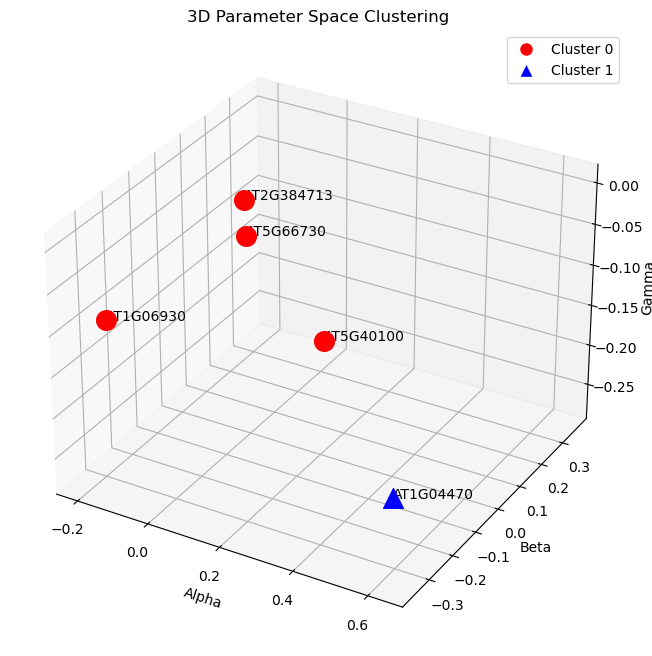

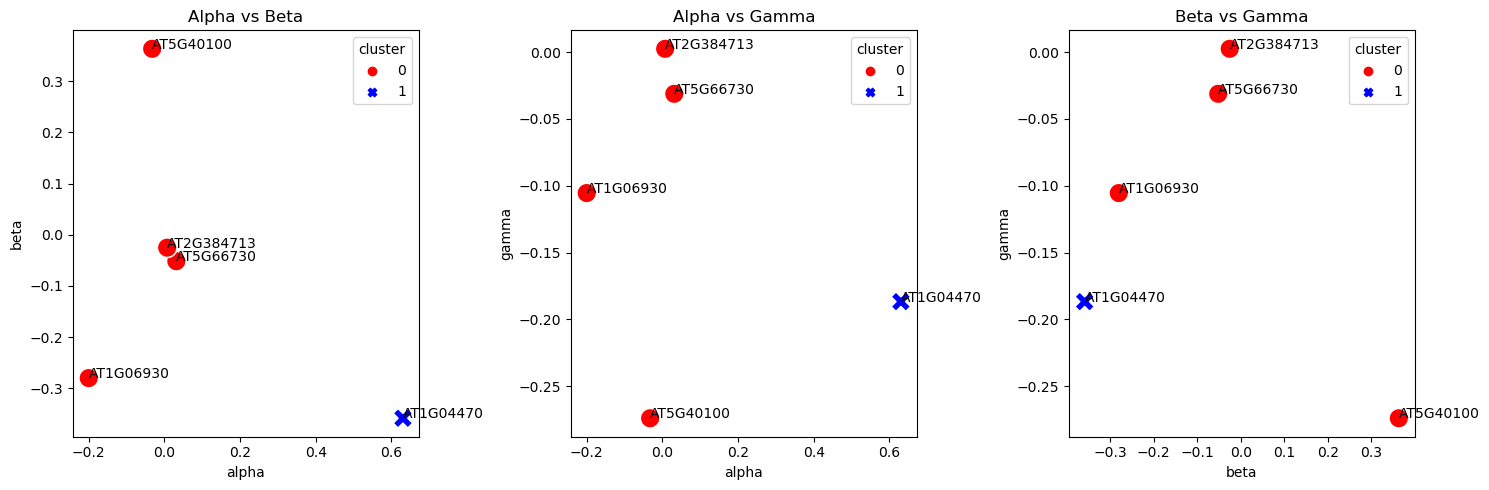


Cluster Characteristics:

Cluster 0 (4 genes):
Genes: AT5G40100, AT1G06930, AT5G66730, AT2G384713
Alpha: μ = -0.0486 ± 0.1045
Beta:  μ = 0.0015 ± 0.2667
Gamma: μ = -0.1021 ± 0.1231

Cluster 1 (1 genes):
Genes: AT1G04470
Alpha: μ = 0.6305 ± nan
Beta:  μ = -0.3582 ± nan
Gamma: μ = -0.1867 ± nan


In [91]:
##############################################################################
# Parameter Clustering and Visualization
##############################################################################

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Create a DataFrame with learned parameters
params = []
for i, gene_id in enumerate(df['Gene']):
    model = ode_models[i]
    params.append({
        'Gene': gene_id,
        'alpha': model.alpha.item(),
        'beta': model.beta.item(),
        'gamma': model.gamma.item()
    })
params_df = pd.DataFrame(params)

# Normalize parameters for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(params_df[['alpha', 'beta', 'gamma']])

# Perform K-means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
params_df['cluster'] = kmeans.fit_predict(X_scaled)

##############################################################################
# 3D Parameter Space Visualization
##############################################################################

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Assign colors and markers based on clusters
colors = ['r', 'b']
markers = ['o', '^']

for idx, row in params_df.iterrows():
    ax.scatter(
        row['alpha'], 
        row['beta'], 
        row['gamma'],
        c=colors[row['cluster']],
        marker=markers[row['cluster']],
        s=200,
        label=row['Gene'] if idx == 0 else ""
    )

ax.set_xlabel('Alpha')
ax.set_ylabel('Beta')
ax.set_zlabel('Gamma')
ax.set_title('3D Parameter Space Clustering')

# Add gene labels
for idx, row in params_df.iterrows():
    ax.text(row['alpha'], row['beta'], row['gamma'], row['Gene'], 
            size=10, zorder=1, color='k')

plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10, label='Cluster 0'),
    plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='b', markersize=10, label='Cluster 1')
])
plt.show()

##############################################################################
# Pairwise Parameter Visualization
##############################################################################

import seaborn as sns

# Create pair plots
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.scatterplot(data=params_df, x='alpha', y='beta', hue='cluster', 
                style='cluster', s=200, palette=['r', 'b'])
plt.title('Alpha vs Beta')
for line in range(0, params_df.shape[0]):
    plt.text(params_df.alpha[line], params_df.beta[line], params_df.Gene[line])

plt.subplot(1, 3, 2)
sns.scatterplot(data=params_df, x='alpha', y='gamma', hue='cluster', 
                style='cluster', s=200, palette=['r', 'b'])
plt.title('Alpha vs Gamma')
for line in range(0, params_df.shape[0]):
    plt.text(params_df.alpha[line], params_df.gamma[line], params_df.Gene[line])

plt.subplot(1, 3, 3)
sns.scatterplot(data=params_df, x='beta', y='gamma', hue='cluster', 
                style='cluster', s=200, palette=['r', 'b'])
plt.title('Beta vs Gamma')
for line in range(0, params_df.shape[0]):
    plt.text(params_df.beta[line], params_df.gamma[line], params_df.Gene[line])

plt.tight_layout()
plt.show()

##############################################################################
# Cluster Analysis
##############################################################################

print("\nCluster Characteristics:")
for cluster in sorted(params_df.cluster.unique()):
    cluster_data = params_df[params_df.cluster == cluster]
    print(f"\nCluster {cluster} ({len(cluster_data)} genes):")
    print("Genes:", ", ".join(cluster_data.Gene.values))
    print(f"Alpha: μ = {cluster_data.alpha.mean():.4f} ± {cluster_data.alpha.std():.4f}")
    print(f"Beta:  μ = {cluster_data.beta.mean():.4f} ± {cluster_data.beta.std():.4f}")
    print(f"Gamma: μ = {cluster_data.gamma.mean():.4f} ± {cluster_data.gamma.std():.4f}")


Learned Parameters:
         Gene     alpha      beta     gamma
0   AT5G40100 -0.032625  0.362959 -0.273890
1   AT1G06930 -0.200344 -0.279882 -0.105488
2   AT1G04470  0.630494 -0.358244 -0.186680
3   AT5G66730  0.031281 -0.051666 -0.031253
4  AT2G384713  0.007093 -0.025270  0.002398


c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


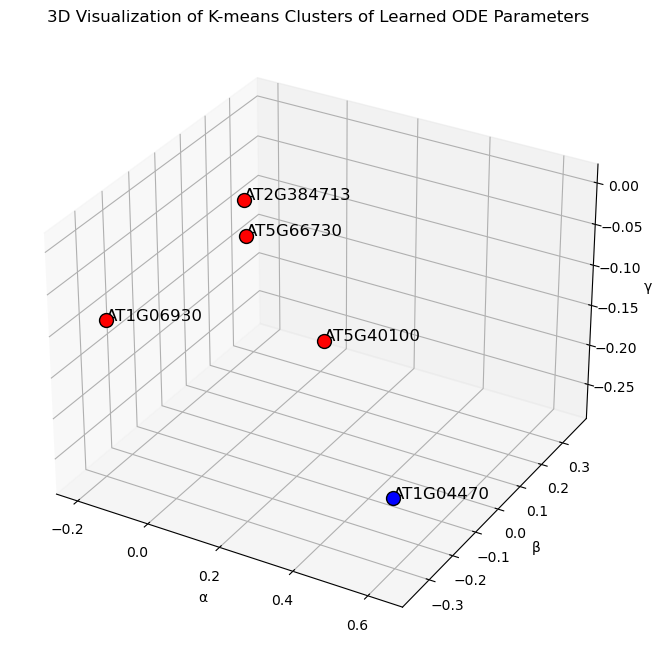


Cluster Analysis:

Cluster 0 - Genes:
AT5G40100, AT1G06930, AT5G66730, AT2G384713
Parameter Statistics:
Alpha: μ = -0.0486 ± 0.1045
Beta:  μ = 0.0015 ± 0.2667
Gamma: μ = -0.1021 ± 0.1231

Cluster 1 - Genes:
AT1G04470
Parameter Statistics:
Alpha: μ = 0.6305 ± nan
Beta:  μ = -0.3582 ± nan
Gamma: μ = -0.1867 ± nan

Parameters saved to gene_ode_parameters.csv


In [92]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

##############################################################################
# Step 1: Store and Print Learned Parameters
##############################################################################

# Assume ode_models is already trained and available from previous steps.
# Create a DataFrame to store parameters
params_df = pd.DataFrame(columns=['Gene', 'alpha', 'beta', 'gamma'])

with torch.no_grad():
    for i, gene_id in enumerate(df['Gene']):
        model = ode_models[i]
        params_df.loc[i] = [
            gene_id,
            model.alpha.item(),
            model.beta.item(),
            model.gamma.item()
        ]

print("\nLearned Parameters:")
print(params_df)

##############################################################################
# Step 2: Parameter Clustering using K-means
##############################################################################

from sklearn.preprocessing import StandardScaler

# Prepare data for clustering
X = params_df[['alpha', 'beta', 'gamma']].values

# Normalize parameters
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform K-means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add clusters to DataFrame
params_df['cluster'] = clusters

##############################################################################
# Step 3: Visualize Clusters in 3D (without PCA)
##############################################################################

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Define a list of colors to use for clusters
colors = ['r', 'b', 'g', 'm', 'y']

for idx, row in params_df.iterrows():
    ax.scatter(row['alpha'], row['beta'], row['gamma'],
               color=colors[row['cluster'] % len(colors)],
               s=100, edgecolor='k')
    ax.text(row['alpha'], row['beta'], row['gamma'], row['Gene'],
            size=12, zorder=1, color='k')

ax.set_xlabel('α')
ax.set_ylabel('β')
ax.set_zlabel('γ')
ax.set_title('3D Visualization of K-means Clusters of Learned ODE Parameters')
plt.show()

##############################################################################
# Step 4: Cluster Analysis
##############################################################################

print("\nCluster Analysis:")
for cluster_id in sorted(params_df['cluster'].unique()):
    cluster_data = params_df[params_df['cluster'] == cluster_id]
    
    print(f"\nCluster {cluster_id} - Genes:")
    print(", ".join(cluster_data['Gene'].values))
    
    print("Parameter Statistics:")
    print(f"Alpha: μ = {cluster_data['alpha'].mean():.4f} ± {cluster_data['alpha'].std():.4f}")
    print(f"Beta:  μ = {cluster_data['beta'].mean():.4f} ± {cluster_data['beta'].std():.4f}")
    print(f"Gamma: μ = {cluster_data['gamma'].mean():.4f} ± {cluster_data['gamma'].std():.4f}")

##############################################################################
# Step 5: Save Parameters to CSV
##############################################################################

params_df.to_csv('gene_ode_parameters.csv', index=False)
print("\nParameters saved to gene_ode_parameters.csv")


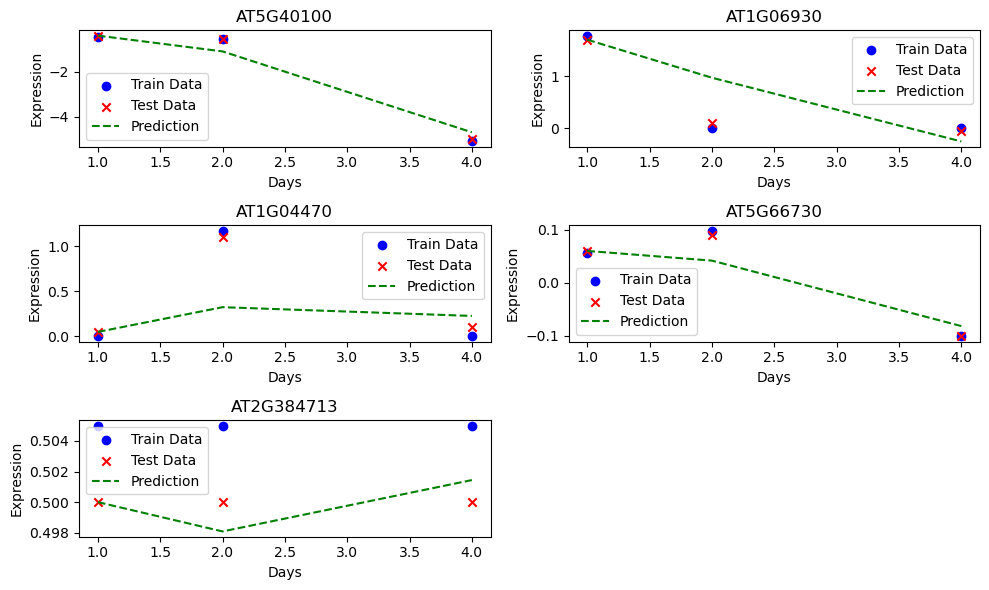

In [87]:
##############################################################################
# Step 1: Generate Synthetic Test Data
##############################################################################

def generate_test_data(original_data, noise_level=0.1):
    """
    Generate test data by adding Gaussian noise to original data
    """
    test_data = {}
    for gene, values in original_data.items():
        noisy_values = [v + np.random.normal(0, noise_level) for v in values]
        test_data[gene] = noisy_values
    return test_data

# Generate test data
test_data = {
    "AT5G40100": [-0.4, -0.55, -5.0],
    "AT1G06930": [1.7, 0.1, -0.05],
    "AT1G04470": [0.05, 1.1, 0.1],
    "AT5G66730": [0.06, 0.09, -0.1],
    "AT2G384713": [0.5, 0.5, 0.5]
}

# Convert to tensor
test_data_tensor = torch.tensor([test_data[gene] for gene in df['Gene']], dtype=torch.float32)

##############################################################################
# Step 2: Test Model on New Data
##############################################################################

def test_model(ode_models, time_points, test_data):
    predictions = []
    with torch.no_grad():
        for i, gene in enumerate(df['Gene']):
            y0 = test_data[i, 0].unsqueeze(0)
            preds = odeint(ode_models[i], y0, time_points).squeeze().numpy()
            predictions.append(preds)
    return np.array(predictions)

# Get predictions
test_predictions = test_model(ode_models, time_points_tensor, test_data_tensor)

##############################################################################
# Step 3: Plot Test Predictions
##############################################################################

plt.figure(figsize=(10, 6))
for i, gene_id in enumerate(df['Gene']):
    plt.subplot(3, 2, i+1)
    plt.scatter(time_points, gene_data[i], c='b', label='Train Data')
    plt.scatter(time_points, test_data_tensor[i], c='r', marker='x', label='Test Data')
    plt.plot(time_points, test_predictions[i], 'g--', label='Prediction')
    plt.title(gene_id)
    plt.xlabel('Days')
    plt.ylabel('Expression')
    plt.legend()
plt.tight_layout()
plt.show()


In [88]:

##############################################################################
# Step 4: Parameter Clustering
##############################################################################

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Collect parameters
params = []
for model in ode_models:
    params.append([
        model.alpha.item(),
        model.beta.item(),
        model.gamma.item()
    ])
params = np.array(params)

# Normalize parameters
scaler = StandardScaler()
scaled_params = scaler.fit_transform(params)

# Cluster using K-means
kmeans = KMeans(n_clusters=2, random_state=0).fit(scaled_params)
cluster_labels = kmeans.labels_

# PCA for visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_params)



c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


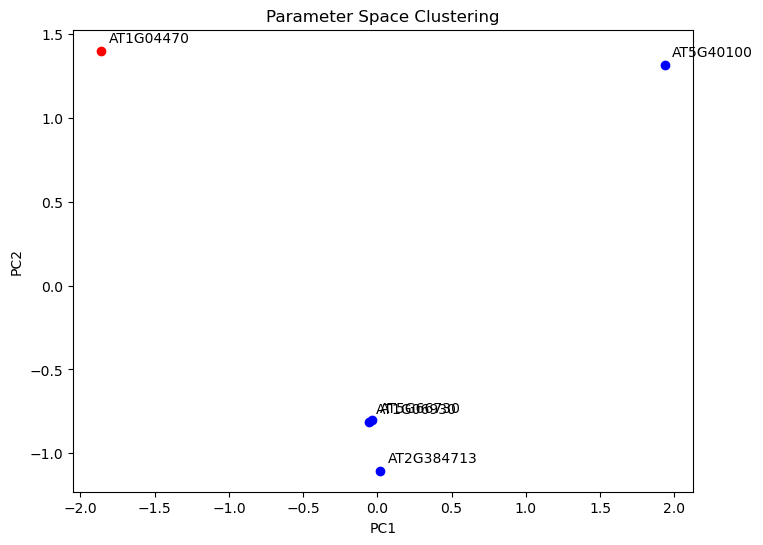


Cluster Analysis:

Cluster 0 Genes:
AT1G04470
Average Parameters:
α: 0.6305 ± 0.0000
β: -0.3582 ± 0.0000
γ: -0.1867 ± 0.0000

Cluster 1 Genes:
AT5G40100, AT1G06930, AT5G66730, AT2G384713
Average Parameters:
α: -0.0486 ± 0.0905
β: 0.0015 ± 0.2310
γ: -0.1021 ± 0.1066


In [89]:
# Plot clusters
plt.figure(figsize=(8, 6))
for i, gene in enumerate(df['Gene']):
    plt.scatter(principal_components[i, 0], principal_components[i, 1],
                c=['r', 'b'][cluster_labels[i]], label=gene)
    plt.text(principal_components[i, 0]+0.05, principal_components[i, 1]+0.05, gene)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Parameter Space Clustering')
plt.show()

##############################################################################
# Step 5: Print Cluster Analysis
##############################################################################

print("\nCluster Analysis:")
for cluster_id in np.unique(cluster_labels):
    cluster_genes = df['Gene'][cluster_labels == cluster_id]
    print(f"\nCluster {cluster_id} Genes:")
    print(", ".join(cluster_genes))
    
    cluster_params = params[cluster_labels == cluster_id]
    print(f"Average Parameters:")
    print(f"α: {cluster_params[:, 0].mean():.4f} ± {cluster_params[:, 0].std():.4f}")
    print(f"β: {cluster_params[:, 1].mean():.4f} ± {cluster_params[:, 1].std():.4f}")
    print(f"γ: {cluster_params[:, 2].mean():.4f} ± {cluster_params[:, 2].std():.4f}")

In [94]:
# Store learned parameters in a DataFrame
params = []
for i, gene_id in enumerate(df['Gene']):
    model = ode_models[i]
    params.append({
        'Gene': gene_id,
        'alpha': model.alpha.item(),
        'beta': model.beta.item(),
        'gamma': model.gamma.item()
    })
params_df = pd.DataFrame(params)

print("\nLearned Parameters:")
print(params_df)


Learned Parameters:
         Gene     alpha      beta     gamma
0   AT5G40100 -0.032625  0.362959 -0.273890
1   AT1G06930 -0.200344 -0.279882 -0.105488
2   AT1G04470  0.630494 -0.358244 -0.186680
3   AT5G66730  0.031281 -0.051666 -0.031253
4  AT2G384713  0.007093 -0.025270  0.002398


In [99]:
from sklearn.cluster import KMeans

# Number of clusters for each parameter
n_clusters = 3

# Cluster alpha values
kmeans_alpha = KMeans(n_clusters=n_clusters, random_state=42)
params_df['alpha_cluster'] = kmeans_alpha.fit_predict(params_df[['alpha']])

# Cluster beta values
kmeans_beta = KMeans(n_clusters=n_clusters, random_state=42)
params_df['beta_cluster'] = kmeans_beta.fit_predict(params_df[['beta']])

# Cluster gamma values
kmeans_gamma = KMeans(n_clusters=n_clusters, random_state=42)
params_df['gamma_cluster'] = kmeans_gamma.fit_predict(params_df[['gamma']])

print("\nClustered Parameters:")
print(params_df)


Clustered Parameters:
         Gene     alpha      beta     gamma  alpha_cluster  beta_cluster  \
0   AT5G40100 -0.032625  0.362959 -0.273890              2             1   
1   AT1G06930 -0.200344 -0.279882 -0.105488              0             0   
2   AT1G04470  0.630494 -0.358244 -0.186680              1             0   
3   AT5G66730  0.031281 -0.051666 -0.031253              2             2   
4  AT2G384713  0.007093 -0.025270  0.002398              2             2   

   gamma_cluster  
0              2  
1              0  
2              1  
3              0  
4              0  


c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


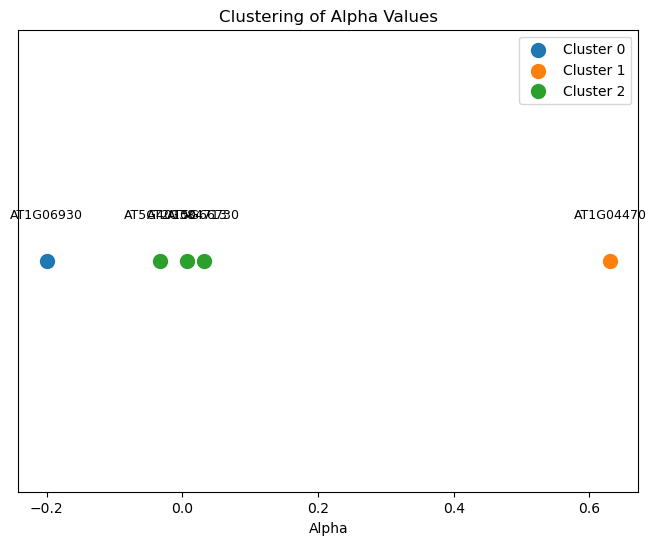

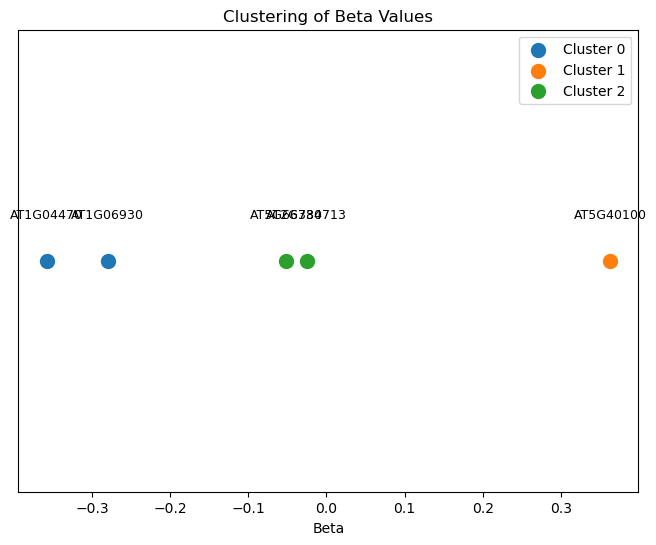

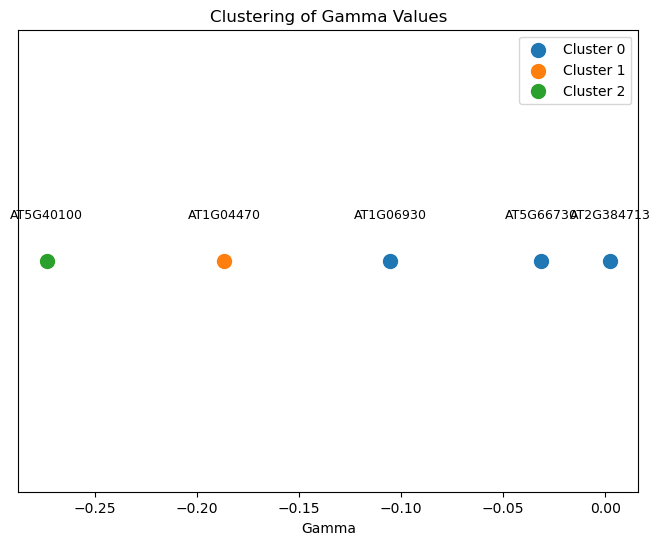

In [100]:
# Plot clusters for alpha
plt.figure(figsize=(8, 6))
for cluster in range(n_clusters):
    cluster_data = params_df[params_df['alpha_cluster'] == cluster]
    plt.scatter(cluster_data['alpha'], np.zeros_like(cluster_data['alpha']), 
                label=f'Cluster {cluster}', s=100)
    for _, row in cluster_data.iterrows():
        plt.text(row['alpha'], 0.01, row['Gene'], fontsize=9, ha='center')
plt.title('Clustering of Alpha Values')
plt.xlabel('Alpha')
plt.yticks([])
plt.legend()
plt.show()

# Plot clusters for beta
plt.figure(figsize=(8, 6))
for cluster in range(n_clusters):
    cluster_data = params_df[params_df['beta_cluster'] == cluster]
    plt.scatter(cluster_data['beta'], np.zeros_like(cluster_data['beta']), 
                label=f'Cluster {cluster}', s=100)
    for _, row in cluster_data.iterrows():
        plt.text(row['beta'], 0.01, row['Gene'], fontsize=9, ha='center')
plt.title('Clustering of Beta Values')
plt.xlabel('Beta')
plt.yticks([])
plt.legend()
plt.show()

# Plot clusters for gamma
plt.figure(figsize=(8, 6))
for cluster in range(n_clusters):
    cluster_data = params_df[params_df['gamma_cluster'] == cluster]
    plt.scatter(cluster_data['gamma'], np.zeros_like(cluster_data['gamma']), 
                label=f'Cluster {cluster}', s=100)
    for _, row in cluster_data.iterrows():
        plt.text(row['gamma'], 0.01, row['Gene'], fontsize=9, ha='center')
plt.title('Clustering of Gamma Values')
plt.xlabel('Gamma')
plt.yticks([])
plt.legend()
plt.show()

In [101]:
print("\nCluster Analysis:")

# Alpha clusters
print("\nAlpha Clusters:")
for cluster in range(n_clusters):
    cluster_genes = params_df[params_df['alpha_cluster'] == cluster]['Gene'].values
    print(f"Cluster {cluster}: {', '.join(cluster_genes)}")

# Beta clusters
print("\nBeta Clusters:")
for cluster in range(n_clusters):
    cluster_genes = params_df[params_df['beta_cluster'] == cluster]['Gene'].values
    print(f"Cluster {cluster}: {', '.join(cluster_genes)}")

# Gamma clusters
print("\nGamma Clusters:")
for cluster in range(n_clusters):
    cluster_genes = params_df[params_df['gamma_cluster'] == cluster]['Gene'].values
    print(f"Cluster {cluster}: {', '.join(cluster_genes)}")


Cluster Analysis:

Alpha Clusters:
Cluster 0: AT1G06930
Cluster 1: AT1G04470
Cluster 2: AT5G40100, AT5G66730, AT2G384713

Beta Clusters:
Cluster 0: AT1G06930, AT1G04470
Cluster 1: AT5G40100
Cluster 2: AT5G66730, AT2G384713

Gamma Clusters:
Cluster 0: AT1G06930, AT5G66730, AT2G384713
Cluster 1: AT1G04470
Cluster 2: AT5G40100


In [102]:
params_df.to_csv('clustered_parameters.csv', index=False)
print("\nClustered parameters saved to 'clustered_parameters.csv'.")


Clustered parameters saved to 'clustered_parameters.csv'.


------------------


Synthetic Test Data:
[[ 0.24745489  1.51359377 14.49141169]
 [ 0.73297925  1.86342949 11.01077091]
 [ 0.25738741  1.31812021  3.7375869 ]
 [-0.11702363 -1.38847711 -1.91769046]
 [-0.34103048  0.77714908  1.98622717]]
True underlying parameters (α, β, γ) for test genes:
[[ 0.23712731  0.89869091  0.29388957]
 [-0.56955838  0.93130798  0.28143605]
 [ 0.87294191  0.15508365  0.0086308 ]
 [-0.71528494 -0.22604569 -0.08405449]
 [ 0.88857266 -0.75714478  0.27578002]]


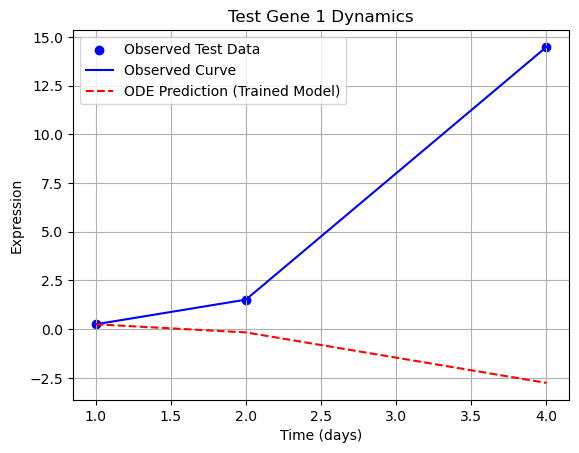

Learned ODE for Test Gene 1 (using Trained Model 1):
  dy/dt = -0.0326 + 0.3630 * y(t) + -0.2739 * t



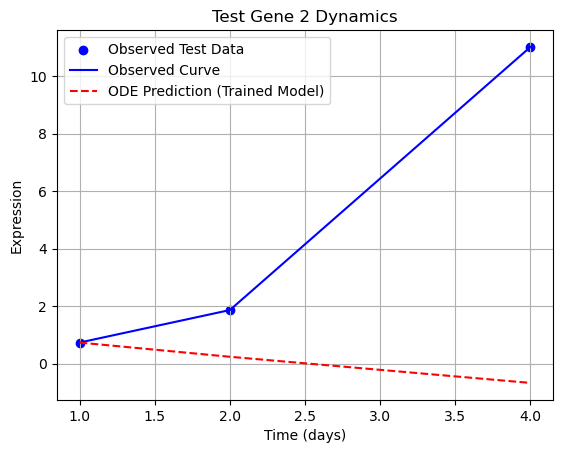

Learned ODE for Test Gene 2 (using Trained Model 2):
  dy/dt = -0.2003 + -0.2799 * y(t) + -0.1055 * t



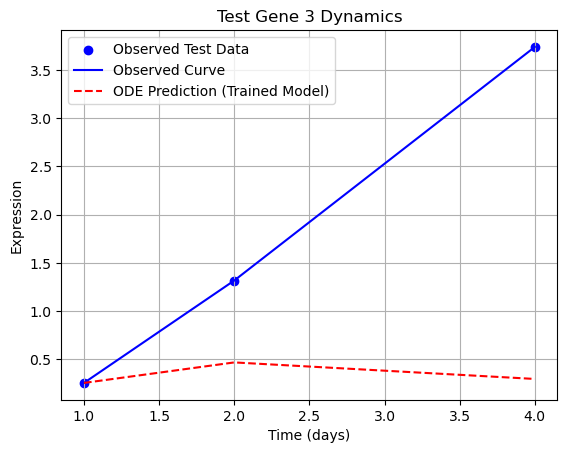

Learned ODE for Test Gene 3 (using Trained Model 3):
  dy/dt = 0.6305 + -0.3582 * y(t) + -0.1867 * t



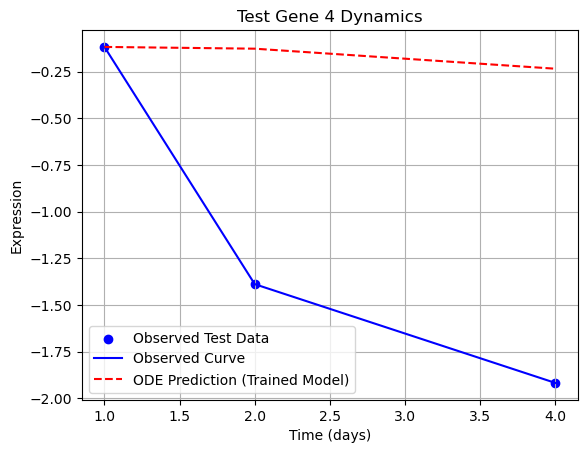

Learned ODE for Test Gene 4 (using Trained Model 4):
  dy/dt = 0.0313 + -0.0517 * y(t) + -0.0313 * t



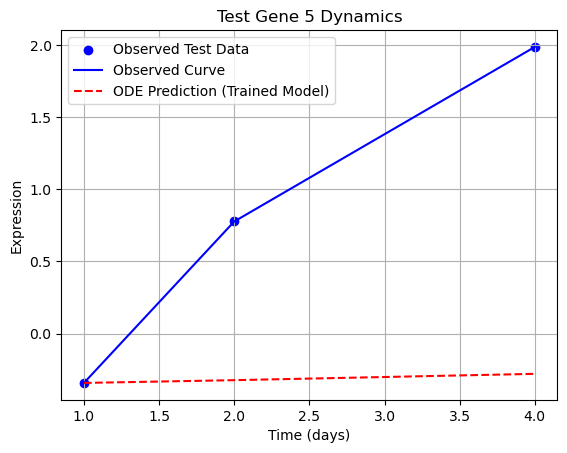

Learned ODE for Test Gene 5 (using Trained Model 5):
  dy/dt = 0.0071 + -0.0253 * y(t) + 0.0024 * t

Cluster assignments for trained ODE parameters (used for testing):
[1 1 0 1 1]


c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


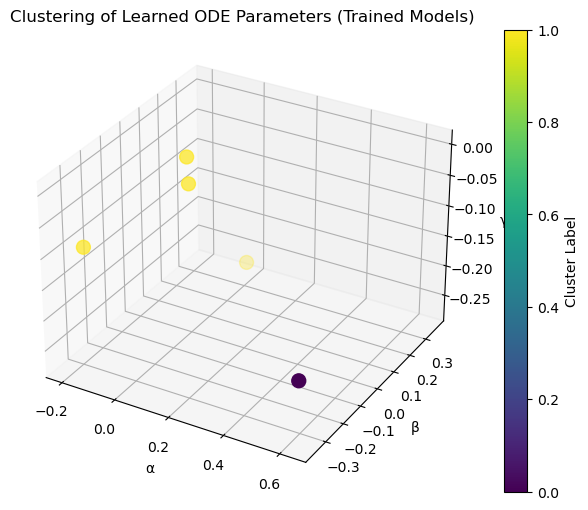

In [93]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from scipy.integrate import odeint as scipy_odeint

# ##############################################################################
# # 1. Data Setup (Training Data)
# ##############################################################################

# data = {
#     "Gene": ["AT5G40100", "AT1G06930", "AT1G04470", "AT5G66730", "AT2G384713"],
#     "Hpa-NO_1d":  [-0.44796,    1.77836,     0.0,         0.05537,    0.505000],
#     "Hpa-NO_2d":  [-0.56015,    0.0,         1.17515,     0.09843,    0.505000],
#     "Hpa-NO_4d":  [-5.09196,    0.0,         0.0,        -0.10176,    0.505000],
# }
# df = pd.DataFrame(data)
# print("Original Training Data:")
# print(df)

# # Time points (in days)
# time_points = np.array([1.0, 2.0, 4.0], dtype=np.float32)  # Day1, Day2, Day4

# # Extract gene expression data (each row is one gene)
# gene_data = df[["Hpa-NO_1d", "Hpa-NO_2d", "Hpa-NO_4d"]].values

# # Convert to PyTorch tensors
# time_points_tensor = torch.tensor(time_points, dtype=torch.float32, requires_grad=True)
# gene_data_tensor = torch.tensor(gene_data, dtype=torch.float32)

# ##############################################################################
# # 2. Define the Parametric ODE Model for Each Gene: dy/dt = α + β*y(t) + γ*t
# ##############################################################################

# class GeneParametricODE(nn.Module):
#     def __init__(self):
#         super(GeneParametricODE, self).__init__()
#         # Learnable parameters: α, β, and γ
#         self.alpha = nn.Parameter(torch.tensor(0.1))
#         self.beta  = nn.Parameter(torch.tensor(0.1))
#         self.gamma = nn.Parameter(torch.tensor(0.1))
    
#     def forward(self, t, y):
#         # ODE: dy/dt = α + β*y(t) + γ*t
#         return self.alpha + self.beta * y + self.gamma * t

# # Create one ODE model per gene for training data
# num_genes = gene_data_tensor.shape[0]
# ode_models = nn.ModuleList([GeneParametricODE() for _ in range(num_genes)])

# ##############################################################################
# # 3. Inverse PINN Loss Function (Data Loss + Physics Loss)
# ##############################################################################

# def inverse_pinn_loss(ode_models, time_points, gene_data, lambda_physics=0.1):
#     total_data_loss = 0.0
#     total_physics_loss = 0.0
#     n_genes = gene_data.shape[0]
    
#     for i in range(n_genes):
#         # Observed expression for gene i (shape: (num_time_points,))
#         y_observed = gene_data[i]
#         # Use the first time point as the initial condition
#         y0 = y_observed[0].unsqueeze(0)  # shape: (1,)
        
#         # Solve the ODE for gene i over the time points
#         preds = odeint(ode_models[i], y0, time_points).squeeze()  # shape: (num_time_points,)
        
#         # Data loss: Mean squared error between predictions and observed values
#         data_loss = torch.mean((preds - y_observed)**2)
        
#         # Physics loss: Enforce that the derivative from autograd matches the ODE output
#         dy_dt_pred = torch.autograd.grad(
#             outputs=preds,
#             inputs=time_points,
#             grad_outputs=torch.ones_like(preds),
#             create_graph=True,
#             retain_graph=True
#         )[0]
        
#         dy_dt_ode = []
#         for t_val, p_val in zip(time_points, preds):
#             deriv = ode_models[i](t_val, p_val.unsqueeze(0))
#             dy_dt_ode.append(deriv.squeeze())
#         dy_dt_ode = torch.stack(dy_dt_ode)
        
#         physics_loss = torch.mean((dy_dt_pred - dy_dt_ode)**2)
        
#         total_data_loss += data_loss
#         total_physics_loss += physics_loss
    
#     avg_data_loss = total_data_loss / n_genes
#     avg_physics_loss = total_physics_loss / n_genes
#     total_loss = avg_data_loss + lambda_physics * avg_physics_loss
#     return total_loss, avg_data_loss, avg_physics_loss

# ##############################################################################
# # 4. Training Loop on Training Data
# ##############################################################################

# optimizer = optim.Adam(ode_models.parameters(), lr=0.01)
# epochs = 500

# for epoch in range(epochs):
#     optimizer.zero_grad()
#     total_loss, data_loss, physics_loss = inverse_pinn_loss(ode_models, time_points_tensor, gene_data_tensor, lambda_physics=0.1)
#     total_loss.backward()
#     optimizer.step()
    
#     if epoch % 100 == 0:
#         print(f"Training Epoch {epoch:4d} | Total Loss: {total_loss.item():.4f} | Data Loss: {data_loss.item():.4f} | Physics Loss: {physics_loss.item():.4f}")

##############################################################################
# 5. Generate Synthetic Test Data (Do NOT train on these; only use for testing)
##############################################################################
# Generate synthetic test data using a similar ODE model but with new (synthetic) parameters.
def generate_synthetic_test_data(num_genes, time_points, noise_std=0.1):
    test_data = []
    true_params = []
    for i in range(num_genes):
        # Randomly sample parameters from uniform distributions
        alpha = np.random.uniform(-1, 1)
        beta = np.random.uniform(-1, 1)
        gamma = np.random.uniform(-0.5, 0.5)
        true_params.append([alpha, beta, gamma])
        
        # Choose an initial condition y0 randomly
        y0 = np.random.uniform(-1, 1)
        
        # Define the ODE function for simulation
        def ode_func(y, t, alpha=alpha, beta=beta, gamma=gamma):
            return alpha + beta * y + gamma * t
        
        # Simulate the ODE using SciPy's odeint
        y_sim = scipy_odeint(ode_func, y0, time_points).flatten()
        # Add noise
        y_sim_noisy = y_sim + np.random.normal(0, noise_std, size=y_sim.shape)
        test_data.append(y_sim_noisy)
    return np.array(test_data), np.array(true_params)

num_test_genes = 5
test_time_points = time_points  # same time points for test data
test_data_np, true_test_params = generate_synthetic_test_data(num_test_genes, test_time_points, noise_std=0.2)
print("\nSynthetic Test Data:")
print(test_data_np)
print("True underlying parameters (α, β, γ) for test genes:")
print(true_test_params)

# Convert test data to torch tensor
test_data_tensor = torch.tensor(test_data_np, dtype=torch.float32)

##############################################################################
# 6. Testing: Use Trained Models on Test Data (Do NOT update/train the models)
##############################################################################
# For simplicity, we pair test genes with training models by index
# (using the first min(num_training_genes, num_test_genes) pairs)
num_pairs = min(num_genes, num_test_genes)
learned_params = []  # to collect parameters for clustering

with torch.no_grad():
    for i in range(num_pairs):
        y0_test = test_data_tensor[i, 0].unsqueeze(0)  # use the test gene's Day1 as initial condition
        preds = odeint(ode_models[i], y0_test, time_points_tensor).squeeze().cpu().numpy()
        
        # Plot observed test data vs. prediction from the trained model
        plt.figure()
        plt.scatter(time_points, test_data_np[i], c='b', label="Observed Test Data")
        plt.plot(time_points, test_data_np[i], 'b-', label="Observed Curve")
        plt.plot(time_points, preds, 'r--', label="ODE Prediction (Trained Model)")
        plt.title(f"Test Gene {i+1} Dynamics")
        plt.xlabel("Time (days)")
        plt.ylabel("Expression")
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # Extract and print learned parameters from the corresponding trained model
        model_i = ode_models[i]
        alpha = model_i.alpha.item()
        beta = model_i.beta.item()
        gamma = model_i.gamma.item()
        learned_params.append([alpha, beta, gamma])
        print(f"Learned ODE for Test Gene {i+1} (using Trained Model {i+1}):")
        print(f"  dy/dt = {alpha:.4f} + {beta:.4f} * y(t) + {gamma:.4f} * t\n")

learned_params = np.array(learned_params)

##############################################################################
# 7. Cluster the Learned ODE Parameters from Trained Models
##############################################################################
# Cluster the parameter vectors [α, β, γ] from the trained models used for testing.
k = 2  # choose number of clusters (e.g., 2)
kmeans = KMeans(n_clusters=k, random_state=0).fit(learned_params)
cluster_labels = kmeans.labels_
print("Cluster assignments for trained ODE parameters (used for testing):")
print(cluster_labels)

# 3D Scatter Plot of the Clustered Parameters
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(learned_params[:, 0], learned_params[:, 1], learned_params[:, 2],
                     c=cluster_labels, cmap='viridis', s=100)
ax.set_xlabel("α")
ax.set_ylabel("β")
ax.set_zlabel("γ")
ax.set_title("Clustering of Learned ODE Parameters (Trained Models)")
plt.colorbar(scatter, ax=ax, label='Cluster Label')
plt.show()


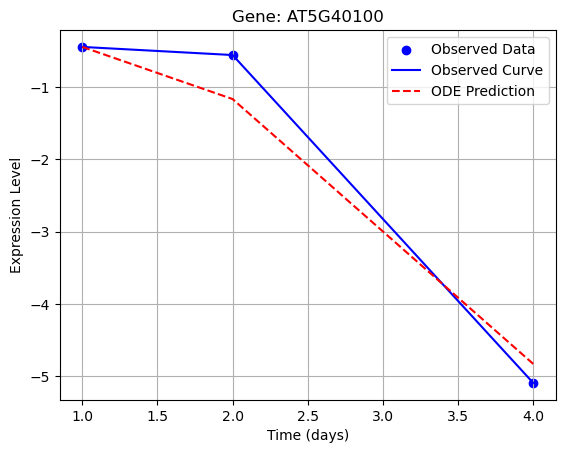

Learned ODE for Gene AT5G40100:
  dy/dt = -0.0326 + 0.3630 * y + -0.2739 * t
Formatted ODE Equation: dy/dt = -0.0326 + 0.3630 * y(t) + -0.2739 * t



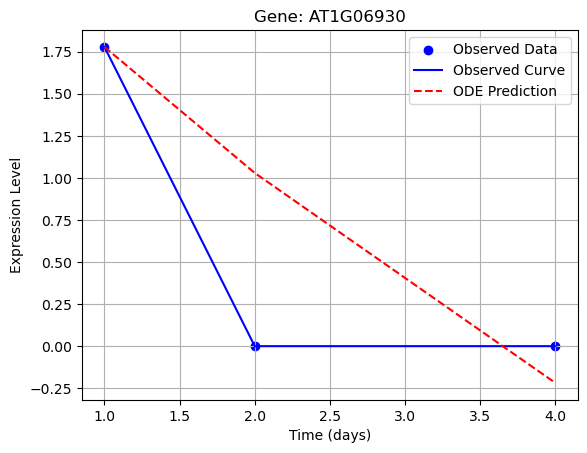

Learned ODE for Gene AT1G06930:
  dy/dt = -0.2003 + -0.2799 * y + -0.1055 * t
Formatted ODE Equation: dy/dt = -0.2003 + -0.2799 * y(t) + -0.1055 * t



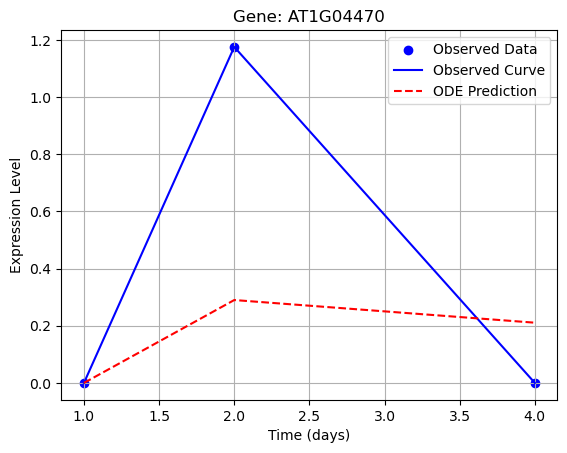

Learned ODE for Gene AT1G04470:
  dy/dt = 0.6305 + -0.3582 * y + -0.1867 * t
Formatted ODE Equation: dy/dt = 0.6305 + -0.3582 * y(t) + -0.1867 * t



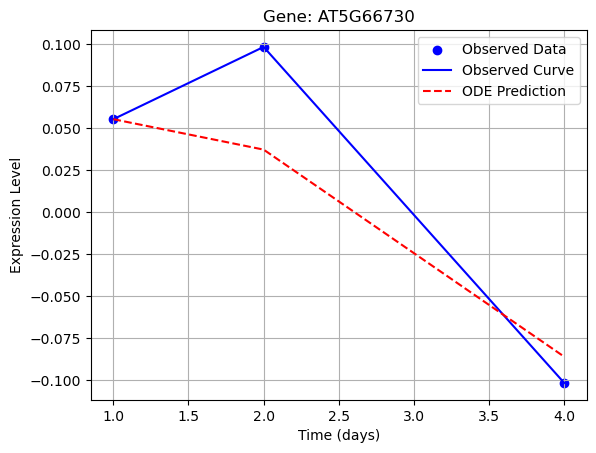

Learned ODE for Gene AT5G66730:
  dy/dt = 0.0313 + -0.0517 * y + -0.0313 * t
Formatted ODE Equation: dy/dt = 0.0313 + -0.0517 * y(t) + -0.0313 * t



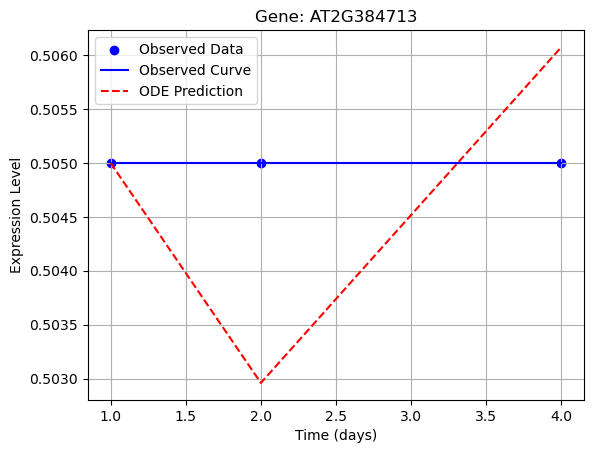

Learned ODE for Gene AT2G384713:
  dy/dt = 0.0071 + -0.0253 * y + 0.0024 * t
Formatted ODE Equation: dy/dt = 0.0071 + -0.0253 * y(t) + 0.0024 * t


Learned Parameters:
         Gene     alpha      beta     gamma
0   AT5G40100 -0.032625  0.362959 -0.273890
1   AT1G06930 -0.200344 -0.279882 -0.105488
2   AT1G04470  0.630494 -0.358244 -0.186680
3   AT5G66730  0.031281 -0.051666 -0.031253
4  AT2G384713  0.007093 -0.025270  0.002398

Parameters with Individual Clusters:
         Gene     alpha      beta     gamma  alpha_cluster  beta_cluster  \
0   AT5G40100 -0.032625  0.362959 -0.273890              2             1   
1   AT1G06930 -0.200344 -0.279882 -0.105488              0             0   
2   AT1G04470  0.630494 -0.358244 -0.186680              1             0   
3   AT5G66730  0.031281 -0.051666 -0.031253              2             2   
4  AT2G384713  0.007093 -0.025270  0.002398              2             2   

   gamma_cluster  
0              2  
1              0  
2              1

c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


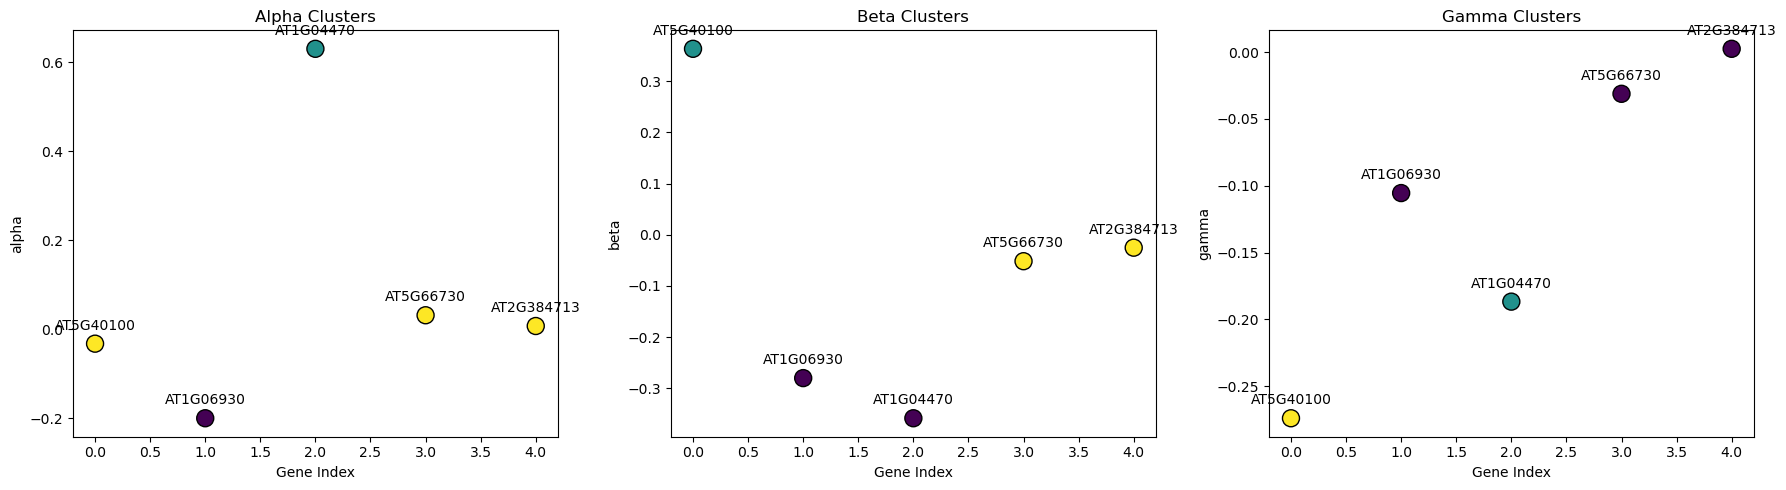


Cluster Analysis for Alpha:
Alpha Cluster 0: AT1G06930
Alpha Cluster 1: AT1G04470
Alpha Cluster 2: AT5G40100, AT5G66730, AT2G384713

Cluster Analysis for Beta:
Beta Cluster 0: AT1G06930, AT1G04470
Beta Cluster 1: AT5G40100
Beta Cluster 2: AT5G66730, AT2G384713

Cluster Analysis for Gamma:
Gamma Cluster 0: AT1G06930, AT5G66730, AT2G384713
Gamma Cluster 1: AT1G04470
Gamma Cluster 2: AT5G40100


In [104]:
##############################################################################
# Plotting Predictions and Printing Learned ODE Parameters
##############################################################################

with torch.no_grad():
    for i, gene_id in enumerate(df['Gene']):
        # Use the Day1 value as the initial condition for each gene
        y0 = gene_data_tensor[i, 0].unsqueeze(0)  # shape: (1,)
        preds = odeint(ode_models[i], y0, time_points_tensor).squeeze().numpy()
        
        # Plot observed data vs. ODE predictions
        plt.figure()
        plt.scatter(time_points, gene_data[i], c='b', label="Observed Data")
        plt.plot(time_points, gene_data[i], 'b-', label="Observed Curve")
        plt.plot(time_points, preds, 'r--', label="ODE Prediction")
        plt.title(f"Gene: {gene_id}")
        plt.xlabel("Time (days)")
        plt.ylabel("Expression Level")
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # Print learned parameters for the gene
        model = ode_models[i]
        alpha = model.alpha.item()
        beta = model.beta.item()
        gamma = model.gamma.item()
        print(f"Learned ODE for Gene {gene_id}:")
        print(f"  dy/dt = {alpha:.4f} + {beta:.4f} * y + {gamma:.4f} * t")
        print(f"Formatted ODE Equation: dy/dt = {alpha:.4f} + {beta:.4f} * y(t) + {gamma:.4f} * t\n")

##############################################################################
# Clustering Learned Parameters Separately for alpha, beta, and gamma
##############################################################################

# Create a DataFrame to store parameters
params_df = pd.DataFrame(columns=['Gene', 'alpha', 'beta', 'gamma'])

with torch.no_grad():
    for i, gene_id in enumerate(df['Gene']):
        model = ode_models[i]
        params_df.loc[i] = [
            gene_id,
            model.alpha.item(),
            model.beta.item(),
            model.gamma.item()
        ]

print("\nLearned Parameters:")
print(params_df)

# Cluster each parameter individually
from sklearn.cluster import KMeans

# Cluster for alpha
alphas = params_df['alpha'].values.reshape(-1, 1)
kmeans_alpha = KMeans(n_clusters=3, random_state=42).fit(alphas)
params_df['alpha_cluster'] = kmeans_alpha.labels_

# Cluster for beta
betas = params_df['beta'].values.reshape(-1, 1)
kmeans_beta = KMeans(n_clusters=3, random_state=42).fit(betas)
params_df['beta_cluster'] = kmeans_beta.labels_

# Cluster for gamma
gammas = params_df['gamma'].values.reshape(-1, 1)
kmeans_gamma = KMeans(n_clusters=3, random_state=42).fit(gammas)
params_df['gamma_cluster'] = kmeans_gamma.labels_

print("\nParameters with Individual Clusters:")
print(params_df)

##############################################################################
# Visualize Clusters for Each Parameter
##############################################################################

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# For alpha: simple scatter of gene index vs. alpha, colored by cluster
axs[0].scatter(range(len(alphas)), alphas, c=params_df['alpha_cluster'], cmap='viridis', s=150, edgecolor='k')
for i, txt in enumerate(params_df['Gene']):
    axs[0].annotate(txt, (i, alphas[i]), textcoords="offset points", xytext=(0,10), ha='center')
axs[0].set_title('Alpha Clusters')
axs[0].set_xlabel('Gene Index')
axs[0].set_ylabel('alpha')

# For beta
axs[1].scatter(range(len(betas)), betas, c=params_df['beta_cluster'], cmap='viridis', s=150, edgecolor='k')
for i, txt in enumerate(params_df['Gene']):
    axs[1].annotate(txt, (i, betas[i]), textcoords="offset points", xytext=(0,10), ha='center')
axs[1].set_title('Beta Clusters')
axs[1].set_xlabel('Gene Index')
axs[1].set_ylabel('beta')

# For gamma
axs[2].scatter(range(len(gammas)), gammas, c=params_df['gamma_cluster'], cmap='viridis', s=150, edgecolor='k')
for i, txt in enumerate(params_df['Gene']):
    axs[2].annotate(txt, (i, gammas[i]), textcoords="offset points", xytext=(0,10), ha='center')
axs[2].set_title('Gamma Clusters')
axs[2].set_xlabel('Gene Index')
axs[2].set_ylabel('gamma')

plt.tight_layout()
plt.show()

##############################################################################
# Cluster Analysis for Each Parameter
##############################################################################

print("\nCluster Analysis for Alpha:")
for cluster in sorted(params_df['alpha_cluster'].unique()):
    group = params_df[params_df['alpha_cluster'] == cluster]
    print(f"Alpha Cluster {cluster}: {', '.join(group['Gene'])}")

print("\nCluster Analysis for Beta:")
for cluster in sorted(params_df['beta_cluster'].unique()):
    group = params_df[params_df['beta_cluster'] == cluster]
    print(f"Beta Cluster {cluster}: {', '.join(group['Gene'])}")

print("\nCluster Analysis for Gamma:")
for cluster in sorted(params_df['gamma_cluster'].unique()):
    group = params_df[params_df['gamma_cluster'] == cluster]
    print(f"Gamma Cluster {cluster}: {', '.join(group['Gene'])}")


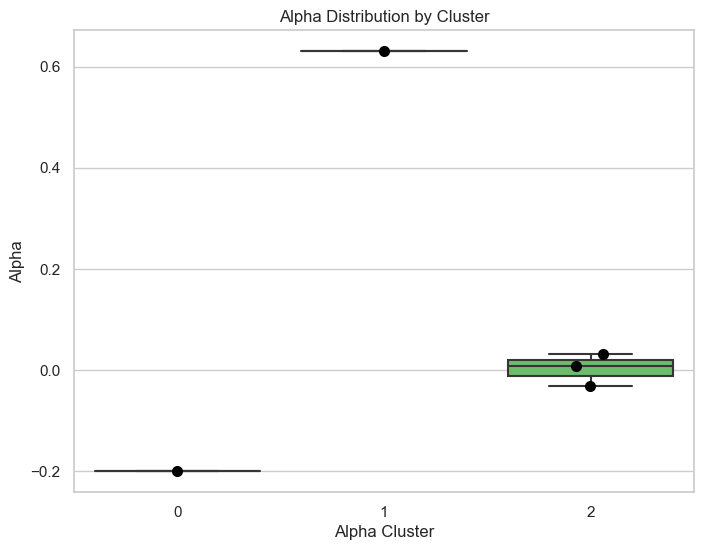

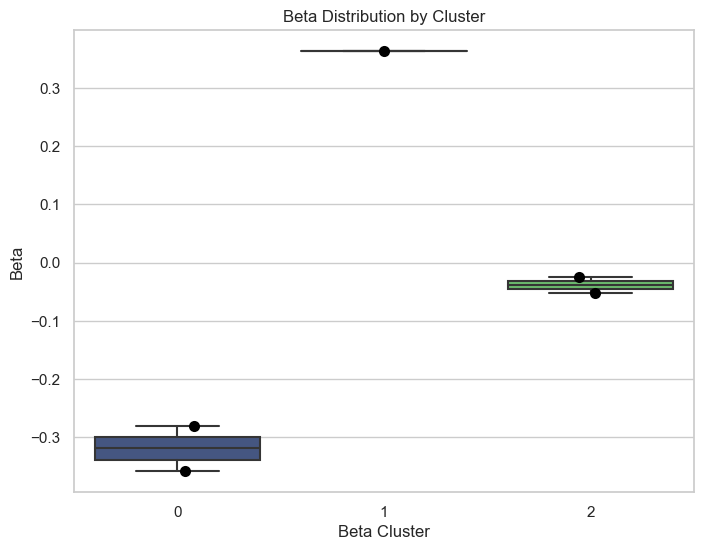

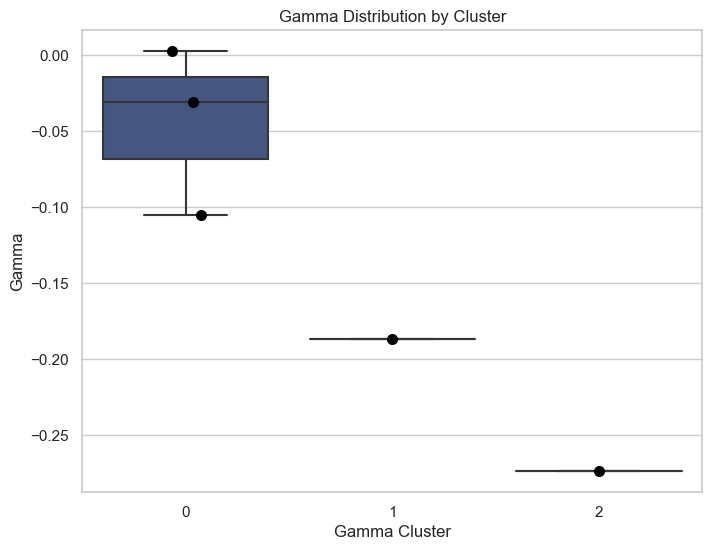

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# Plot for alpha
plt.figure(figsize=(8, 6))
sns.boxplot(x='alpha_cluster', y='alpha', data=params_df, palette='viridis')
sns.stripplot(x='alpha_cluster', y='alpha', data=params_df, color='black', size=8, jitter=True)
plt.title('Alpha Distribution by Cluster')
plt.xlabel('Alpha Cluster')
plt.ylabel('Alpha')
plt.show()

# Plot for beta
plt.figure(figsize=(8, 6))
sns.boxplot(x='beta_cluster', y='beta', data=params_df, palette='viridis')
sns.stripplot(x='beta_cluster', y='beta', data=params_df, color='black', size=8, jitter=True)
plt.title('Beta Distribution by Cluster')
plt.xlabel('Beta Cluster')
plt.ylabel('Beta')
plt.show()

# Plot for gamma
plt.figure(figsize=(8, 6))
sns.boxplot(x='gamma_cluster', y='gamma', data=params_df, palette='viridis')
sns.stripplot(x='gamma_cluster', y='gamma', data=params_df, color='black', size=8, jitter=True)
plt.title('Gamma Distribution by Cluster')
plt.xlabel('Gamma Cluster')
plt.ylabel('Gamma')
plt.show()


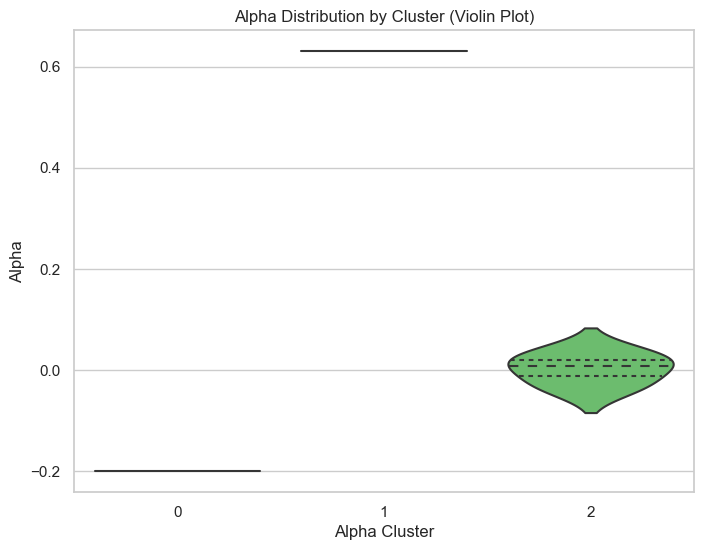

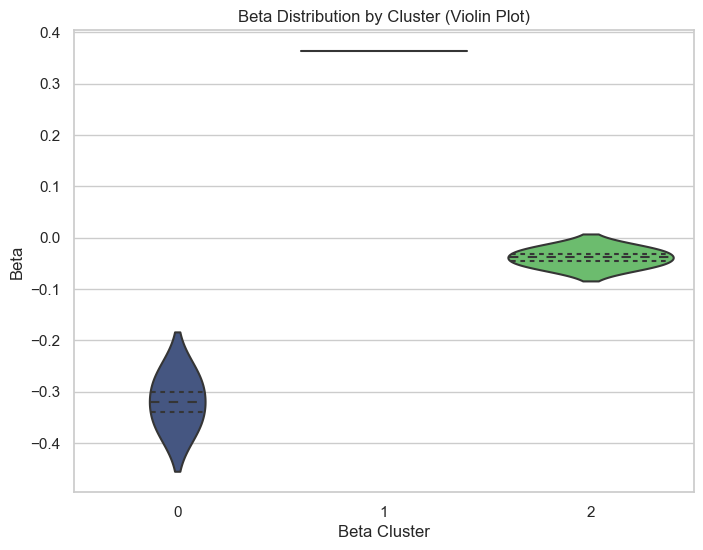

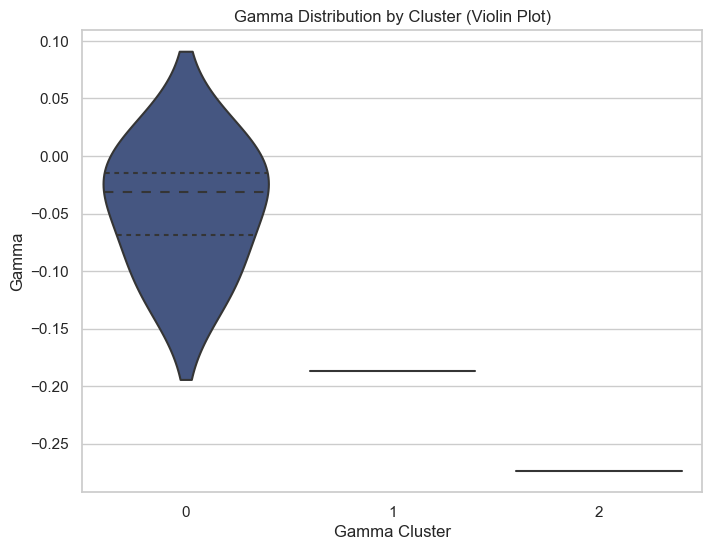

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# Violin plot for alpha
plt.figure(figsize=(8, 6))
sns.violinplot(x='alpha_cluster', y='alpha', data=params_df, palette='viridis', inner="quartile")
plt.title('Alpha Distribution by Cluster (Violin Plot)')
plt.xlabel('Alpha Cluster')
plt.ylabel('Alpha')
plt.show()

# Violin plot for beta
plt.figure(figsize=(8, 6))
sns.violinplot(x='beta_cluster', y='beta', data=params_df, palette='viridis', inner="quartile")
plt.title('Beta Distribution by Cluster (Violin Plot)')
plt.xlabel('Beta Cluster')
plt.ylabel('Beta')
plt.show()

# Violin plot for gamma
plt.figure(figsize=(8, 6))
sns.violinplot(x='gamma_cluster', y='gamma', data=params_df, palette='viridis', inner="quartile")
plt.title('Gamma Distribution by Cluster (Violin Plot)')
plt.xlabel('Gamma Cluster')
plt.ylabel('Gamma')
plt.show()


# Neural ode +Inverse Pinn

## ODE: dy/dt = α + β * y(t) * γ * t


Original Data:
         Gene  Hpa-NO_1d  Hpa-NO_2d  Hpa-NO_4d
0   AT5G40100   -0.44796   -0.56015   -5.09196
1   AT1G06930    1.77836    0.00000    0.00000
2   AT1G04470    0.00000    1.17515    0.00000
3   AT5G66730    0.05537    0.09843   -0.10176
4  AT2G384713    0.50500    0.50500    0.50500
Epoch    0 | Total Loss: 2.3039 | Data Loss: 2.3004 | Physics Loss: 0.0345
Epoch  100 | Total Loss: 0.2641 | Data Loss: 0.1909 | Physics Loss: 0.7321
Epoch  200 | Total Loss: 0.2070 | Data Loss: 0.1250 | Physics Loss: 0.8199
Epoch  300 | Total Loss: 0.1809 | Data Loss: 0.1198 | Physics Loss: 0.6107
Epoch  400 | Total Loss: 0.1579 | Data Loss: 0.1178 | Physics Loss: 0.4014


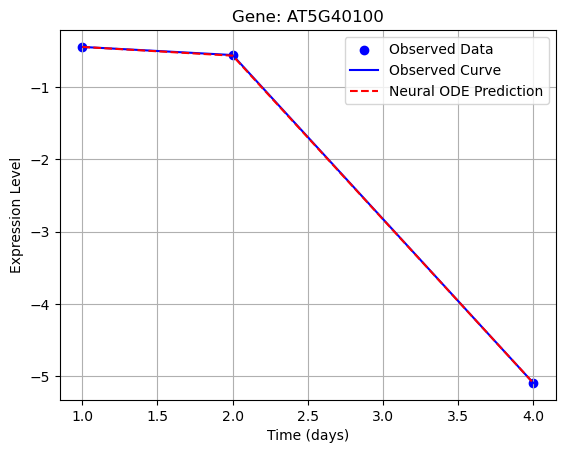

Learned ODE for Gene AT5G40100:
  dy/dt = 0.1877 + 0.6471 * y + 0.6471 * t
Formatted ODE Equation: dy/dt = 0.1877 + 0.6471 * y(t) * 0.6471 * t



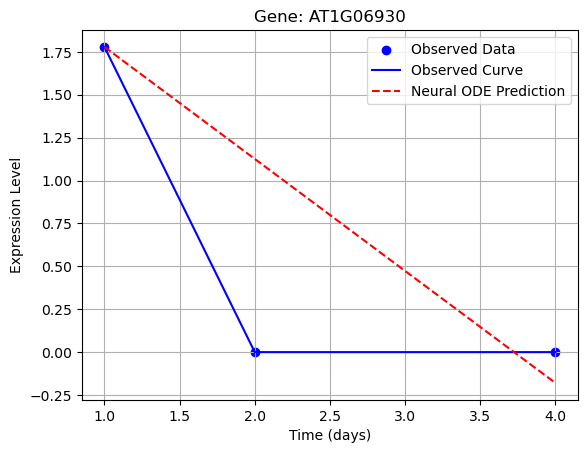

Learned ODE for Gene AT1G06930:
  dy/dt = -0.6526 + 0.0000 * y + -0.0000 * t
Formatted ODE Equation: dy/dt = -0.6526 + 0.0000 * y(t) * -0.0000 * t



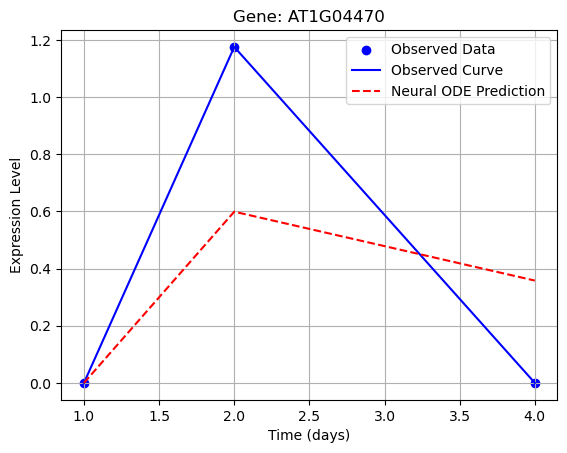

Learned ODE for Gene AT1G04470:
  dy/dt = 1.1645 + 0.9428 * y + -0.9427 * t
Formatted ODE Equation: dy/dt = 1.1645 + 0.9428 * y(t) * -0.9427 * t



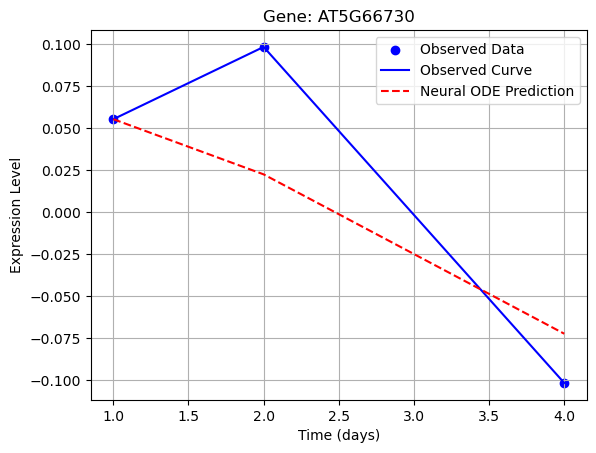

Learned ODE for Gene AT5G66730:
  dy/dt = -0.0392 + -0.3379 * y + -0.3379 * t
Formatted ODE Equation: dy/dt = -0.0392 + -0.3379 * y(t) * -0.3379 * t



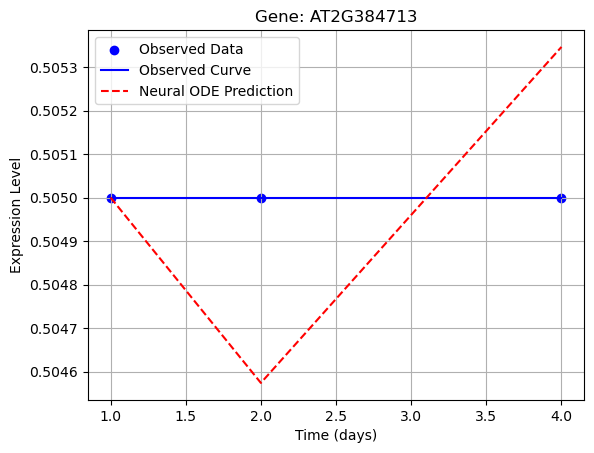

Learned ODE for Gene AT2G384713:
  dy/dt = -0.0012 + -0.0327 * y + -0.0327 * t
Formatted ODE Equation: dy/dt = -0.0012 + -0.0327 * y(t) * -0.0327 * t



In [16]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt

##############################################################################
# Data Setup (Row-wise: Each row is a gene; columns are Day1, Day2, Day4)
##############################################################################

# Example dataset (here using gene names and expression values)
# data = {
#     "Gene": ["AT5G40100", "AT1G06930", "AT1G04470", "AT5G66730"],
#     "Hpa-NO_1d": [-0.44796, 1.77836, 0.0, 0.05537],
#     "Hpa-NO_2d": [-0.56015, 0.0, 1.17515, 0.09843],
#     "Hpa-NO_4d": [-5.09196, 0.0, 0.0, -0.10176],
# }


data = {
    "Gene": ["AT5G40100", "AT1G06930", "AT1G04470", "AT5G66730", "AT2G384713"],
    "Hpa-NO_1d":  [-0.44796,    1.77836,     0.0,         0.05537,    0.505000   ],
    "Hpa-NO_2d":  [-0.56015,    0.0,         1.17515,     0.09843,  0.505000   ],
    "Hpa-NO_4d":  [-5.09196,    0.0,         0.0,        -0.10176,  0.505000   ],
}


df = pd.DataFrame(data)
print("Original Data:")
print(df)

# Time points (in days)
time_points = np.array([1.0, 2.0, 4.0], dtype=np.float32)  # Day1, Day2, Day4

# Extract gene expression data (each row is one gene)
gene_data = df[["Hpa-NO_1d", "Hpa-NO_2d", "Hpa-NO_4d"]].values

# Convert to PyTorch tensors
time_points_tensor = torch.tensor(time_points, dtype=torch.float32, requires_grad=True)
gene_data_tensor = torch.tensor(gene_data, dtype=torch.float32)

##############################################################################
# Parametric ODE Model for Each Gene: dy/dt = α + β * y(t) + γ * t
##############################################################################

class GeneParametricODE(nn.Module):
    def __init__(self):
        super(GeneParametricODE, self).__init__()
        # Learnable parameters: α, β, and γ
        self.alpha = nn.Parameter(torch.tensor(0.1))
        self.beta = nn.Parameter(torch.tensor(0.1))
        self.gamma = nn.Parameter(torch.tensor(0.1))
    
    def forward(self, t, y):
        # ODE: dy/dt = α + β * y(t) * γ * t
        return self.alpha + self.beta * y * self.gamma * t

# Create one ODE model per gene
num_genes = gene_data_tensor.shape[0]
ode_models = nn.ModuleList([GeneParametricODE() for _ in range(num_genes)])

##############################################################################
# Inverse PINN Loss Function (Data Loss + Physics Loss)
##############################################################################

def inverse_pinn_loss(ode_models, time_points, gene_data, lambda_physics=0.1):
    total_data_loss = 0.0
    total_physics_loss = 0.0
    n_genes = gene_data.shape[0]
    
    for i in range(n_genes):
        # Observed expression for gene i (shape: (num_time_points,))
        y_observed = gene_data[i]
        # Use the first time point as the initial condition
        y0 = y_observed[0].unsqueeze(0)  # shape: (1,)
        
        # Solve the ODE for gene i over the time points
        preds = odeint(ode_models[i], y0, time_points).squeeze()  # shape: (num_time_points,)
        
        # Data loss: Mean squared error between predictions and observed values
        data_loss = torch.mean((preds - y_observed)**2)
        
        # Physics loss: Enforce that the derivative from autograd matches the ODE output
        dy_dt_pred = torch.autograd.grad(
            outputs=preds,
            inputs=time_points,
            grad_outputs=torch.ones_like(preds),
            create_graph=True,
            retain_graph=True
        )[0]
        
        dy_dt_ode = []
        for t_val, p_val in zip(time_points, preds):
            deriv = ode_models[i](t_val, p_val.unsqueeze(0))
            dy_dt_ode.append(deriv.squeeze())
        dy_dt_ode = torch.stack(dy_dt_ode)
        
        physics_loss = torch.mean((dy_dt_pred - dy_dt_ode)**2)
        
        total_data_loss += data_loss
        total_physics_loss += physics_loss
    
    avg_data_loss = total_data_loss / n_genes
    avg_physics_loss = total_physics_loss / n_genes
    total_loss = avg_data_loss + lambda_physics * avg_physics_loss
    return total_loss, avg_data_loss, avg_physics_loss

##############################################################################
# Training Loop
##############################################################################

optimizer = optim.Adam(ode_models.parameters(), lr=0.01)
epochs = 500

for epoch in range(epochs):
    optimizer.zero_grad()
    total_loss, data_loss, physics_loss = inverse_pinn_loss(ode_models, time_points_tensor, gene_data_tensor, lambda_physics=0.1)
    total_loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch:4d} | Total Loss: {total_loss.item():.4f} | Data Loss: {data_loss.item():.4f} | Physics Loss: {physics_loss.item():.4f}")

##############################################################################
# Plotting Predictions and Printing Learned ODE Parameters
##############################################################################

with torch.no_grad():
    for i, gene_id in enumerate(df['Gene']):
        # Use the Day1 value as the initial condition for each gene
        y0 = gene_data_tensor[i, 0].unsqueeze(0)  # shape: (1,)
        preds = odeint(ode_models[i], y0, time_points_tensor).squeeze().numpy()
        
        # Plot observed data vs. Neural ODE predictions
        plt.figure()
        plt.scatter(time_points, gene_data[i], c='b', label="Observed Data")
        plt.plot(time_points, gene_data[i], 'b-', label="Observed Curve")
        plt.plot(time_points, preds, 'r--', label="Neural ODE Prediction")
        plt.title(f"Gene: {gene_id}")
        plt.xlabel("Time (days)")
        plt.ylabel("Expression Level")
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # Print learned parameters for the gene
        model = ode_models[i]
        alpha = model.alpha.item()
        beta = model.beta.item()
        gamma = model.gamma.item()
        print(f"Learned ODE for Gene {gene_id}:")
        print(f"  dy/dt = {alpha:.4f} + {beta:.4f} * y + {gamma:.4f} * t")
        print(f"Formatted ODE Equation: dy/dt = {alpha:.4f} + {beta:.4f} * y(t) * {gamma:.4f} * t\n")


in the dataset each row is for different genes and each gene is independent and each row is considered as a time series . 

- **Row-wise Data:**  
  Each row in the dataset represents the time series for one gene (with values corresponding to Day1, Day2, and Day4).

- **Independent Models:**  
  The code loops over each gene in the data dictionary. For each gene, it extracts the row (i.e., the gene's expression values over time) and then trains a separate instance of the ODE model.

- **Time Series Processing:**  
  The model uses the provided time points (1.0, 2.0, 4.0) as the independent variable. For each gene, the first time point is used as the initial condition, and the ODE is integrated over these time points.  

- **Separate Training:**  
  Each gene is handled independently in the training loop, so the learned parameters for one gene do not affect the others.

Thus, each gene's row is treated as its own time series and modeled independently.

# INVERSE PINN

    # ODE: dy/dt = a * y + b
    ode_residual = y_t - (model.a * y_pred + model.b)

Training PINN for Gene 1...
y_data:  tensor([[-0.4480],
        [-0.5602],
        [-5.0920]])
Gene 1, Epoch 0, Loss: 9.42779541015625
Gene 1, Epoch 100, Loss: 0.019354529678821564
Gene 1, Epoch 200, Loss: 0.0061852168291807175
Gene 1, Epoch 300, Loss: 0.0020354005973786116
Gene 1, Epoch 400, Loss: 0.00040905451169237494
Gene 1, Epoch 500, Loss: 4.0587798139313236e-05
Gene 1, Epoch 600, Loss: 0.003929966129362583
Gene 1, Epoch 700, Loss: 3.418134326693689e-07
Gene 1, Epoch 800, Loss: 2.517695829595823e-09
Gene 1, Epoch 900, Loss: 1.5143317155796865e-11
Training PINN for Gene 2...
y_data:  tensor([[1.7784],
        [0.0000],
        [0.0000]])
Gene 2, Epoch 0, Loss: 1.9772975444793701
Gene 2, Epoch 100, Loss: 0.03260741010308266
Gene 2, Epoch 200, Loss: 0.007249491289258003
Gene 2, Epoch 300, Loss: 0.0012796488590538502
Gene 2, Epoch 400, Loss: 0.00012183609214844182
Gene 2, Epoch 500, Loss: 8.82479980646167e-06
Gene 2, Epoch 600, Loss: 4.192376081846305e-07
Gene 2, Epoch 700, Loss: 1.2

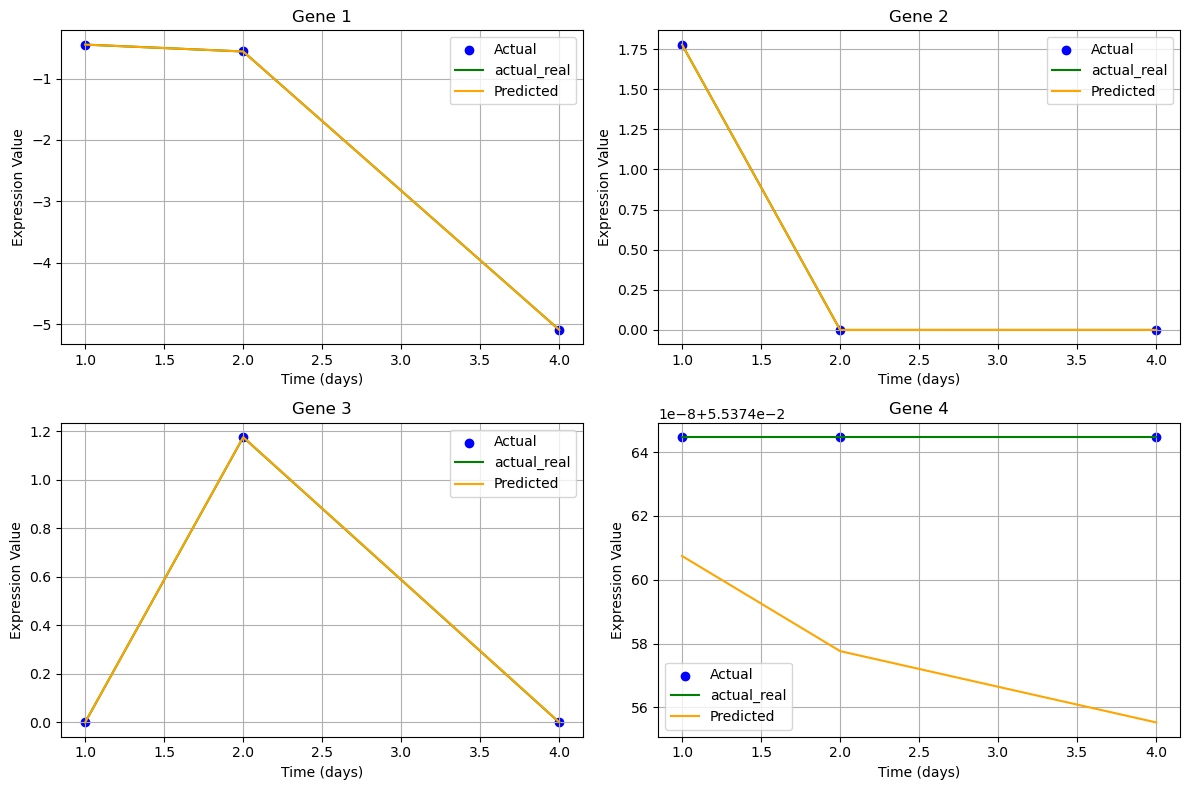

model:  PINN(
  (hidden): Sequential(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Tanh()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Tanh()
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
a Parameter containing:
tensor(0.8123, requires_grad=True)
b Parameter containing:
tensor(0.4041, requires_grad=True)
model:  PINN(
  (hidden): Sequential(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Tanh()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Tanh()
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
a Parameter containing:
tensor(1.2331, requires_grad=True)
b Parameter containing:
tensor(0.0092, requires_grad=True)
model:  PINN(
  (hidden): Sequential(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Tanh()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Tanh()
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
a 

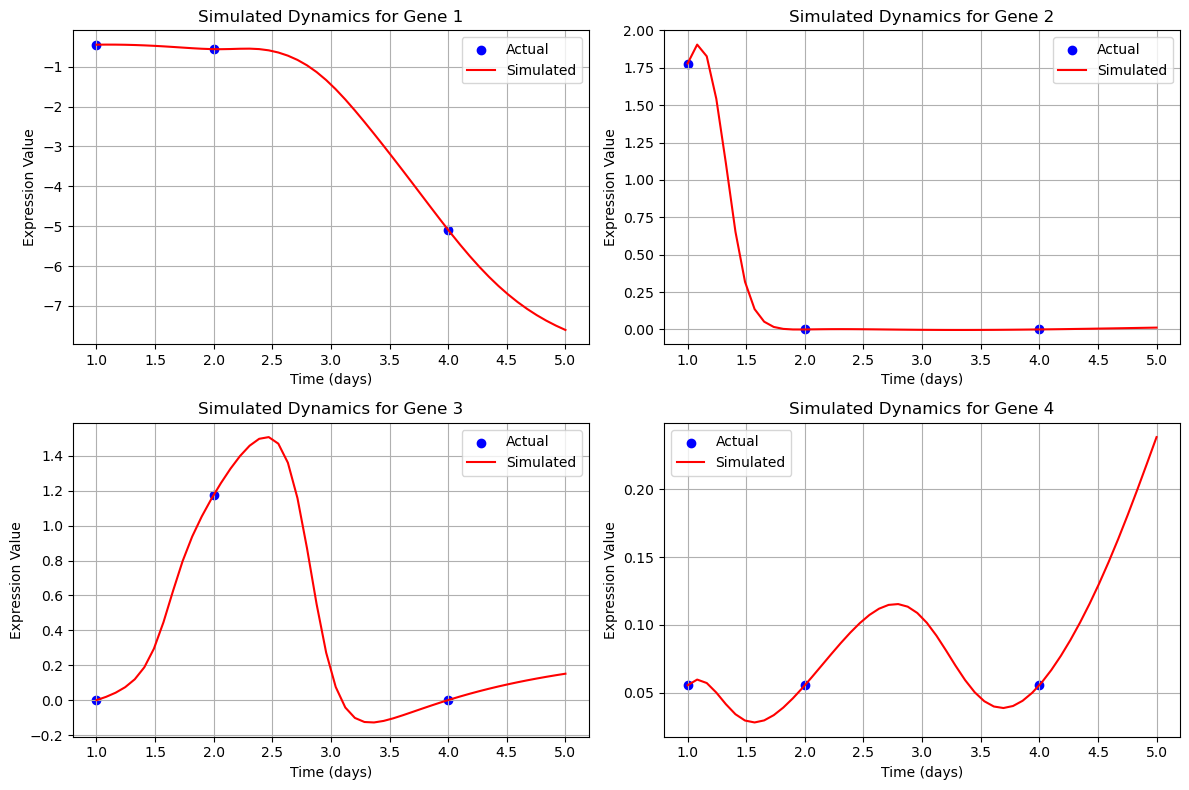

In [22]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Dataset (time points and gene expression values)
time_points = torch.tensor([1.0, 2.0, 4.0], dtype=torch.float32).view(-1, 1)  # Time: t = 1, 2, 4
expression_values = torch.tensor(
    [
        [-0.44796003, -0.560154646, -5.091964284],  # AT5G40100
        [1.778358524, 0.0, 0.0],                   # AT1G06930
        [0.0, 1.175149691, 0.0],                   # AT1G04470
        [0.055374646, 0.055374646, 0.055374646],  # AT5G66730
    ],
    dtype=torch.float32,
)

# PINN Model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )
        # Parameters for the ODE
        self.a = nn.Parameter(torch.tensor(1.0, requires_grad=True))  # Parameter a
        self.b = nn.Parameter(torch.tensor(1.0, requires_grad=True))  # Parameter b

    def forward(self, t):
        return self.hidden(t)

# Loss function for inverse PINN
def loss_fn(model, t, y_data):
    y_pred = model(t)
    y_t = torch.autograd.grad(
        y_pred, t, grad_outputs=torch.ones_like(y_pred), create_graph=True
    )[0]
    # ODE: dy/dt = a * y + b
    ode_residual = y_t - (model.a * y_pred + model.b)
    physics_loss = torch.mean(ode_residual**2)
    data_loss = torch.mean((y_pred - y_data)**2)
    return data_loss + physics_loss

# Training PINN for each gene
def train_pinn_for_gene(time_points, expression_values, gene_index, epochs=1000, lr=0.01):
    y_data = expression_values[gene_index].view(-1, 1)
    print("y_data: ", y_data)
    model = PINN()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        # Time points
        time_points = torch.tensor([[1.0], [2.0], [4.0]], requires_grad=True)  # This line is already correct
        loss = loss_fn(model, time_points, y_data)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Gene {gene_index + 1}, Epoch {epoch}, Loss: {loss.item()}")
    return model

# Train PINN for all genes
models = []
for i in range(expression_values.shape[0]):
    print(f"Training PINN for Gene {i + 1}...")
    model = train_pinn_for_gene(time_points, expression_values, i)
    models.append(model)

# Output estimated parameters
for i, model in enumerate(models):
    print(f"Gene {i + 1}: a = {model.a.item():.4f}, b = {model.b.item():.4f}")

# Plot predictions vs. actual data for each gene
plt.figure(figsize=(12, 8))
for i, model in enumerate(models):
    y_pred = model(time_points).detach().numpy()
    plt.subplot(2, 2, i + 1)
    plt.scatter(time_points.numpy(), expression_values[i].numpy(), color="blue", label="Actual")
    plt.plot(time_points.numpy(), expression_values[i].numpy(), color="green", label="actual_real")
    plt.plot(time_points.numpy(), y_pred, color="orange", label="Predicted")
    plt.title(f"Gene {i + 1}")
    plt.xlabel("Time (days)")
    plt.ylabel("Expression Value")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# Generate new data using the trained ODEs
new_time_points = torch.linspace(1, 5, 50).view(-1, 1)  # New time points for simulation
plt.figure(figsize=(12, 8))
for i, model in enumerate(models):
    print("model: ", model)
    print("a", model.a)
    print("b", model.b)
    y_new = model(new_time_points).detach().numpy()
    plt.subplot(2, 2, i + 1)
    plt.scatter(time_points.numpy(), expression_values[i].numpy(), color="blue", label="Actual")

    plt.plot(new_time_points.numpy(), y_new, color="red", label="Simulated")
    plt.title(f"Simulated Dynamics for Gene {i + 1}")
    plt.xlabel("Time (days)")
    plt.ylabel("Expression Value")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


in the dataset each row is for different genes and each gene is independent and each row is considered as a time series . 

- **Row-wise Data:**  
  Each row in the dataset represents the time series for one gene (with values corresponding to Day1, Day2, and Day4).

- **Independent Models:**  
  The code loops over each gene in the data dictionary. For each gene, it extracts the row (i.e., the gene's expression values over time) and then trains a separate instance of the ODE model.

- **Time Series Processing:**  
  The model uses the provided time points (1.0, 2.0, 4.0) as the independent variable. For each gene, the first time point is used as the initial condition, and the ODE is integrated over these time points.  

- **Separate Training:**  
  Each gene is handled independently in the training loop, so the learned parameters for one gene do not affect the others.

Thus, each gene's row is treated as its own time series and modeled independently.

# INVERSE PINN

##      ODE: dy/dt = a * y + b
    ode_residual = y_t - (model.a * y_pred + model.b)

Training PINN for Gene 1...
Gene 1, Epoch 0, Loss: 7.417261600494385
Gene 1, Epoch 100, Loss: 0.5912607908248901
Gene 1, Epoch 200, Loss: 0.07523936033248901
Training PINN for Gene 2...
Gene 2, Epoch 0, Loss: 2.86942982673645
Gene 2, Epoch 100, Loss: 0.11244143545627594
Gene 2, Epoch 200, Loss: 0.02865852788090706
Training PINN for Gene 3...
Gene 3, Epoch 0, Loss: 1.8155710697174072
Gene 3, Epoch 100, Loss: 0.30732107162475586
Gene 3, Epoch 200, Loss: 0.03820059821009636
Training PINN for Gene 4...
Gene 4, Epoch 0, Loss: 2.190298318862915
Gene 4, Epoch 100, Loss: 0.09075851738452911
Gene 4, Epoch 200, Loss: 0.01199246384203434
Gene 1: a = 0.0037, b = 0.0132
Gene 2: a = -0.0009, b = 0.0013
Gene 3: a = 0.1219, b = -0.0708
Gene 4: a = 1.0756, b = -0.0041


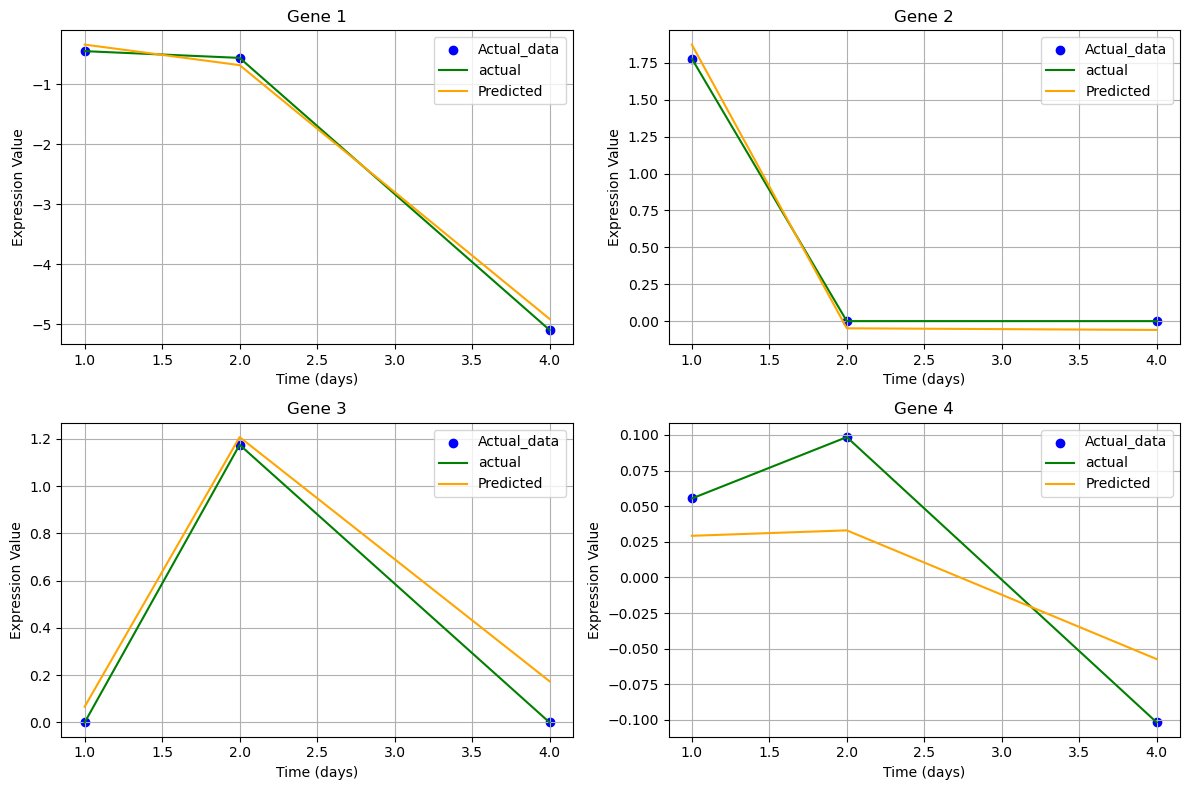

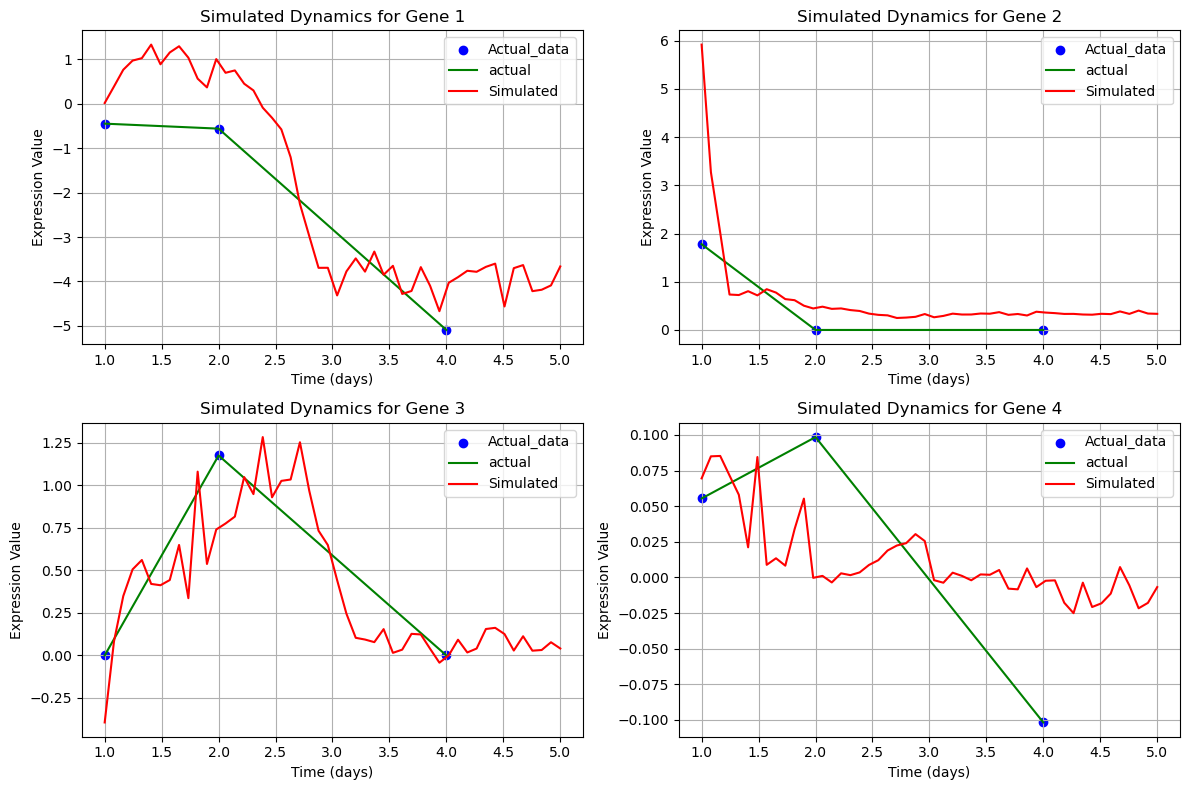

In [23]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Dataset (time points and gene expression values)
time_points = torch.tensor([1.0, 2.0, 4.0], dtype=torch.float32).view(-1, 1)  # Time: t = 1, 2, 4
expression_values = torch.tensor(
    [
        [-0.44796003, -0.560154646, -5.091964284],  # AT5G40100
        [1.778358524, 0.0, 0.0],                   # AT1G06930
        [0.0, 1.175149691, 0.0],                   # AT1G04470
        [0.055374646, 0.098434984, -0.101756864],  # AT5G66730
    ],
    dtype=torch.float32,
)

# PINN Model with LSTM, Dropout, and Normalization
class AdvancedPINN(nn.Module):
    def __init__(self):
        super(AdvancedPINN, self).__init__()
        self.pre_lstm = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.BatchNorm1d(50),
            nn.Dropout(0.2),
            nn.Linear(50, 100),
            nn.Tanh(),
            nn.BatchNorm1d(100),
            nn.Dropout(0.2)
        )
        self.lstm = nn.LSTM(input_size=100, hidden_size=100, num_layers=2, batch_first=True, dropout=0.2)
        self.post_lstm = nn.Sequential(
            nn.Linear(100, 50),
            nn.Tanh(),
            nn.BatchNorm1d(50),
            nn.Dropout(0.2),
            nn.Linear(50, 1)
        )
        # Parameters for the ODE
        self.a = nn.Parameter(torch.tensor(1.0, requires_grad=True))  # Parameter a
        self.b = nn.Parameter(torch.tensor(1.0, requires_grad=True))  # Parameter b

    def forward(self, t):
        t_preprocessed = self.pre_lstm(t)
        t_preprocessed = t_preprocessed.unsqueeze(0)  # Add batch dimension for LSTM
        lstm_out, _ = self.lstm(t_preprocessed)
        lstm_out = lstm_out.squeeze(0)  # Remove batch dimension
        return self.post_lstm(lstm_out)

# Loss function for inverse PINN
def loss_fn(model, t, y_data):
    y_pred = model(t)
    y_t = torch.autograd.grad(
        y_pred, t, grad_outputs=torch.ones_like(y_pred), create_graph=True
    )[0]
    # ODE: dy/dt = a * y + b
    ode_residual = y_t - (model.a * y_pred + model.b)
    physics_loss = torch.mean(ode_residual**2)
    data_loss = torch.mean((y_pred - y_data)**2)
    return data_loss + physics_loss

# Training PINN for each gene
def train_pinn_for_gene(time_points, expression_values, gene_index, epochs=300, lr=0.01):
    y_data = expression_values[gene_index].view(-1, 1)
    model = AdvancedPINN()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        time_points = torch.tensor([[1.0], [2.0], [4.0]], requires_grad=True)
        loss = loss_fn(model, time_points, y_data)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Gene {gene_index + 1}, Epoch {epoch}, Loss: {loss.item()}")
    return model

# Train PINN for all genes
models = []
for i in range(expression_values.shape[0]):
    print(f"Training PINN for Gene {i + 1}...")
    model = train_pinn_for_gene(time_points, expression_values, i)
    models.append(model)

# Output estimated parameters
for i, model in enumerate(models):
    print(f"Gene {i + 1}: a = {model.a.item():.4f}, b = {model.b.item():.4f}")

# Plot predictions vs. actual data for each gene
plt.figure(figsize=(12, 8))
for i, model in enumerate(models):
    y_pred = model(time_points).detach().numpy()
    plt.subplot(2, 2, i + 1)
    plt.scatter(time_points.numpy(), expression_values[i].numpy(), color="blue", label="Actual_data")
    plt.plot(time_points.numpy(), expression_values[i].numpy(), color="green", label="actual")
    plt.plot(time_points.numpy(), y_pred, color="orange", label="Predicted")
    plt.title(f"Gene {i + 1}")
    plt.xlabel("Time (days)")
    plt.ylabel("Expression Value")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# Generate new data using the trained ODEs
new_time_points = torch.linspace(1, 5, 50).view(-1, 1)  # New time points for simulation
plt.figure(figsize=(12, 8))
for i, model in enumerate(models):
    y_new = model(new_time_points).detach().numpy()
    plt.subplot(2, 2, i + 1)
    plt.scatter(time_points.numpy(), expression_values[i].numpy(), color="blue", label="Actual_data")
    plt.plot(time_points.numpy(), expression_values[i].numpy(), color="green", label="actual")

    plt.plot(new_time_points.numpy(), y_new, color="red", label="Simulated")
    plt.title(f"Simulated Dynamics for Gene {i + 1}")
    plt.xlabel("Time (days)")
    plt.ylabel("Expression Value")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


# Inverse PINN

##  ODE parameters for: dy/dt = α + β * y(t) + γ * t
    
    
    ode_residual = y_t - (model.alpha + model.beta * y_pred + model.gamma * t.squeeze())


AT5G40100 - Epoch 0, Loss: 21.9041
AT5G40100 - Epoch 100, Loss: 0.2047
AT5G40100 - Epoch 200, Loss: 0.0238
AT5G40100 - Epoch 300, Loss: 0.0125
AT5G40100 - Epoch 400, Loss: 0.0038
AT5G40100 - Epoch 500, Loss: 0.0016
AT5G40100 - Epoch 600, Loss: 0.0009
AT5G40100 - Epoch 700, Loss: 0.0002
AT5G40100 - Epoch 800, Loss: 0.0000
AT5G40100 - Epoch 900, Loss: 0.0013


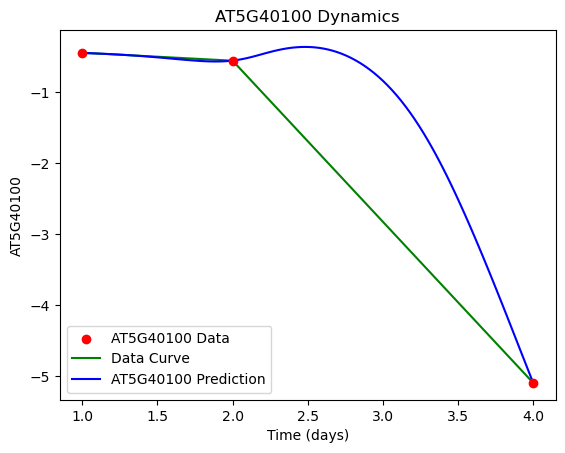

AT1G06930 - Epoch 0, Loss: 13.4307
AT1G06930 - Epoch 100, Loss: 0.3763
AT1G06930 - Epoch 200, Loss: 0.0001
AT1G06930 - Epoch 300, Loss: 0.0000
AT1G06930 - Epoch 400, Loss: 0.0000
AT1G06930 - Epoch 500, Loss: 0.0000
AT1G06930 - Epoch 600, Loss: 0.0000
AT1G06930 - Epoch 700, Loss: 0.0000
AT1G06930 - Epoch 800, Loss: 0.0039
AT1G06930 - Epoch 900, Loss: 0.0000


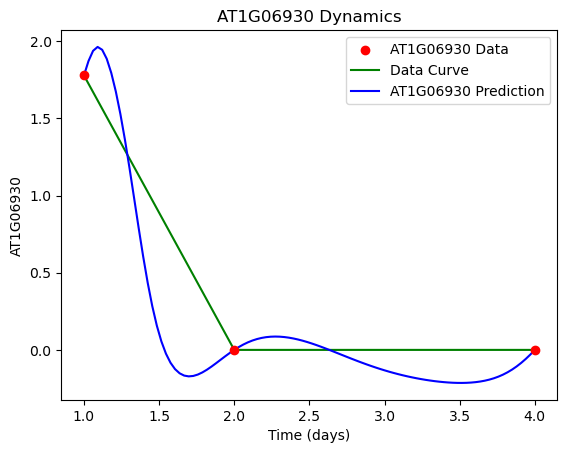

AT1G04470 - Epoch 0, Loss: 14.2844
AT1G04470 - Epoch 100, Loss: 0.6269
AT1G04470 - Epoch 200, Loss: 0.0000
AT1G04470 - Epoch 300, Loss: 0.0000
AT1G04470 - Epoch 400, Loss: 0.0000
AT1G04470 - Epoch 500, Loss: 0.0000
AT1G04470 - Epoch 600, Loss: 0.0000
AT1G04470 - Epoch 700, Loss: 0.0000
AT1G04470 - Epoch 800, Loss: 0.0000
AT1G04470 - Epoch 900, Loss: 0.0000


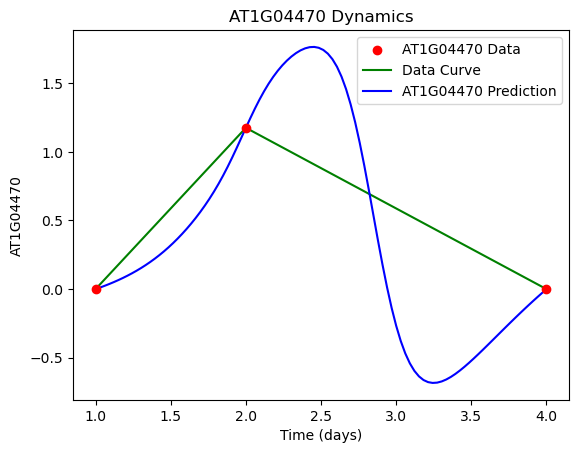

AT5G66730 - Epoch 0, Loss: 15.2327
AT5G66730 - Epoch 100, Loss: 0.2147
AT5G66730 - Epoch 200, Loss: 0.0280
AT5G66730 - Epoch 300, Loss: 0.0088
AT5G66730 - Epoch 400, Loss: 0.0006
AT5G66730 - Epoch 500, Loss: 0.0000
AT5G66730 - Epoch 600, Loss: 0.0000
AT5G66730 - Epoch 700, Loss: 0.0000
AT5G66730 - Epoch 800, Loss: 0.0000
AT5G66730 - Epoch 900, Loss: 0.0000


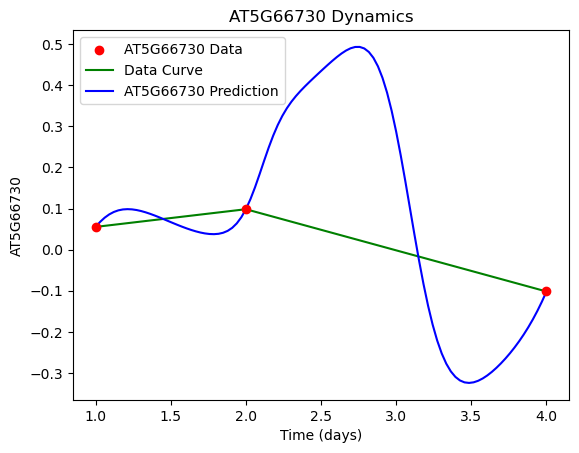

AT2G38471 - Epoch 0, Loss: 12.4578
AT2G38471 - Epoch 100, Loss: 0.2255
AT2G38471 - Epoch 200, Loss: 0.0001
AT2G38471 - Epoch 300, Loss: 0.0000
AT2G38471 - Epoch 400, Loss: 0.0000
AT2G38471 - Epoch 500, Loss: 0.0000
AT2G38471 - Epoch 600, Loss: 0.0005
AT2G38471 - Epoch 700, Loss: 0.0000
AT2G38471 - Epoch 800, Loss: 0.0000
AT2G38471 - Epoch 900, Loss: 0.0000


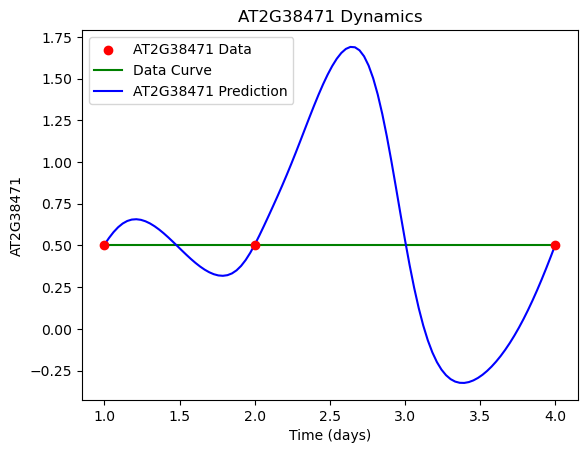

AT2G38472 - Epoch 0, Loss: 13.6366
AT2G38472 - Epoch 100, Loss: 0.5937
AT2G38472 - Epoch 200, Loss: 0.1038
AT2G38472 - Epoch 300, Loss: 0.0231
AT2G38472 - Epoch 400, Loss: 0.0000
AT2G38472 - Epoch 500, Loss: 0.0000
AT2G38472 - Epoch 600, Loss: 0.0000
AT2G38472 - Epoch 700, Loss: 0.0000
AT2G38472 - Epoch 800, Loss: 0.0000
AT2G38472 - Epoch 900, Loss: 0.0000


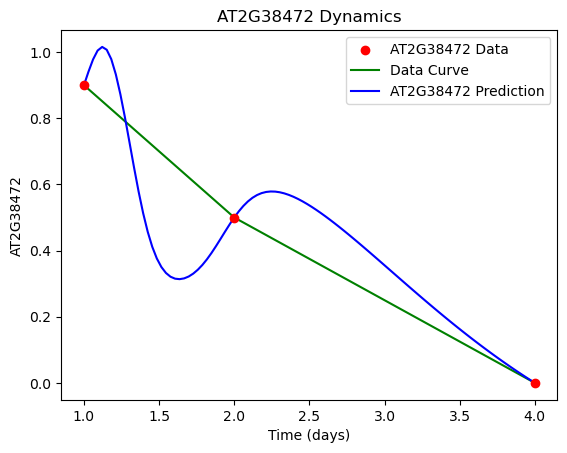

AT2G38473 - Epoch 0, Loss: 15.1844
AT2G38473 - Epoch 100, Loss: 0.4602
AT2G38473 - Epoch 200, Loss: 0.0000
AT2G38473 - Epoch 300, Loss: 0.0000
AT2G38473 - Epoch 400, Loss: 0.0000
AT2G38473 - Epoch 500, Loss: 0.0000
AT2G38473 - Epoch 600, Loss: 0.0000
AT2G38473 - Epoch 700, Loss: 0.0000
AT2G38473 - Epoch 800, Loss: 0.0001
AT2G38473 - Epoch 900, Loss: 0.0000


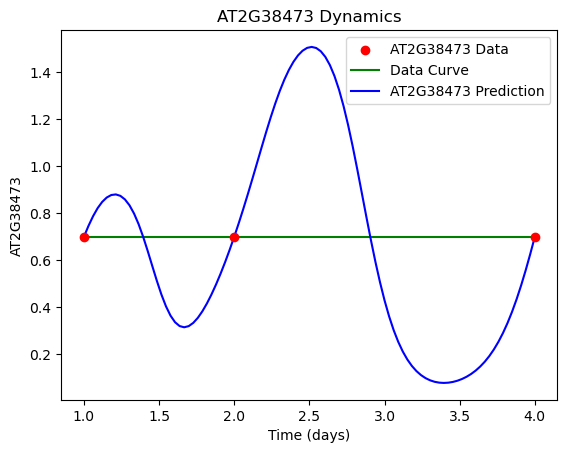

AT2G38474 - Epoch 0, Loss: 10.9374
AT2G38474 - Epoch 100, Loss: 0.3606
AT2G38474 - Epoch 200, Loss: 0.0057
AT2G38474 - Epoch 300, Loss: 0.0014
AT2G38474 - Epoch 400, Loss: 0.0004
AT2G38474 - Epoch 500, Loss: 0.0001
AT2G38474 - Epoch 600, Loss: 0.0000
AT2G38474 - Epoch 700, Loss: 0.0001
AT2G38474 - Epoch 800, Loss: 0.0000
AT2G38474 - Epoch 900, Loss: 0.0000


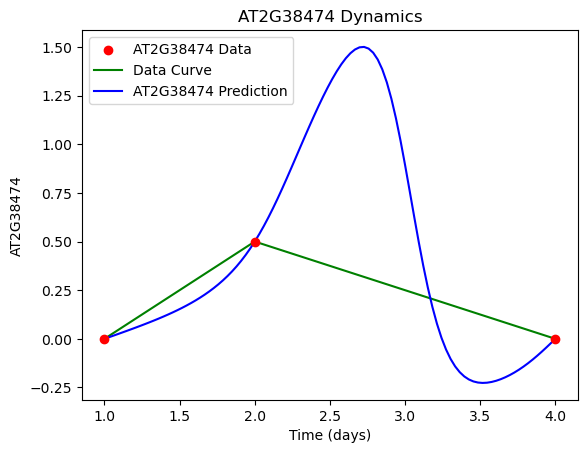

AT2G38470 - Epoch 0, Loss: 13.9535
AT2G38470 - Epoch 100, Loss: 0.5012
AT2G38470 - Epoch 200, Loss: 0.0000
AT2G38470 - Epoch 300, Loss: 0.0011
AT2G38470 - Epoch 400, Loss: 0.0000
AT2G38470 - Epoch 500, Loss: 0.0000
AT2G38470 - Epoch 600, Loss: 0.0000
AT2G38470 - Epoch 700, Loss: 0.0036
AT2G38470 - Epoch 800, Loss: 0.0000
AT2G38470 - Epoch 900, Loss: 0.0000


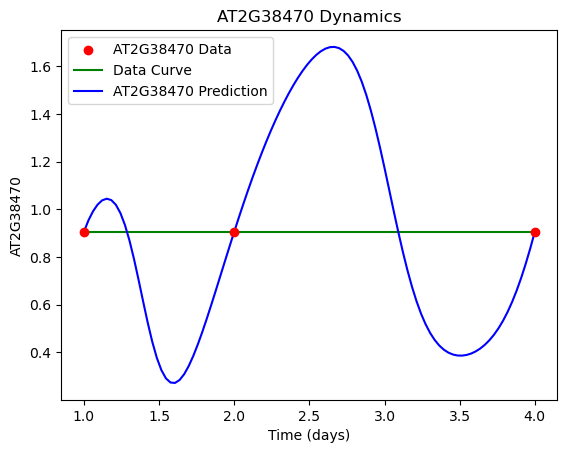

AT5G40100: alpha = 0.126422, beta = 1.427553, gamma = 0.458940
AT1G06930: alpha = 0.240050, beta = 1.620954, gamma = 0.199782
AT1G04470: alpha = 0.190649, beta = 1.558723, gamma = 0.188177
AT5G66730: alpha = 0.133287, beta = 1.580832, gamma = 0.218977
AT2G38471: alpha = 0.289210, beta = 1.505064, gamma = 0.336179
AT2G38472: alpha = -0.053002, beta = 1.636983, gamma = -0.058540
AT2G38473: alpha = 0.258616, beta = 1.473150, gamma = 0.293455
AT2G38474: alpha = 0.113050, beta = 1.596751, gamma = 0.159238
AT2G38470: alpha = 0.191304, beta = 1.516938, gamma = 0.199957


In [24]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define the neural network that approximates y(t)
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)  # Single output: y(t)
        )
        # Learnable ODE parameters for: dy/dt = α + β * y(t) + γ * t
        self.alpha = nn.Parameter(torch.tensor(1.0, requires_grad=True))
        self.beta  = nn.Parameter(torch.tensor(1.0, requires_grad=True))
        self.gamma = nn.Parameter(torch.tensor(1.0, requires_grad=True))

    def forward(self, t):
        return self.hidden(t)

# Define the loss function with data and physics (ODE) components
def loss_fn(model, t, y_data):
    # Get the predicted y(t)
    y_pred = model(t).squeeze()  # Shape: (num_time_points,)
    
    # Compute dy/dt via autograd
    y_t = torch.autograd.grad(
        y_pred, t, grad_outputs=torch.ones_like(y_pred), create_graph=True
    )[0].squeeze()  # Shape: (num_time_points,)
    
    # Compute the ODE residual: dy/dt should equal α + β*y(t) + γ*t
    # We squeeze t to have the same shape as y_pred
    ode_residual = y_t - (model.alpha + model.beta * y_pred + model.gamma * t.squeeze())
    
    physics_loss = torch.mean(ode_residual**2)
    data_loss = torch.mean((y_pred - y_data)**2)
    
    return data_loss + physics_loss

# Data: Each gene has expression values at Day1, Day2, Day4
data = {
    "AT5G40100": [-0.44796003, -0.560154646, -5.091964284],
    "AT1G06930": [1.778358524, 0, 0],
    "AT1G04470": [0, 1.175149691, 0],
    "AT5G66730": [0.055374646, 0.098434984, -0.101756864],
    "AT2G38471": [0.505, 0.505, 0.505],
    "AT2G38472": [0.9, 0.5, 0],
    "AT2G38473": [0.7, 0.7, 0.7],
    "AT2G38474": [0, 0.5, 0],
    "AT2G38470": [0.906000416, 0.906000416, 0.906000416]
}

# Time points as a tensor: shape (3, 1)
time_points = torch.tensor([[1.0], [2.0], [4.0]], dtype=torch.float32, requires_grad=True)

results = {}

# Loop over each gene
for gene, values in data.items():
    y_data = torch.tensor(values, dtype=torch.float32)
    
    # Initialize the neural network model for this gene
    model = NeuralNet()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    # Training loop
    epochs = 1000
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = loss_fn(model, time_points, y_data)
        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0:
            print(f"{gene} - Epoch {epoch}, Loss: {loss.item():.4f}")
    
    # Save the learned parameters
    results[gene] = {
        "alpha": model.alpha.item(),
        "beta": model.beta.item(),
        "gamma": model.gamma.item()
    }
    
    # Generate predictions for plotting over a smooth time grid
    t_test = torch.linspace(1.0, 4.0, 100).view(-1, 1)
    y_pred = model(t_test).detach().numpy()
    
    # Plot observed data vs. Neural ODE predictions
    plt.figure()
    plt.scatter(time_points.detach().numpy(), y_data.numpy(), color='red', label=f'{gene} Data', zorder=5)
    plt.plot(time_points.detach().numpy(), y_data.numpy(), color='green', label='Data Curve', zorder=3)
    plt.plot(t_test.detach().numpy(), y_pred, label=f'{gene} Prediction', color='blue', zorder=4)
    plt.title(f'{gene} Dynamics')
    plt.xlabel('Time (days)')
    plt.ylabel(gene)
    plt.legend()
    plt.show()

# Print the learned parameters for each gene
for gene, params in results.items():
    print(f"{gene}: alpha = {params['alpha']:.6f}, beta = {params['beta']:.6f}, gamma = {params['gamma']:.6f}")


# not used ------------------
# neural ODE + Inverse PINN
    def forward(self, t, y):
        # dy/dt = α + β*y + γ*t
        return self.alpha + self.beta * y + self.gamma * t

In [77]:
# import numpy as np
# import pandas as pd
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torchdiffeq import odeint
# import matplotlib.pyplot as plt

# # Load dataset (genes as rows, time points as columns)
# df = df
# time_points = np.array([1.0, 2.0, 4.0], dtype=np.float32)  # Days 1, 2, 4
# # gene_data = df.values.astype(np.float32)
# gene_data = df[["Hpa-NO_1d", "Hpa-NO_2d", "Hpa-NO_4d"]].values


# # Convert to PyTorch tensors
# time_points_tensor = torch.tensor(time_points, dtype=torch.float32, requires_grad=True)
# gene_data_tensor = torch.tensor(gene_data, dtype=torch.float32)

# ##############################################################################
# # Neural ODE Model (Parametric ODE with Learnable Parameters)
# ##############################################################################

# class GeneODE(nn.Module):
#     def __init__(self):
#         super().__init__()
#         # Initialize parameters (α, β, γ)
#         self.alpha = nn.Parameter(torch.randn(1) * 0.1)
#         self.beta = nn.Parameter(torch.randn(1) * 0.1)
#         self.gamma = nn.Parameter(torch.randn(1) * 0.1)

#     def forward(self, t, y):
#         # dy/dt = α + β*y + γ*t
#         return self.alpha + self.beta * y + self.gamma * t

# # Create one ODE model per gene
# num_genes = gene_data_tensor.shape[0]
# ode_models = nn.ModuleList([GeneODE() for _ in range(num_genes)])

# ##############################################################################
# # Inverse PINN Loss Function
# ##############################################################################

# def inverse_pinn_loss(ode_models, time_points, gene_data, lambda_physics=0.1):
#     total_data_loss = 0.0
#     total_physics_loss = 0.0
    
#     for i in range(len(ode_models)):
#         y_observed = gene_data[i]
#         y0 = y_observed[0].unsqueeze(0)
        
#         # Solve ODE for current gene
#         preds = odeint(ode_models[i], y0, time_points).squeeze()
        
#         # Data loss (MSE between predictions and data)
#         data_loss = torch.mean((preds - y_observed)**2)
        
#         # Physics loss (ensure predictions satisfy ODE structure)
#         # Compute dy/dt from predictions
#         dy_dt_pred = torch.autograd.grad(
#             preds, time_points, grad_outputs=torch.ones_like(preds),
#             create_graph=True, retain_graph=True
#         )[0]
        
#         # Compute dy/dt from the ODE model
#         dy_dt_ode = []
#         for t_val, p_val in zip(time_points, preds):
#             deriv = ode_models[i](t_val, p_val.unsqueeze(0))
#             dy_dt_ode.append(deriv.squeeze())
#         dy_dt_ode = torch.stack(dy_dt_ode)
        
#         physics_loss = torch.mean((dy_dt_pred - dy_dt_ode)**2)
        
#         total_data_loss += data_loss
#         total_physics_loss += physics_loss
    
#     avg_data_loss = total_data_loss / len(ode_models)
#     avg_physics_loss = total_physics_loss / len(ode_models)
#     total_loss = avg_data_loss + lambda_physics * avg_physics_loss
#     return total_loss, avg_data_loss, avg_physics_loss

# ##############################################################################
# # Training Loop
# ##############################################################################

# optimizer = optim.Adam(ode_models.parameters(), lr=0.01)
# epochs = 1000

# for epoch in range(epochs):
#     optimizer.zero_grad()
#     total_loss, data_loss, physics_loss = inverse_pinn_loss(
#         ode_models, time_points_tensor, gene_data_tensor
#     )
#     total_loss.backward()
#     optimizer.step()
    
#     if epoch % 300 == 0:
#         print(f"Epoch {epoch:4d} | Loss: {total_loss.item():.4f} | Data: {data_loss.item():.4f} | Physics: {physics_loss.item():.4f}")

# ##############################################################################
# # Results: Learned ODEs and Plots
# ##############################################################################

# for i, gene_id in enumerate(df.index):
#     # Extract learned parameters
#     α = ode_models[i].alpha.item()
#     β = ode_models[i].beta.item()
#     γ = ode_models[i].gamma.item()
    
#     # Define the ODE as a string
#     ode_equation = f"dy/dt = {α:.3f} + {β:.3f} y(t) + {γ:.3f} t"
    
#     # Solve the ODE for plotting
#     y0 = gene_data_tensor[i, 0].unsqueeze(0)
#     preds = odeint(ode_models[i], y0, time_points_tensor).squeeze().detach().numpy()
    
#     # Plot observed vs. predicted
#     plt.figure(figsize=(8, 4))
#     plt.scatter(time_points, gene_data[i], c='r', label='Observed Data')
#     plt.plot(time_points, gene_data[i],  label='real Data')

#     plt.plot(time_points, preds, 'b--', label='ODE Prediction')
#     plt.title(f"Gene {gene_id}\n{ode_equation}")
#     plt.xlabel("Time (days)")
#     plt.ylabel("Expression Level")
#     plt.legend()
#     plt.grid(True)
#     plt.show()

#     # Print parameters
#     print(f"Gene {gene_id}:")
#     print(f"  α = {α:.3f}, β = {β:.3f}, γ = {γ:.3f}\n")

# Inverse PINN

## ODE residual: dy/dt + k(t)*y(t) - c(t) = 0
    ode_residual = dy_dt + k * y_pred - c

Step 1: Define the Neural Networks for Time-Dependent Parameters


In [7]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define neural networks for k(t) and c(t)
class TimeDependentParams(nn.Module):
    def __init__(self):
        super(TimeDependentParams, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 50),  # Input: time `t`
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 2)   # Output: k(t) and c(t)
        )

    def forward(self, t):
        params = self.net(t)
        k = params[:, 0]
        c = params[:, 1]
        return k, c

# Main neural network for y(t)
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )
        self.param_net = TimeDependentParams()  # Time-dependent k(t) and c(t)

    def forward(self, t):
        y_pred = self.hidden(t).squeeze()
        k, c = self.param_net(t)
        return y_pred, k, c

Step 2: Define the Physics-Informed Loss Function


In [ ]:
def loss_fn(model, t, y_data):
    y_pred, k, c = model(t)

    # Compute derivative dy/dt
    dy_dt = torch.autograd.grad(
        y_pred, t, 
        grad_outputs=torch.ones_like(y_pred), 
        create_graph=True
    )[0]

    # ODE residual: dy/dt + k(t)*y(t) - c(t) = 0
    ode_residual = dy_dt + k * y_pred - c

    # Loss terms
    data_loss = torch.mean((y_pred - y_data)**2)
    physics_loss = torch.mean(ode_residual**2)

    return data_loss + 1.0 * physics_loss

Step 3: Training Loop (Per Gene)


AT5G40100 - Epoch 0, Loss: 8.97464370727539
AT5G40100 - Epoch 100, Loss: 0.014693988487124443
AT5G40100 - Epoch 200, Loss: 5.363090735954756e-07


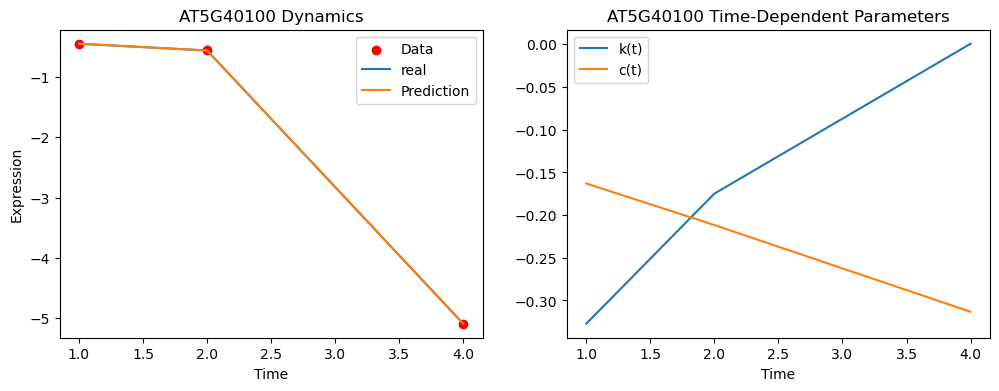

AT1G06930 - Epoch 0, Loss: 2.0471246242523193
AT1G06930 - Epoch 100, Loss: 0.0020125433802604675
AT1G06930 - Epoch 200, Loss: 2.1162598784485454e-08


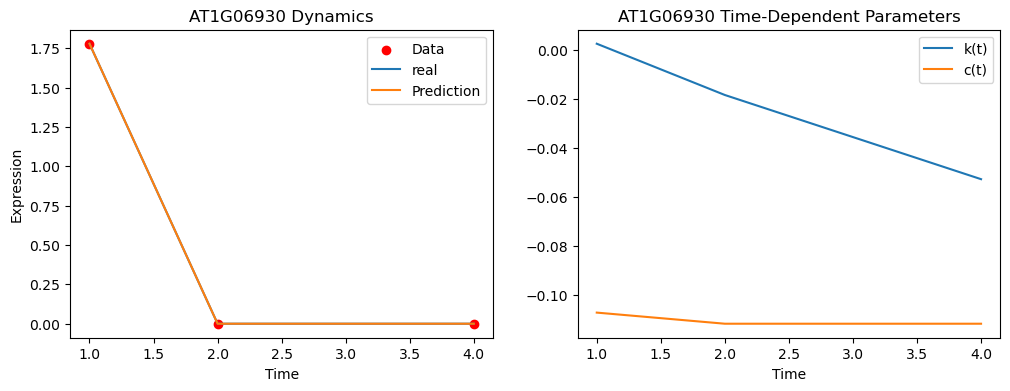

AT1G04470 - Epoch 0, Loss: 0.4168996512889862
AT1G04470 - Epoch 100, Loss: 0.25817498564720154
AT1G04470 - Epoch 200, Loss: 3.389906487427652e-05


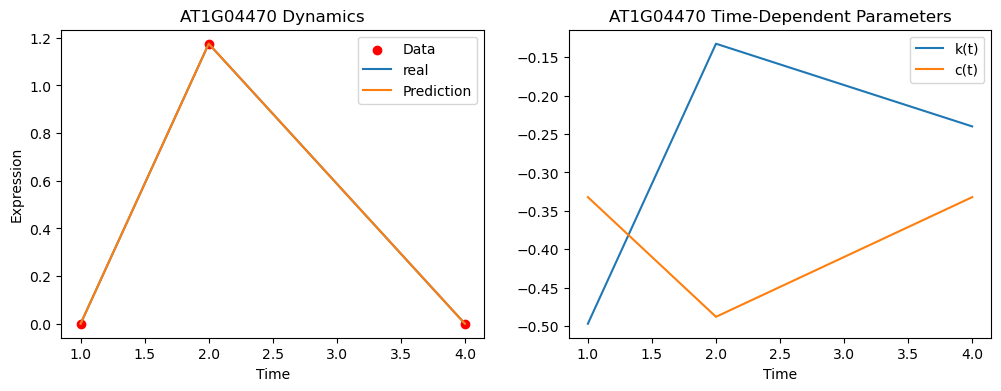

AT5G66730 - Epoch 0, Loss: 0.09744091331958771
AT5G66730 - Epoch 100, Loss: 0.0029084791895002127
AT5G66730 - Epoch 200, Loss: 0.0016383817419409752


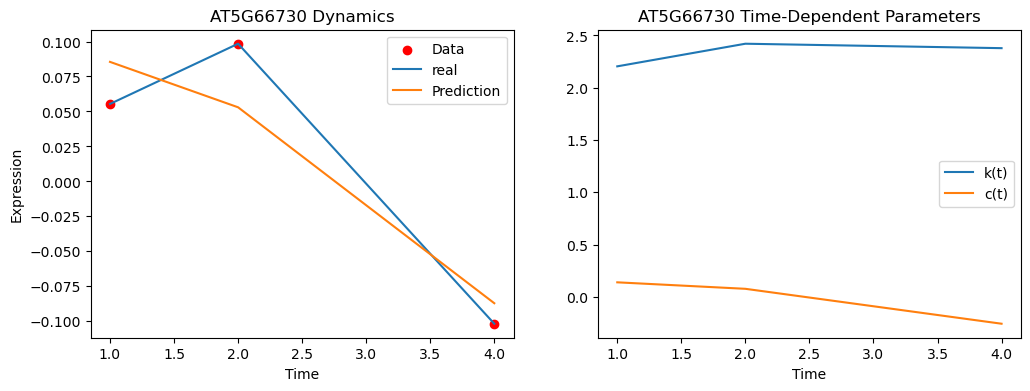

AT2G38471 - Epoch 0, Loss: 0.23198357224464417
AT2G38471 - Epoch 100, Loss: 8.934063771448564e-06
AT2G38471 - Epoch 200, Loss: 2.2134568098408636e-06


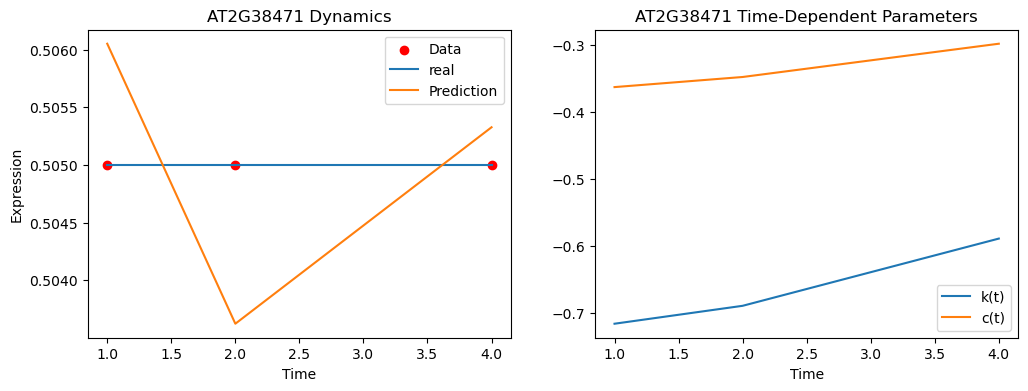

AT2G38472 - Epoch 0, Loss: 0.5989284515380859
AT2G38472 - Epoch 100, Loss: 0.0034145889803767204
AT2G38472 - Epoch 200, Loss: 0.0019985055550932884


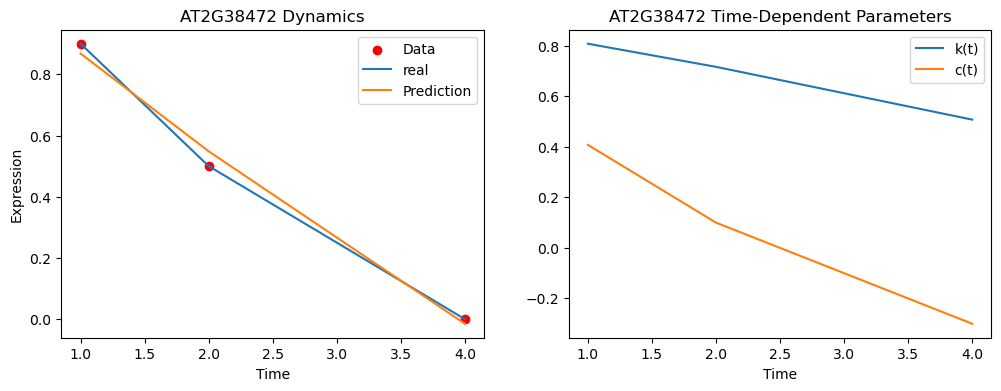

AT2G38473 - Epoch 0, Loss: 0.937823474407196
AT2G38473 - Epoch 100, Loss: 1.9947317923652008e-05
AT2G38473 - Epoch 200, Loss: 2.6987263481714763e-06


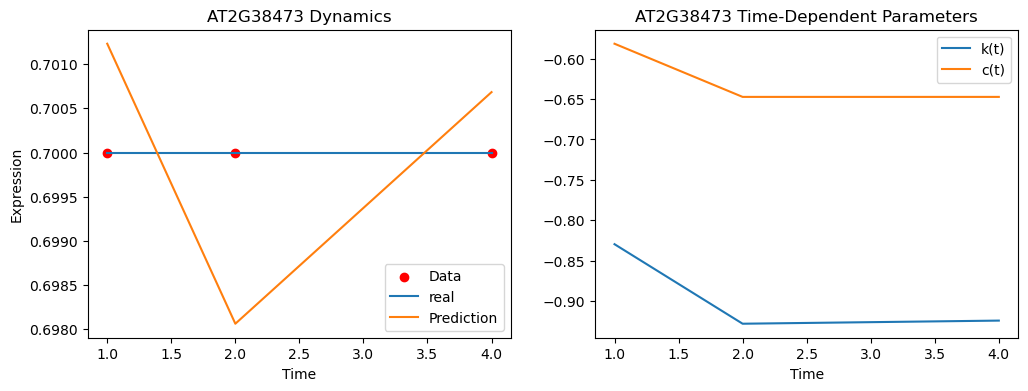

AT2G38474 - Epoch 0, Loss: 0.0721244215965271
AT2G38474 - Epoch 100, Loss: 0.050659116357564926
AT2G38474 - Epoch 200, Loss: 0.04256811738014221


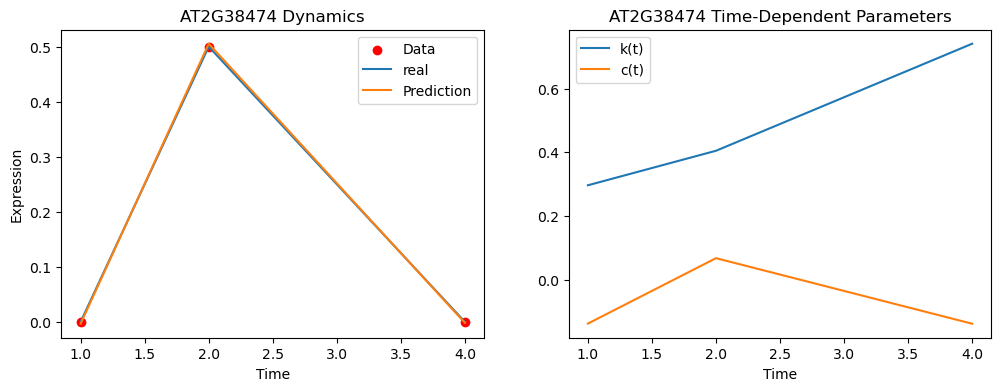

AT2G38470 - Epoch 0, Loss: 0.6862806081771851
AT2G38470 - Epoch 100, Loss: 1.3532760021917056e-05
AT2G38470 - Epoch 200, Loss: 1.7755302224031766e-06


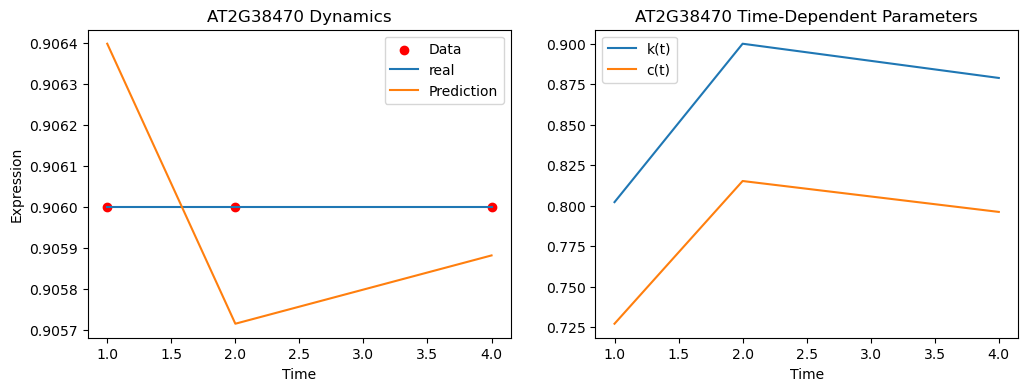


Example Learned Parameters (AT5G40100):
Time	k(t)		c(t)
1.00	-0.327211	-0.162987
1.03	-0.174866	-0.211610
1.06	0.000715	-0.313203


In [11]:
# Dataset
data = {
    "AT5G40100": [-0.44796003, -0.560154646, -5.091964284],
    "AT1G06930": [1.778358524, 0, 0],
    "AT1G04470": [0, 1.175149691, 0],
    "AT5G66730": [0.055374646, 0.098434984, -0.101756864],
    "AT2G38471": [0.505, 0.505, 0.505],
    "AT2G38472": [0.9, 0.5, 0],
    "AT2G38473": [0.7, 0.7, 0.7],
    "AT2G38474": [0, 0.5, 0],
    "AT2G38470": [0.906000416, 0.906000416, 0.906000416]
}

time_points = torch.tensor([[1.0], [2.0], [4.0]], requires_grad=True)
results = {}

for gene, values in data.items():
    y_data = torch.tensor(values, dtype=torch.float32)
    
    # Initialize model and optimizer
    model = NeuralNet()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    # Training loop
    for epoch in range(300):
        optimizer.zero_grad()
        loss = loss_fn(model, time_points, y_data)
        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0:
            print(f"{gene} - Epoch {epoch}, Loss: {loss.item()}")
    
    # Save results
    # t_test = torch.linspace(1.0, 4.0, 100).view(-1, 1).requires_grad_(True)
    # y_pred, k_pred, c_pred = model(t_test)


    y_pred, k_pred, c_pred = model(time_points)

    
    results[gene] = {
        "y_pred": y_pred.detach().numpy(),
        "k(t)": k_pred.detach().numpy(),
        "c(t)": c_pred.detach().numpy()
    }

    # Plot results
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.scatter(time_points.detach().numpy(), y_data.numpy(), color='red', label='Data')
    plt.plot(time_points.detach().numpy(), y_data.numpy(), label='real')

    # plt.plot(t_test.detach().numpy(), y_pred.detach().numpy(), label='Prediction')
    plt.plot(time_points.detach().numpy(), y_pred.detach().numpy(), label='Prediction')

    plt.title(f"{gene} Dynamics")
    plt.xlabel("Time")
    plt.ylabel("Expression")
    plt.legend()

    plt.subplot(1, 2, 2)
    # plt.plot(t_test.detach().numpy(), k_pred.detach().numpy(), label='k(t)')
    # plt.plot(t_test.detach().numpy(), c_pred.detach().numpy(), label='c(t)')

    plt.plot(time_points.detach().numpy(), k_pred.detach().numpy(), label='k(t)')
    plt.plot(time_points.detach().numpy(), c_pred.detach().numpy(), label='c(t)')
    plt.title(f"{gene} Time-Dependent Parameters")
    plt.xlabel("Time")
    plt.legend()
    plt.show()

# Print learned parameters (example for AT5G40100)
print("\nExample Learned Parameters (AT5G40100):")
print("Time\tk(t)\t\tc(t)")
for t, k, c in zip(t_test.detach().numpy(), 
                   results["AT5G40100"]["k(t)"], 
                   results["AT5G40100"]["c(t)"]):
    print(f"{t[0]:.2f}\t{k:.6f}\t{c:.6f}")

# INVERSE PINN 

    ode_residual = y_t + model.k * y_pred - model.c

AT5G40100 - Epoch 0, Loss: 10.052746772766113
AT5G40100 - Epoch 100, Loss: 0.03151002526283264
AT5G40100 - Epoch 200, Loss: 5.527404596250562e-07


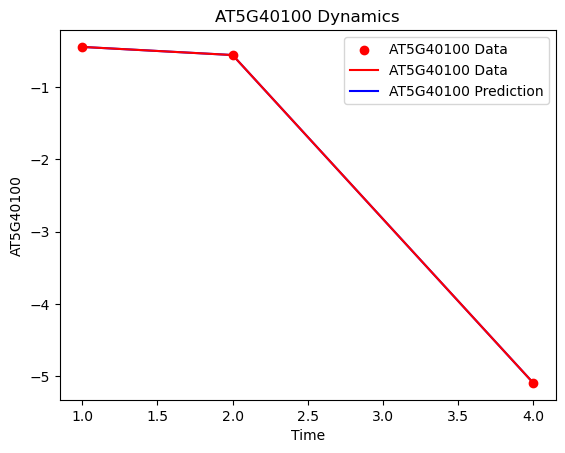

AT1G06930 - Epoch 0, Loss: 4.700829982757568
AT1G06930 - Epoch 100, Loss: 0.34164923429489136
AT1G06930 - Epoch 200, Loss: 0.009589022025465965


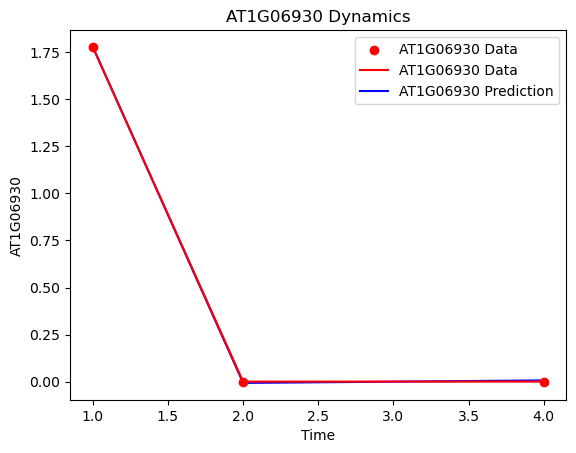

AT1G04470 - Epoch 0, Loss: 2.375140428543091
AT1G04470 - Epoch 100, Loss: 0.20677529275417328
AT1G04470 - Epoch 200, Loss: 0.0190199613571167


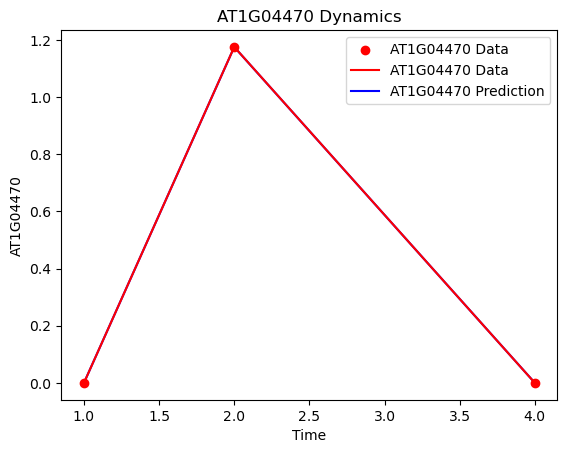

AT5G66730 - Epoch 0, Loss: 0.6248986721038818
AT5G66730 - Epoch 100, Loss: 0.05213100463151932
AT5G66730 - Epoch 200, Loss: 0.007938128896057606


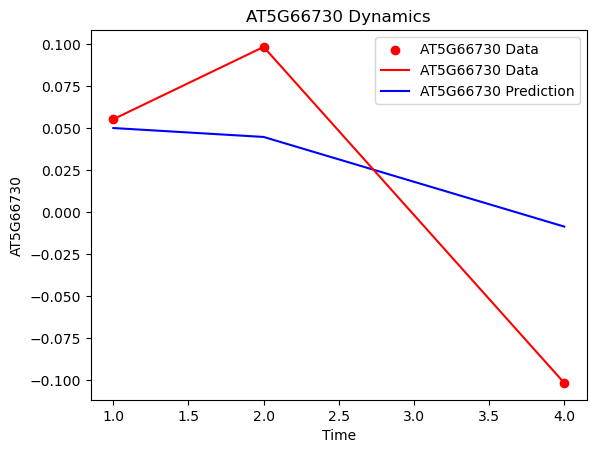

AT2G38471 - Epoch 0, Loss: 2.0949509143829346
AT2G38471 - Epoch 100, Loss: 0.001405444461852312
AT2G38471 - Epoch 200, Loss: 4.27118138759397e-05


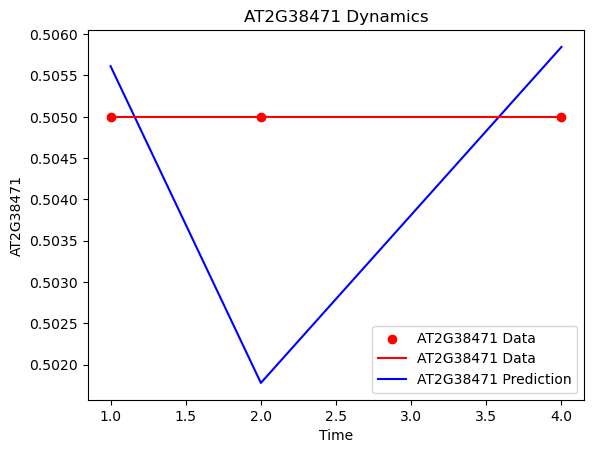

AT2G38472 - Epoch 0, Loss: 2.0097756385803223
AT2G38472 - Epoch 100, Loss: 0.11180244386196136
AT2G38472 - Epoch 200, Loss: 0.08495555818080902


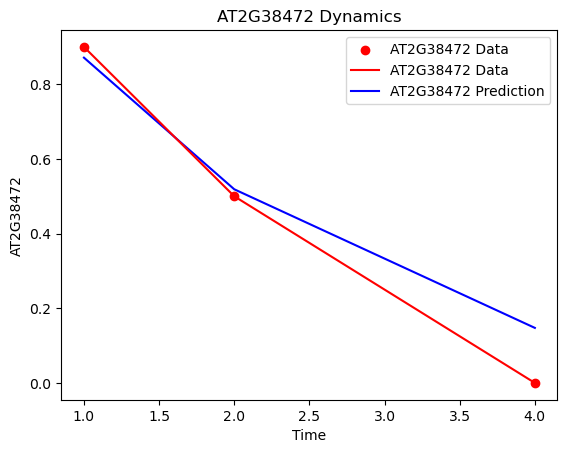

AT2G38473 - Epoch 0, Loss: 3.266108512878418
AT2G38473 - Epoch 100, Loss: 0.0002472461783327162
AT2G38473 - Epoch 200, Loss: 5.121547019371064e-06


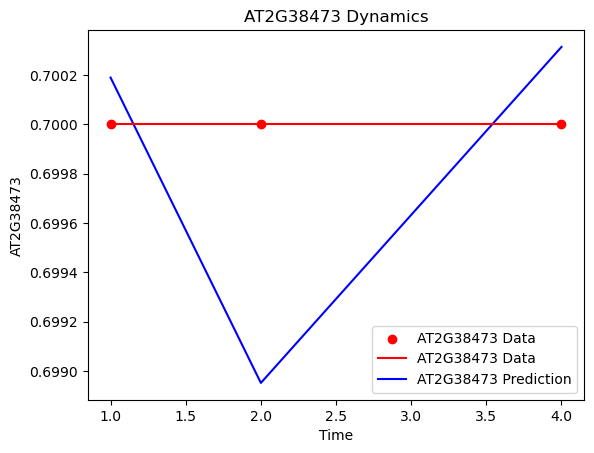

AT2G38474 - Epoch 0, Loss: 0.8318026065826416
AT2G38474 - Epoch 100, Loss: 0.07365987449884415
AT2G38474 - Epoch 200, Loss: 0.04290496185421944


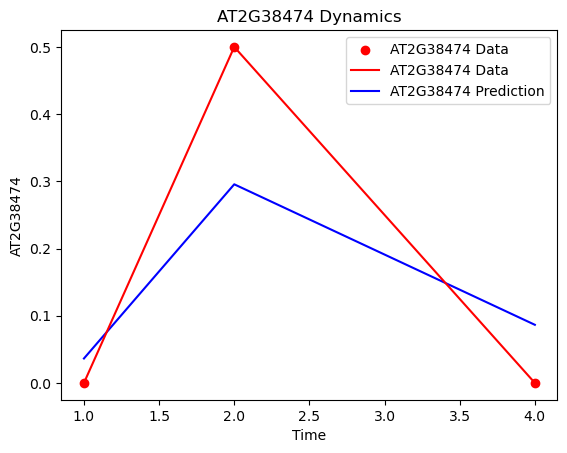

AT2G38470 - Epoch 0, Loss: 1.854132890701294
AT2G38470 - Epoch 100, Loss: 6.250560545595363e-05
AT2G38470 - Epoch 200, Loss: 1.5011372852313798e-05


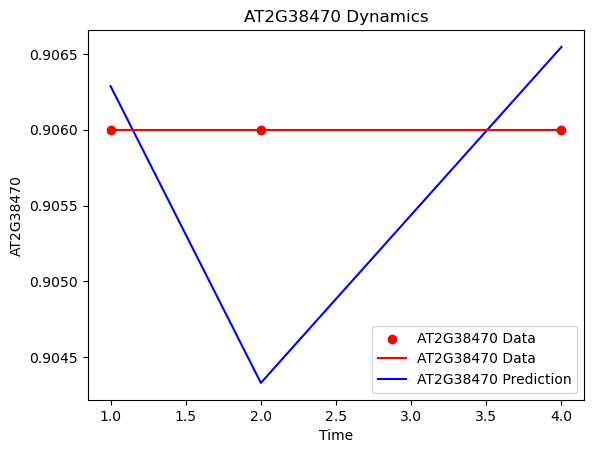

AT5G40100: k = -0.000002, c = 0.365790
AT1G06930: k = 0.006959, c = 0.023655
AT1G04470: k = 0.002592, c = 0.039623
AT5G66730: k = 1.382991, c = 0.033429
AT2G38471: k = 1.215201, c = 0.614414
AT2G38472: k = 0.525844, c = 0.128176
AT2G38473: k = 1.082227, c = 0.758463
AT2G38474: k = 1.100675, c = 0.138409
AT2G38470: k = 1.002367, c = 0.908995


In [13]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define the neural network
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(2, 50),  # Input: time (t) and current value (y)
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)  # Single output: dy/dt
        )
        # Trainable parameters (optional - remove if you want the NN to learn everything)
        self.k = nn.Parameter(torch.tensor(1.0, requires_grad=True))
        self.c = nn.Parameter(torch.tensor(1.0, requires_grad=True))  #Added C parameter

    def forward(self, t, y):
        # Concatenate time and current value for input
        input_tensor = torch.cat((t, y), dim=1)
        return self.hidden(input_tensor)

# Define the ODE loss function
def loss_fn(model, t, y_data):
    #Initial guess for the value of y
    y_pred = model(t, torch.ones_like(t) * y_data[0]).squeeze()

    # Compute derivatives
    y_t = torch.autograd.grad(y_pred, t, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]

    #Initial conditions  
    initial_condition_loss = (y_pred[0] - y_data[0])**2
    
    # Predicted values based on NeuralODE
    ode_residual = y_t + model.k * y_pred - model.c

    # Physics loss
    physics_loss = torch.mean(ode_residual**2)

    # Data loss
    data_loss = torch.mean((y_pred - y_data)**2)

    return data_loss + 1.0 * physics_loss + initial_condition_loss

# Data: Replace with the given dataset
data = {
    "AT5G40100": [-0.44796003, -0.560154646, -5.091964284],
    "AT1G06930": [1.778358524, 0, 0],
    "AT1G04470": [0, 1.175149691, 0],
    "AT5G66730": [0.055374646, 0.098434984, -0.101756864],
    "AT2G38471": [0.505, 0.505, 0.505],
    "AT2G38472": [0.9, 0.5, 0],
    "AT2G38473": [0.7, 0.7, 0.7],
    "AT2G38474": [0, 0.5, 0],
    "AT2G38470": [0.906000416, 0.906000416, 0.906000416]
}

# Time points
time_points = torch.tensor([[1.0], [2.0], [4.0]], requires_grad=True)

# Initialize results
results = {}

for gene, values in data.items():
    y_data = torch.tensor(values, dtype=torch.float32)

    # Initialize model and optimizer
    model = NeuralNet()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # Training loop
    for epoch in range(300):
        optimizer.zero_grad()
        loss = loss_fn(model, time_points, y_data)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"{gene} - Epoch {epoch}, Loss: {loss.item()}")

    # Save the learned parameters
    results[gene] = {
        "k": model.k.item(),
        "c": model.c.item()
    }

    # Generate predictions for plotting
    # t_test = torch.linspace(1.0, 4.0, 100).view(-1, 1).requires_grad_(True)
    
    # Need to provide the corresponding y values for the test times
    # y_test = model(t_test, torch.ones_like(t_test) * y_data[0]).detach().numpy()
    y_test = model(time_points, torch.ones_like(time_points) * y_data[0]).detach().numpy()

    # Plotting the results
    plt.figure()
    plt.scatter(time_points.detach().numpy(), y_data.numpy(), color='red', label=f'{gene} Data', zorder=5)
    plt.plot(time_points.detach().numpy(),  y_data.numpy(), color='red', label=f'{gene} Data', zorder=5)

    plt.plot(time_points.detach().numpy(), y_test, label=f'{gene} Prediction', color='blue', zorder=4)

    # plt.plot(t_test.detach().numpy(), y_test, label=f'{gene} Prediction', color='blue', zorder=4)
    plt.title(f'{gene} Dynamics')
    plt.xlabel('Time')
    plt.ylabel(gene)
    plt.legend()
    plt.show()

# Print results
for gene, params in results.items():
    print(f"{gene}: k = {params['k']:.6f}, c = {params['c']:.6f}")


# inverse pinn    
    
    # Enforce that dy/dt equals the parametric ODE: α + β*y(t) + γ*t


AT5G40100 - Epoch 0, Loss: 25.7132
AT5G40100 - Epoch 100, Loss: 0.2850
AT5G40100 - Epoch 200, Loss: 0.0480


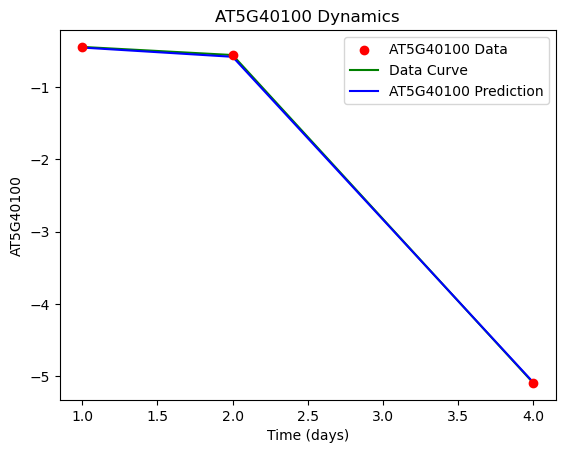

AT1G06930 - Epoch 0, Loss: 17.2140
AT1G06930 - Epoch 100, Loss: 0.3724
AT1G06930 - Epoch 200, Loss: 0.0098


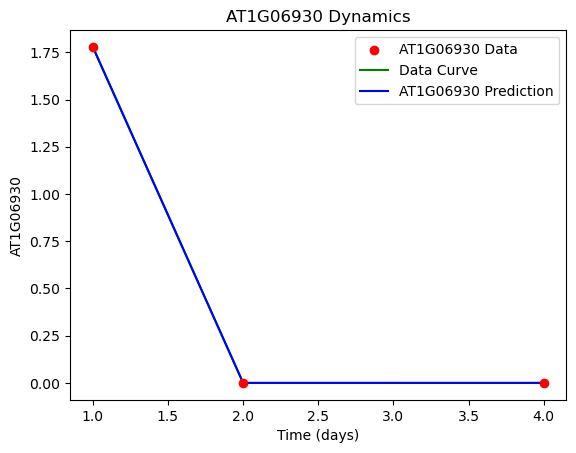

AT1G04470 - Epoch 0, Loss: 15.2237
AT1G04470 - Epoch 100, Loss: 0.7814
AT1G04470 - Epoch 200, Loss: 0.0001


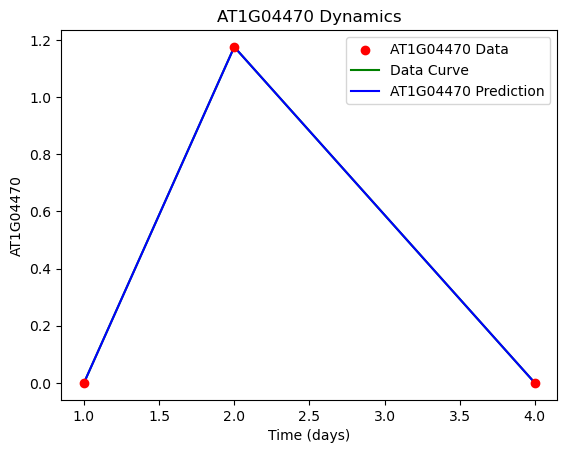

AT5G66730 - Epoch 0, Loss: 12.9452
AT5G66730 - Epoch 100, Loss: 0.4047
AT5G66730 - Epoch 200, Loss: 0.0494


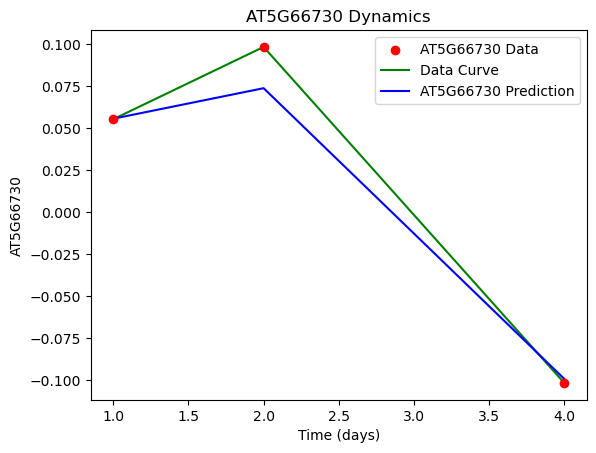

AT2G38471 - Epoch 0, Loss: 13.5810
AT2G38471 - Epoch 100, Loss: 0.8723
AT2G38471 - Epoch 200, Loss: 0.0305


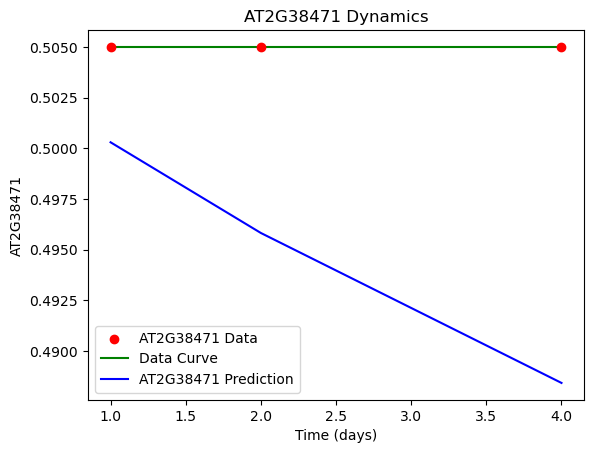

AT2G38472 - Epoch 0, Loss: 14.4664
AT2G38472 - Epoch 100, Loss: 0.7293
AT2G38472 - Epoch 200, Loss: 0.1315


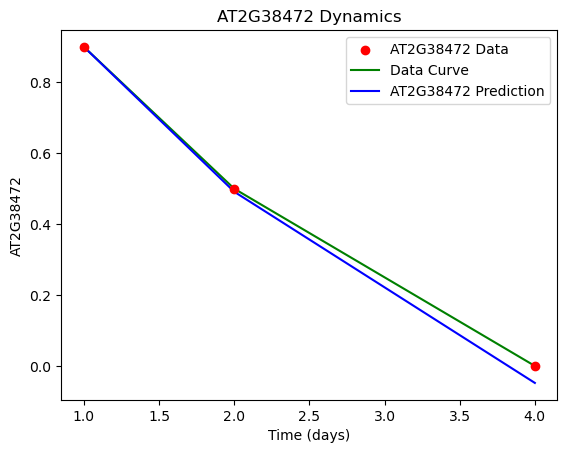

AT2G38473 - Epoch 0, Loss: 13.9367
AT2G38473 - Epoch 100, Loss: 0.3973
AT2G38473 - Epoch 200, Loss: 0.0012


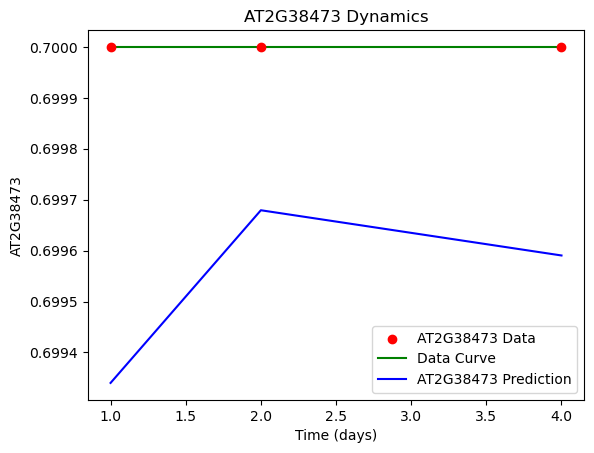

AT2G38474 - Epoch 0, Loss: 10.9307
AT2G38474 - Epoch 100, Loss: 0.6118
AT2G38474 - Epoch 200, Loss: 0.0005


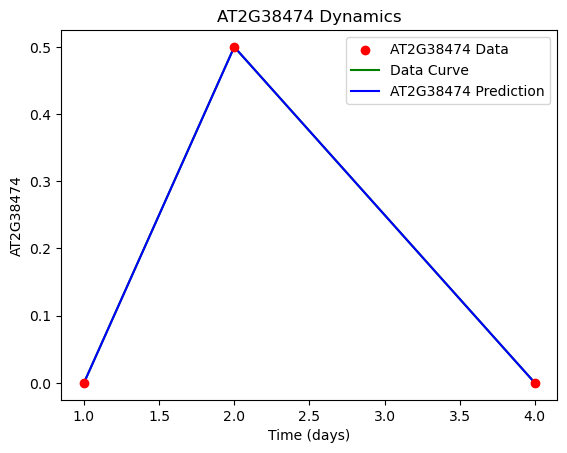

AT2G38470 - Epoch 0, Loss: 15.2315
AT2G38470 - Epoch 100, Loss: 1.0219
AT2G38470 - Epoch 200, Loss: 0.0014


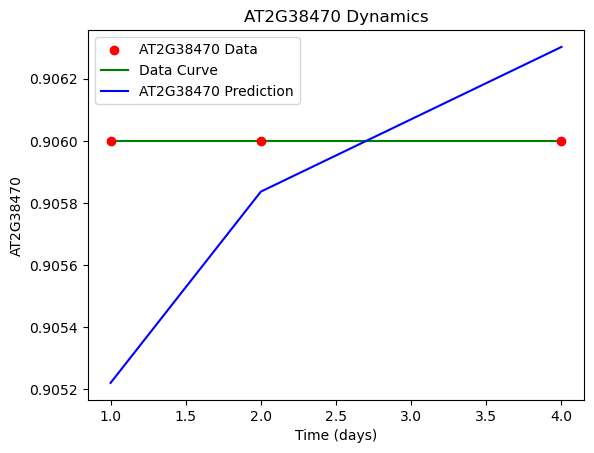

AT5G40100: alpha = 0.112740, beta = 1.516057, gamma = 0.359451
AT1G06930: alpha = 0.319285, beta = 1.604944, gamma = 0.267496
AT1G04470: alpha = 0.191624, beta = 1.546130, gamma = 0.206522
AT5G66730: alpha = 0.123097, beta = 1.664295, gamma = 0.093864
AT2G38471: alpha = 0.123063, beta = 1.595388, gamma = 0.032340
AT2G38472: alpha = 0.083827, beta = 1.686953, gamma = -0.010964
AT2G38473: alpha = 0.308304, beta = 1.521022, gamma = 0.273150
AT2G38474: alpha = 0.160442, beta = 1.658340, gamma = 0.125537
AT2G38470: alpha = 0.133498, beta = 1.489928, gamma = 0.122548


In [16]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define the neural network that approximates y(t)
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        # Here we still model y(t) with a neural network
        self.hidden = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)  # Output: y(t)
        )
        # Learnable ODE parameters for: dy/dt = α + β*y(t) + γ*t
        self.alpha = nn.Parameter(torch.tensor(1.0, requires_grad=True))
        self.beta  = nn.Parameter(torch.tensor(1.0, requires_grad=True))
        self.gamma = nn.Parameter(torch.tensor(1.0, requires_grad=True))

    def forward(self, t):
        return self.hidden(t)

# Define the ODE loss function
def loss_fn(model, t, y_data):
    # Predict y(t) using the neural network; shape: (num_time_points,)
    y_pred = model(t).squeeze()
    
    # Compute dy/dt via autograd
    y_t = torch.autograd.grad(
        y_pred, t, 
        grad_outputs=torch.ones_like(y_pred), 
        create_graph=True
    )[0].squeeze()
    
    # Enforce that dy/dt equals the parametric ODE: α + β*y(t) + γ*t
    # Note: squeeze t to match y_pred's shape.
    ode_residual = y_t - (model.alpha + model.beta * y_pred + model.gamma * t.squeeze())
    
    physics_loss = torch.mean(ode_residual**2)
    data_loss = torch.mean((y_pred - y_data)**2)
    
    # Also enforce the initial condition (at the first time point)
    initial_condition_loss = (y_pred[0] - y_data[0])**2
    
    return data_loss + physics_loss + initial_condition_loss

# Data: Each gene has expression values at Day1, Day2, Day4
data = {
    "AT5G40100": [-0.44796003, -0.560154646, -5.091964284],
    "AT1G06930": [1.778358524, 0, 0],
    "AT1G04470": [0, 1.175149691, 0],
    "AT5G66730": [0.055374646, 0.098434984, -0.101756864],
    "AT2G38471": [0.505, 0.505, 0.505],
    "AT2G38472": [0.9, 0.5, 0],
    "AT2G38473": [0.7, 0.7, 0.7],
    "AT2G38474": [0, 0.5, 0],
    "AT2G38470": [0.906000416, 0.906000416, 0.906000416]
}

# Time points as a tensor: shape (3, 1)
time_points = torch.tensor([[1.0], [2.0], [4.0]], dtype=torch.float32, requires_grad=True)

results = {}

# Loop over each gene (each row of the dataset)
for gene, values in data.items():
    y_data = torch.tensor(values, dtype=torch.float32)
    
    # Initialize the neural network model for this gene
    model = NeuralNet()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    # Training loop
    epochs = 300
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = loss_fn(model, time_points, y_data)
        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0:
            print(f"{gene} - Epoch {epoch}, Loss: {loss.item():.4f}")
    
    # Save the learned parameters for this gene
    results[gene] = {
        "alpha": model.alpha.item(),
        "beta": model.beta.item(),
        "gamma": model.gamma.item()
    }
    
    # Generate predictions for plotting over a smooth time grid
    # t_test = torch.linspace(1.0, 4.0, 100).view(-1, 1)
    # y_pred = model(t_test).detach().numpy()
    y_pred = model(time_points).detach().numpy()

    
    # Plot observed data vs. Neural ODE predictions
    plt.figure()
    plt.scatter(time_points.detach().numpy(), y_data.numpy(), color='red', label=f'{gene} Data', zorder=5)
    plt.plot(time_points.detach().numpy(), y_data.numpy(), color='green', label='Data Curve', zorder=3)
    # plt.plot(t_test.detach().numpy(), y_pred, label=f'{gene} Prediction', color='blue', zorder=4)
    plt.plot(time_points.detach().numpy(), y_pred, label=f'{gene} Prediction', color='blue', zorder=4)

    plt.title(f'{gene} Dynamics')
    plt.xlabel('Time (days)')
    plt.ylabel(gene)
    plt.legend()
    plt.show()

# Print the learned parameters for each gene
for gene, params in results.items():
    print(f"{gene}: alpha = {params['alpha']:.6f}, beta = {params['beta']:.6f}, gamma = {params['gamma']:.6f}")


# Inverse PINN


    # Compute the ODE residual:
    # dy/dt should equal α + β*y(t) + γ*(t - t0)
    ode_residual = y_t - (model.alpha + model.beta * y_pred + model.gamma * (t.squeeze() - t0))

AT5G40100 - Epoch 0, Loss: 11.4676
AT5G40100 - Epoch 100, Loss: 0.0611
AT5G40100 - Epoch 200, Loss: 0.0003
AT5G40100 - Epoch 300, Loss: 0.0000
AT5G40100 - Epoch 400, Loss: 0.0000
AT5G40100 - Epoch 500, Loss: 0.0000
AT5G40100 - Epoch 600, Loss: 0.0000
AT5G40100 - Epoch 700, Loss: 0.0000
AT5G40100 - Epoch 800, Loss: 0.0000
AT5G40100 - Epoch 900, Loss: 0.0000


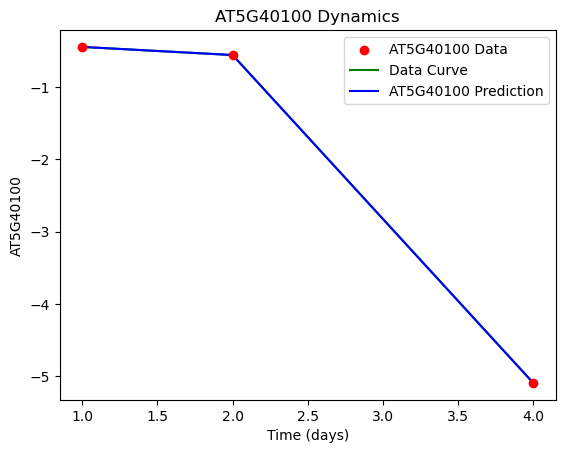

AT1G06930 - Epoch 0, Loss: 7.7146
AT1G06930 - Epoch 100, Loss: 0.1304
AT1G06930 - Epoch 200, Loss: 0.0088
AT1G06930 - Epoch 300, Loss: 0.0014
AT1G06930 - Epoch 400, Loss: 0.0008
AT1G06930 - Epoch 500, Loss: 0.0000
AT1G06930 - Epoch 600, Loss: 0.0000
AT1G06930 - Epoch 700, Loss: 0.0000
AT1G06930 - Epoch 800, Loss: 0.0000
AT1G06930 - Epoch 900, Loss: 0.0000


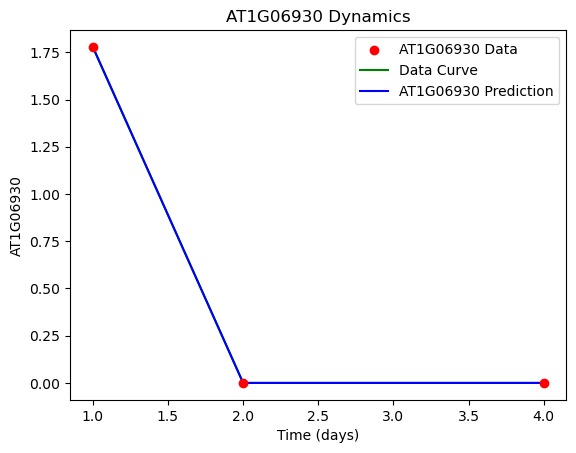

AT1G04470 - Epoch 0, Loss: 3.5805
AT1G04470 - Epoch 100, Loss: 0.0597
AT1G04470 - Epoch 200, Loss: 0.0000
AT1G04470 - Epoch 300, Loss: 0.0000
AT1G04470 - Epoch 400, Loss: 0.0000
AT1G04470 - Epoch 500, Loss: 0.0000
AT1G04470 - Epoch 600, Loss: 0.0000
AT1G04470 - Epoch 700, Loss: 0.0004
AT1G04470 - Epoch 800, Loss: 0.0000
AT1G04470 - Epoch 900, Loss: 0.0000


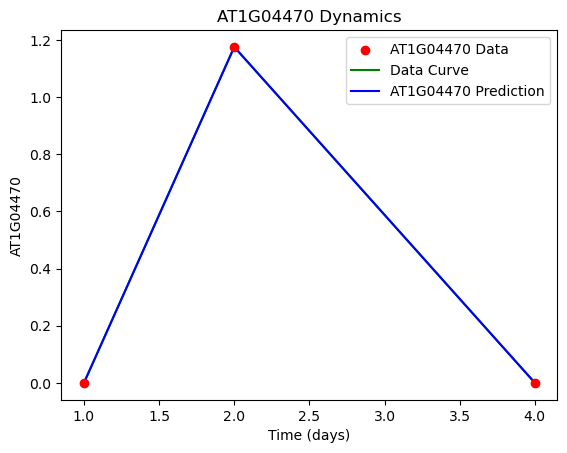

AT5G66730 - Epoch 0, Loss: 2.2148
AT5G66730 - Epoch 100, Loss: 0.0883
AT5G66730 - Epoch 200, Loss: 0.0072
AT5G66730 - Epoch 300, Loss: 0.0000
AT5G66730 - Epoch 400, Loss: 0.0000
AT5G66730 - Epoch 500, Loss: 0.0000
AT5G66730 - Epoch 600, Loss: 0.0000
AT5G66730 - Epoch 700, Loss: 0.0000
AT5G66730 - Epoch 800, Loss: 0.0000
AT5G66730 - Epoch 900, Loss: 0.0000


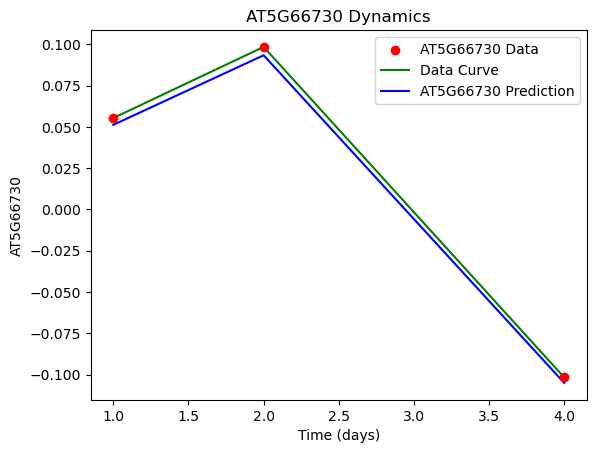

AT2G38471 - Epoch 0, Loss: 3.2245
AT2G38471 - Epoch 100, Loss: 0.3538
AT2G38471 - Epoch 200, Loss: 0.0396
AT2G38471 - Epoch 300, Loss: 0.0008
AT2G38471 - Epoch 400, Loss: 0.0000
AT2G38471 - Epoch 500, Loss: 0.0000
AT2G38471 - Epoch 600, Loss: 0.0042
AT2G38471 - Epoch 700, Loss: 0.0000
AT2G38471 - Epoch 800, Loss: 0.0000
AT2G38471 - Epoch 900, Loss: 0.0000


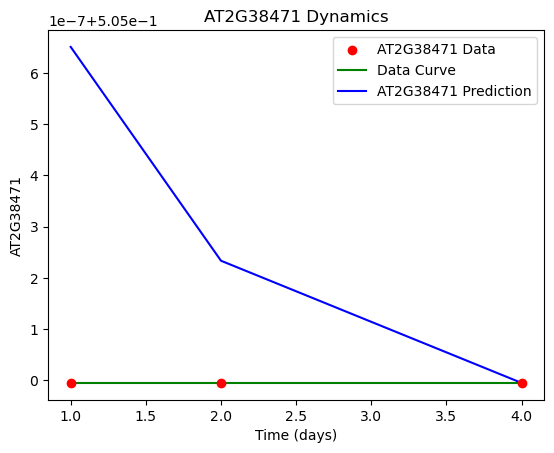

AT2G38472 - Epoch 0, Loss: 4.1150
AT2G38472 - Epoch 100, Loss: 0.2508
AT2G38472 - Epoch 200, Loss: 0.0457
AT2G38472 - Epoch 300, Loss: 0.0006
AT2G38472 - Epoch 400, Loss: 0.0000
AT2G38472 - Epoch 500, Loss: 0.0000
AT2G38472 - Epoch 600, Loss: 0.0000
AT2G38472 - Epoch 700, Loss: 0.0000
AT2G38472 - Epoch 800, Loss: 0.0000
AT2G38472 - Epoch 900, Loss: 0.0003


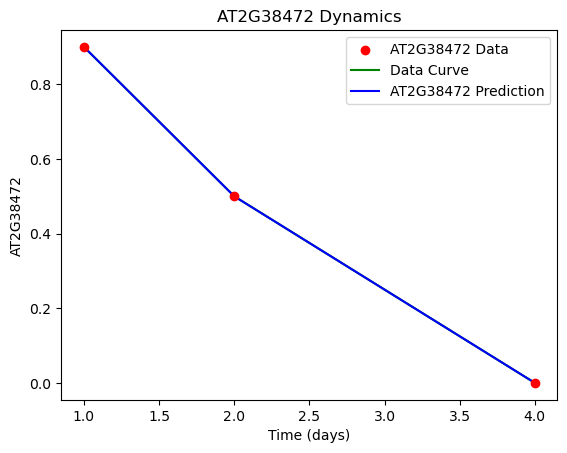

AT2G38473 - Epoch 0, Loss: 3.8737
AT2G38473 - Epoch 100, Loss: 0.1972
AT2G38473 - Epoch 200, Loss: 0.0014
AT2G38473 - Epoch 300, Loss: 0.0004
AT2G38473 - Epoch 400, Loss: 0.0001
AT2G38473 - Epoch 500, Loss: 0.0000
AT2G38473 - Epoch 600, Loss: 0.0000
AT2G38473 - Epoch 700, Loss: 0.0048
AT2G38473 - Epoch 800, Loss: 0.0000
AT2G38473 - Epoch 900, Loss: 0.0001


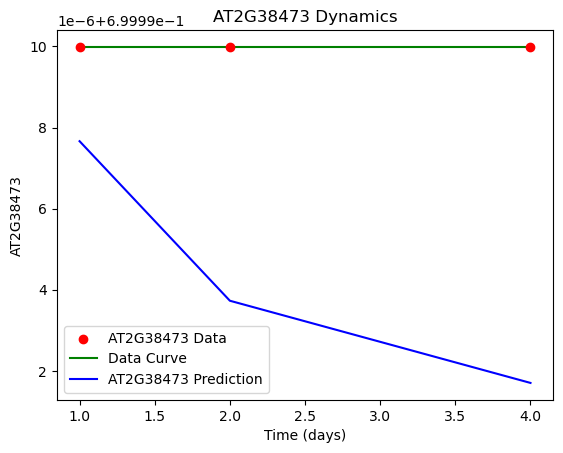

AT2G38474 - Epoch 0, Loss: 2.5563
AT2G38474 - Epoch 100, Loss: 0.2017
AT2G38474 - Epoch 200, Loss: 0.0018
AT2G38474 - Epoch 300, Loss: 0.0000
AT2G38474 - Epoch 400, Loss: 0.0000
AT2G38474 - Epoch 500, Loss: 0.0000
AT2G38474 - Epoch 600, Loss: 0.0000
AT2G38474 - Epoch 700, Loss: 0.0000
AT2G38474 - Epoch 800, Loss: 0.0000
AT2G38474 - Epoch 900, Loss: 0.0000


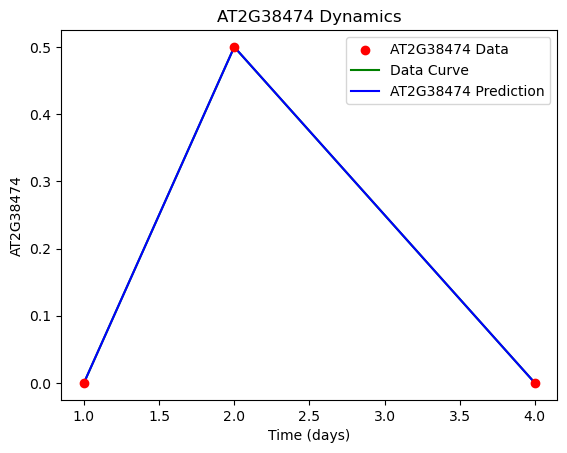

AT2G38470 - Epoch 0, Loss: 4.2897
AT2G38470 - Epoch 100, Loss: 0.1602
AT2G38470 - Epoch 200, Loss: 0.0000
AT2G38470 - Epoch 300, Loss: 0.0001
AT2G38470 - Epoch 400, Loss: 0.0000
AT2G38470 - Epoch 500, Loss: 0.0000
AT2G38470 - Epoch 600, Loss: 0.0000
AT2G38470 - Epoch 700, Loss: 0.0000
AT2G38470 - Epoch 800, Loss: 0.0000
AT2G38470 - Epoch 900, Loss: 0.0025


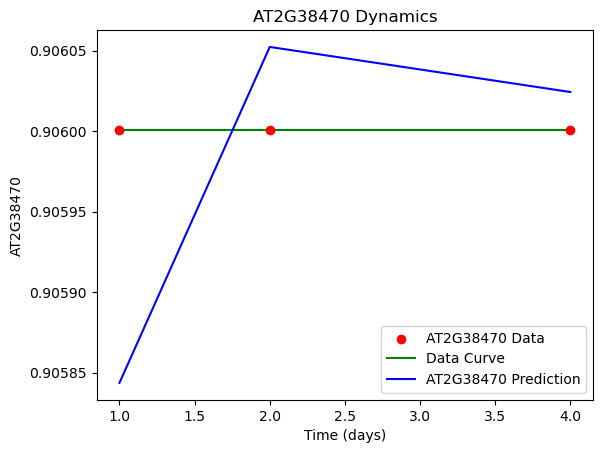

AT5G40100: alpha = 0.872972, beta = 0.956407, gamma = 0.940599
AT1G06930: alpha = 0.123124, beta = 1.450757, gamma = -0.065496
AT1G04470: alpha = 0.263439, beta = 1.579390, gamma = 0.212122
AT5G66730: alpha = 0.025756, beta = 1.719236, gamma = 0.144708
AT2G38471: alpha = -0.213872, beta = 1.176155, gamma = -0.032467
AT2G38472: alpha = -0.037305, beta = 1.557610, gamma = 0.118416
AT2G38473: alpha = 0.122398, beta = 1.049204, gamma = 0.212365
AT2G38474: alpha = 0.046065, beta = 1.709472, gamma = 0.038393
AT2G38470: alpha = 0.119745, beta = 0.282835, gamma = 0.114828


In [15]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define the neural network that approximates y(t)
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)  # Approximates y(t)
        )
        # Learnable ODE parameters for: dy/dt = α + β*y(t) + γ*(t - t0)
        self.alpha = nn.Parameter(torch.tensor(1.0, requires_grad=True))
        self.beta  = nn.Parameter(torch.tensor(1.0, requires_grad=True))
        self.gamma = nn.Parameter(torch.tensor(1.0, requires_grad=True))

    def forward(self, t):
        return self.hidden(t)

# Calculate the mean of the time points (t0)
t0_value = np.mean([1.0, 2.0, 4.0])
t0 = torch.tensor(t0_value, dtype=torch.float32)

# Define the ODE loss function
def loss_fn(model, t, y_data):
    # Predict y(t); shape: (num_time_points,)
    y_pred = model(t).squeeze()
    
    # Compute derivative dy/dt via autograd
    y_t = torch.autograd.grad(
        y_pred, t, grad_outputs=torch.ones_like(y_pred), create_graph=True
    )[0].squeeze()
    
    # Compute the ODE residual:
    # dy/dt should equal α + β*y(t) + γ*(t - t0)
    ode_residual = y_t - (model.alpha + model.beta * y_pred + model.gamma * (t.squeeze() - t0))
    
    physics_loss = torch.mean(ode_residual**2)
    data_loss = torch.mean((y_pred - y_data)**2)
    
    # Enforce the initial condition explicitly
    initial_condition_loss = (y_pred[0] - y_data[0])**2
    
    return data_loss + physics_loss + initial_condition_loss

# Data: Each gene has expression values at Day1, Day2, Day4
data = {
    "AT5G40100": [-0.44796003, -0.560154646, -5.091964284],
    "AT1G06930": [1.778358524, 0, 0],
    "AT1G04470": [0, 1.175149691, 0],
    "AT5G66730": [0.055374646, 0.098434984, -0.101756864],
    "AT2G38471": [0.505, 0.505, 0.505],
    "AT2G38472": [0.9, 0.5, 0],
    "AT2G38473": [0.7, 0.7, 0.7],
    "AT2G38474": [0, 0.5, 0],
    "AT2G38470": [0.906000416, 0.906000416, 0.906000416]
}

# Time points as a tensor: shape (3, 1)
time_points = torch.tensor([[1.0], [2.0], [4.0]], dtype=torch.float32, requires_grad=True)

results = {}

# Loop over each gene (each row is a time series for one gene)
for gene, values in data.items():
    y_data = torch.tensor(values, dtype=torch.float32)
    
    # Initialize the model and optimizer for this gene
    model = NeuralNet()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    # Training loop
    epochs = 1000
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = loss_fn(model, time_points, y_data)
        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0:
            print(f"{gene} - Epoch {epoch}, Loss: {loss.item():.4f}")
    
    # Save learned parameters
    results[gene] = {
        "alpha": model.alpha.item(),
        "beta": model.beta.item(),
        "gamma": model.gamma.item()
    }
    
    # Generate predictions over a smooth time grid for plotting
    # t_test = torch.linspace(1.0, 4.0, 100).view(-1, 1)
    # y_pred = model(t_test).detach().numpy()
    y_pred = model(time_points).detach().numpy()


    
    # Plot observed data vs. Neural ODE predictions
    plt.figure()
    plt.scatter(time_points.detach().numpy(), y_data.numpy(), color='red', label=f'{gene} Data', zorder=5)
    plt.plot(time_points.detach().numpy(), y_data.numpy(), color='green', label='Data Curve', zorder=3)
    # plt.plot(t_test.detach().numpy(), y_pred, label=f'{gene} Prediction', color='blue', zorder=4)
    plt.plot(time_points.detach().numpy(), y_pred, label=f'{gene} Prediction', color='blue', zorder=4)

    plt.title(f'{gene} Dynamics')
    plt.xlabel('Time (days)')
    plt.ylabel(gene)
    plt.legend()
    plt.show()

# Print learned parameters for each gene
for gene, params in results.items():
    print(f"{gene}: alpha = {params['alpha']:.6f}, beta = {params['beta']:.6f}, gamma = {params['gamma']:.6f}")


# INVERSE PINN

    # Compute the ODE residual:
    # dy/dt should equal α + β*y(t) + γ*(t - t0)
    ode_residual = y_t - (model.alpha + model.beta * y_pred + model.gamma * (t.squeeze() - t0))

AT5G66730 - Epoch 0, Loss: 2.3796
AT5G66730 - Epoch 100, Loss: 0.0924
AT5G66730 - Epoch 200, Loss: 0.0092
AT5G66730 - Epoch 300, Loss: 0.0020
AT5G66730 - Epoch 400, Loss: 0.0003
AT5G66730 - Epoch 500, Loss: 0.0000
AT5G66730 - Epoch 600, Loss: 0.0000
AT5G66730 - Epoch 700, Loss: 0.0000
AT5G66730 - Epoch 800, Loss: 0.0000
AT5G66730 - Epoch 900, Loss: 0.0000
AT5G66730 - Epoch 1000, Loss: 0.0000
AT5G66730 - Epoch 1100, Loss: 0.0000
AT5G66730 - Epoch 1200, Loss: 0.0000
AT5G66730 - Epoch 1300, Loss: 0.0000
AT5G66730 - Epoch 1400, Loss: 0.0002
AT5G66730 - Epoch 1500, Loss: 0.0000
AT5G66730 - Epoch 1600, Loss: 0.0000
AT5G66730 - Epoch 1700, Loss: 0.0000
AT5G66730 - Epoch 1800, Loss: 0.0000
AT5G66730 - Epoch 1900, Loss: 0.0000
AT5G66730 - Epoch 2000, Loss: 0.0000
AT5G66730 - Epoch 2100, Loss: 0.0000
AT5G66730 - Epoch 2200, Loss: 0.0001
AT5G66730 - Epoch 2300, Loss: 0.0000
AT5G66730 - Epoch 2400, Loss: 0.0000
AT5G66730 - Epoch 2500, Loss: 0.0000
AT5G66730 - Epoch 2600, Loss: 0.0000
AT5G66730 - E

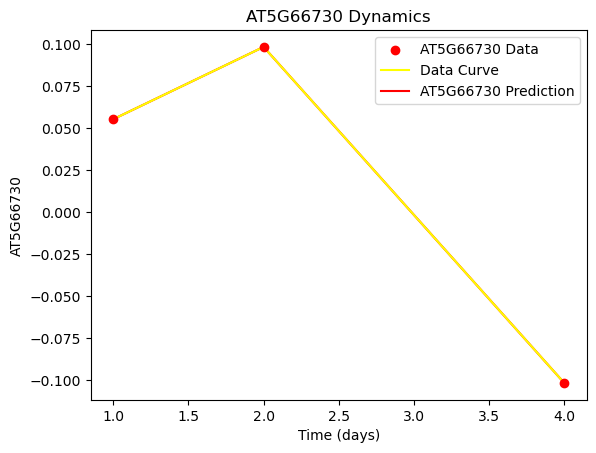

AT2G38471 - Epoch 0, Loss: 2.9463
AT2G38471 - Epoch 100, Loss: 0.4482
AT2G38471 - Epoch 200, Loss: 0.0384
AT2G38471 - Epoch 300, Loss: 0.0025
AT2G38471 - Epoch 400, Loss: 0.0000
AT2G38471 - Epoch 500, Loss: 0.0000
AT2G38471 - Epoch 600, Loss: 0.0000
AT2G38471 - Epoch 700, Loss: 0.0000
AT2G38471 - Epoch 800, Loss: 0.0000
AT2G38471 - Epoch 900, Loss: 0.0000
AT2G38471 - Epoch 1000, Loss: 0.0000
AT2G38471 - Epoch 1100, Loss: 0.0000
AT2G38471 - Epoch 1200, Loss: 0.0000
AT2G38471 - Epoch 1300, Loss: 0.0000
AT2G38471 - Epoch 1400, Loss: 0.0000
AT2G38471 - Epoch 1500, Loss: 0.0000
AT2G38471 - Epoch 1600, Loss: 0.0044
AT2G38471 - Epoch 1700, Loss: 0.0000
AT2G38471 - Epoch 1800, Loss: 0.0000
AT2G38471 - Epoch 1900, Loss: 0.0000
AT2G38471 - Epoch 2000, Loss: 0.0000
AT2G38471 - Epoch 2100, Loss: 0.0000
AT2G38471 - Epoch 2200, Loss: 0.0000
AT2G38471 - Epoch 2300, Loss: 0.0000
AT2G38471 - Epoch 2400, Loss: 0.0000
AT2G38471 - Epoch 2500, Loss: 0.0000
AT2G38471 - Epoch 2600, Loss: 0.0000
AT2G38471 - E

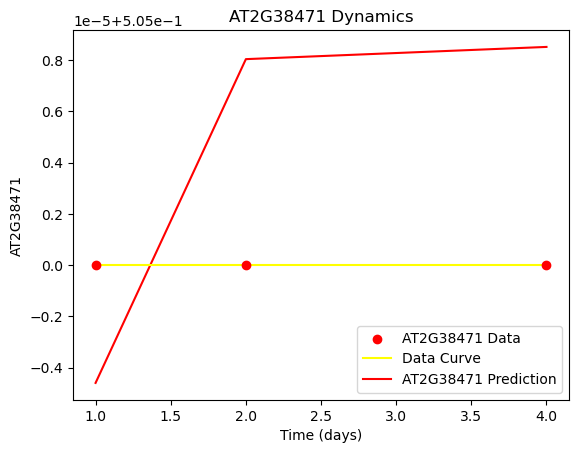

AT2G38473 - Epoch 0, Loss: 4.4507
AT2G38473 - Epoch 100, Loss: 0.3691
AT2G38473 - Epoch 200, Loss: 0.0002
AT2G38473 - Epoch 300, Loss: 0.0000
AT2G38473 - Epoch 400, Loss: 0.0000
AT2G38473 - Epoch 500, Loss: 0.0000
AT2G38473 - Epoch 600, Loss: 0.0000
AT2G38473 - Epoch 700, Loss: 0.0000
AT2G38473 - Epoch 800, Loss: 0.0001
AT2G38473 - Epoch 900, Loss: 0.0000
AT2G38473 - Epoch 1000, Loss: 0.0000
AT2G38473 - Epoch 1100, Loss: 0.0003
AT2G38473 - Epoch 1200, Loss: 0.0000
AT2G38473 - Epoch 1300, Loss: 0.0000
AT2G38473 - Epoch 1400, Loss: 0.0000
AT2G38473 - Epoch 1500, Loss: 0.0000
AT2G38473 - Epoch 1600, Loss: 0.0000
AT2G38473 - Epoch 1700, Loss: 0.0000
AT2G38473 - Epoch 1800, Loss: 0.0000
AT2G38473 - Epoch 1900, Loss: 0.0000
AT2G38473 - Epoch 2000, Loss: 0.0000
AT2G38473 - Epoch 2100, Loss: 0.0000
AT2G38473 - Epoch 2200, Loss: 0.0000
AT2G38473 - Epoch 2300, Loss: 0.0000
AT2G38473 - Epoch 2400, Loss: 0.0000
AT2G38473 - Epoch 2500, Loss: 0.0000
AT2G38473 - Epoch 2600, Loss: 0.0000
AT2G38473 - E

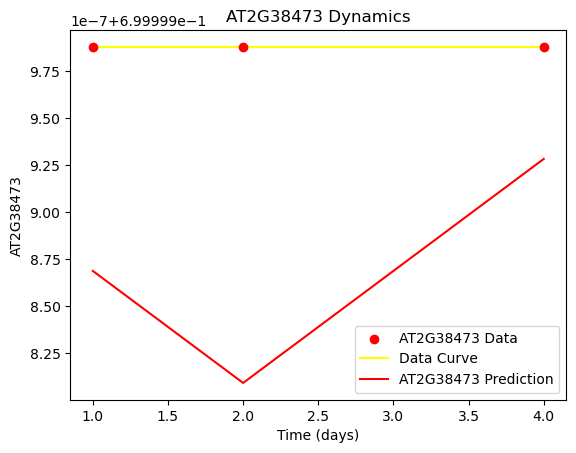

AT2G38470 - Epoch 0, Loss: 4.9440
AT2G38470 - Epoch 100, Loss: 0.1027
AT2G38470 - Epoch 200, Loss: 0.0004
AT2G38470 - Epoch 300, Loss: 0.0003
AT2G38470 - Epoch 400, Loss: 0.0004
AT2G38470 - Epoch 500, Loss: 0.0000
AT2G38470 - Epoch 600, Loss: 0.0000
AT2G38470 - Epoch 700, Loss: 0.0000
AT2G38470 - Epoch 800, Loss: 0.0000
AT2G38470 - Epoch 900, Loss: 0.0000
AT2G38470 - Epoch 1000, Loss: 0.0000
AT2G38470 - Epoch 1100, Loss: 0.0000
AT2G38470 - Epoch 1200, Loss: 0.0000
AT2G38470 - Epoch 1300, Loss: 0.0000
AT2G38470 - Epoch 1400, Loss: 0.0000
AT2G38470 - Epoch 1500, Loss: 0.0000
AT2G38470 - Epoch 1600, Loss: 0.0006
AT2G38470 - Epoch 1700, Loss: 0.0000
AT2G38470 - Epoch 1800, Loss: 0.0000
AT2G38470 - Epoch 1900, Loss: 0.0000
AT2G38470 - Epoch 2000, Loss: 0.0000
AT2G38470 - Epoch 2100, Loss: 0.0000
AT2G38470 - Epoch 2200, Loss: 0.0000
AT2G38470 - Epoch 2300, Loss: 0.0003
AT2G38470 - Epoch 2400, Loss: 0.0000
AT2G38470 - Epoch 2500, Loss: 0.0000
AT2G38470 - Epoch 2600, Loss: 0.0000
AT2G38470 - E

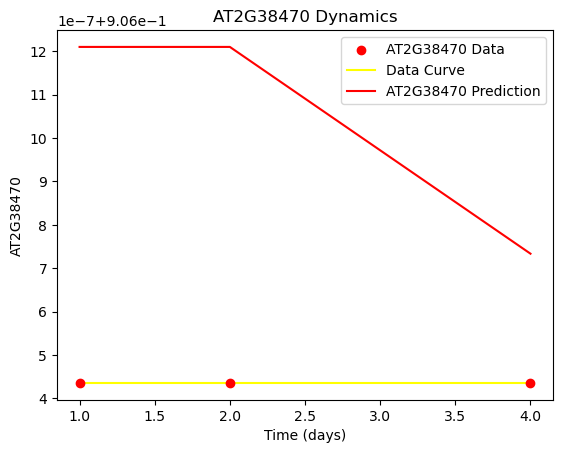

AT5G66730: alpha = 0.011871, beta = 1.506187, gamma = 0.075859
AT2G38471: alpha = -0.398005, beta = 0.806494, gamma = -0.006974
AT2G38473: alpha = -0.154487, beta = 0.181569, gamma = 0.003686
AT2G38470: alpha = 0.051242, beta = -0.055033, gamma = 0.001685


In [23]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define the neural network that approximates y(t)
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)  # Approximates y(t)
        )
        # Learnable ODE parameters for: dy/dt = α + β*y(t) + γ*(t - t0)
        self.alpha = nn.Parameter(torch.tensor(1.0, requires_grad=True))
        self.beta  = nn.Parameter(torch.tensor(1.0, requires_grad=True))
        self.gamma = nn.Parameter(torch.tensor(1.0, requires_grad=True))

    def forward(self, t):
        return self.hidden(t)

# Calculate the mean of the time points (t0)
t0_value = np.mean([1.0, 2.0, 4.0])
t0 = torch.tensor(t0_value, dtype=torch.float32)

# Define the ODE loss function
def loss_fn(model, t, y_data):
    # Predict y(t); shape: (num_time_points,)
    y_pred = model(t).squeeze()
    
    # Compute derivative dy/dt via autograd
    y_t = torch.autograd.grad(
        y_pred, t, grad_outputs=torch.ones_like(y_pred), create_graph=True
    )[0].squeeze()
    
    # Compute the ODE residual:
    # dy/dt should equal α + β*y(t) + γ*(t - t0)
    ode_residual = y_t - (model.alpha + model.beta * y_pred + model.gamma * (t.squeeze() - t0))
    
    physics_loss = torch.mean(ode_residual**2)
    data_loss = torch.mean((y_pred - y_data)**2)
    
    # Enforce the initial condition explicitly
    initial_condition_loss = (y_pred[0] - y_data[0])**2
    
    return data_loss + physics_loss + initial_condition_loss

# Data: Each gene has expression values at Day1, Day2, Day4
data = {
    # "AT5G40100": [-0.44796003, -0.560154646, -5.091964284],
    # "AT1G06930": [1.778358524, 0, 0],
    # "AT1G04470": [0, 1.175149691, 0],
    "AT5G66730": [0.055374646, 0.098434984, -0.101756864],
    "AT2G38471": [0.505, 0.505, 0.505],
    # "AT2G38472": [0.9, 0.5, 0],
    "AT2G38473": [0.7, 0.7, 0.7],
    # "AT2G38474": [0, 0.5, 0],
    "AT2G38470": [0.906000416, 0.906000416, 0.906000416]
}

# Time points as a tensor: shape (3, 1)
time_points = torch.tensor([[1.0], [2.0], [4.0]], dtype=torch.float32, requires_grad=True)

results = {}

# Loop over each gene (each row is a time series for one gene)
for gene, values in data.items():
    y_data = torch.tensor(values, dtype=torch.float32)
    
    # Initialize the model and optimizer for this gene
    model = NeuralNet()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    # Training loop
    epochs = 10000
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = loss_fn(model, time_points, y_data)
        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0:
            print(f"{gene} - Epoch {epoch}, Loss: {loss.item():.4f}")
    
    # Save learned parameters
    results[gene] = {
        "alpha": model.alpha.item(),
        "beta": model.beta.item(),
        "gamma": model.gamma.item()
    }
    
    # Generate predictions over a smooth time grid for plotting
    # t_test = torch.linspace(1.0, 4.0, 100).view(-1, 1)
    # y_pred = model(t_test).detach().numpy()
    y_pred = model(time_points).detach().numpy()


    
    # Plot observed data vs. Neural ODE predictions
    plt.figure()
    plt.scatter(time_points.detach().numpy(), y_data.numpy(), color='red', label=f'{gene} Data', zorder=5)
    plt.plot(time_points.detach().numpy(), y_data.numpy(), color='yellow', label='Data Curve', zorder=4)
    # plt.plot(t_test.detach().numpy(), y_pred, label=f'{gene} Prediction', color='blue', zorder=4)

    plt.plot(time_points.detach().numpy(), y_pred, 'r-', label=f'{gene} Prediction', zorder=3)


    plt.title(f'{gene} Dynamics')
    plt.xlabel('Time (days)')
    plt.ylabel(gene)
    plt.legend()
    plt.show()

# Print learned parameters for each gene
for gene, params in results.items():
    print(f"{gene}: alpha = {params['alpha']:.6f}, beta = {params['beta']:.6f}, gamma = {params['gamma']:.6f}")


# Automatically discovering ordinary differential
 equations from data with sparse regression to define the ODE

In [79]:
!pip install pysindy

   ---------------------------------------- 0.0/121.0 kB ? eta -:--:--
   --- ------------------------------------ 10.2/121.0 kB ? eta -:--:--
   ------------- ------------------------- 41.0/121.0 kB 487.6 kB/s eta 0:00:01
   ----------------------- --------------- 71.7/121.0 kB 558.5 kB/s eta 0:00:01
   ----------------------------- --------- 92.2/121.0 kB 581.0 kB/s eta 0:00:01
   -------------------------------------- 121.0/121.0 kB 545.7 kB/s eta 0:00:00
   ---------------------------------------- 0.0/36.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/36.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/36.4 MB 487.6 kB/s eta 0:01:15
   ---------------------------------------- 0.1/36.4 MB 558.5 kB/s eta 0:01:06
   ---------------------------------------- 0.1/36.4 MB 581.0 kB/s eta 0:01:03
   ---------------------------------------- 0.1/36.4 MB 554.9 kB/s eta 0:01:06
   ---------------------------------------- 0.2/36.4 MB 573.4 kB/s eta 0:01:04
  


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [81]:
!pip install --upgrade importlib-metadata


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [84]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------
# 1. Prepare the Data
# ---------------------------
# Define the dataset: each gene has measurements at Day1, Day2, and Day4
data = {
    "Gene": ["AT5G40100", "AT1G06930", "AT1G04470", "AT5G66730"],
    "Day1":  [-0.44796,    1.77836,     0.0,         0.05537],
    "Day2":  [-0.56015,    0.0,         1.17515,     0.09843],
    "Day4":  [-5.09196,    0.0,         0.0,        -0.10176],
}
df = pd.DataFrame(data)
print("Original Data:")
print(df)

# Time points (irregularly sampled) as a torch tensor
times = torch.tensor([1.0, 2.0, 4.0])


df[["Day1", "Day2", "Day4"]] = df[["Day1", "Day2", "Day4"]].astype(float)

# Create a list of observation sequences (each sequence is of shape [seq_len, 1])
gene_observations = []
for i in range(df.shape[0]):
    # Extract the time series for the gene and convert to a (3,1) tensor
    obs = torch.tensor(df.loc[i, ["Day1", "Day2", "Day4"]].values, dtype=torch.float32).unsqueeze(-1)
    gene_observations.append(obs)

# Verify the gene_observations
print(gene_observations)

# ---------------------------
# 2. Define the Latent ODE Model
# ---------------------------
# ODE function in latent space
class ODEFunc(nn.Module):
    def __init__(self, latent_dim, hidden_dim):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, latent_dim)
        )
        
    def forward(self, t, z):
        return self.net(z)

# ODE-RNN cell: integrates latent dynamics then updates using a GRUCell
class ODERNNCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, ode_func):
        super(ODERNNCell, self).__init__()
        self.ode_func = ode_func
        self.gru_cell = nn.GRUCell(input_dim, hidden_dim)
    
    def forward(self, delta_t, x, h):
        # Integrate the latent ODE from time 0 to delta_t starting at h
        t_span = torch.tensor([0.0, delta_t]).to(h)
        h_ode = odeint(self.ode_func, h, t_span)[-1]
        # Update with GRUCell using observation x
        h_new = self.gru_cell(x, h_ode)
        return h_new

# ODE-RNN Encoder: processes the sequence and returns a final latent state
class ODERNNEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, ode_func):
        super(ODERNNEncoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.ode_rnn_cell = ODERNNCell(input_dim, hidden_dim, ode_func)
    
    def forward(self, times, observations):
        # times: tensor of shape (seq_len,)
        # observations: tensor of shape (seq_len, input_dim)
        h = torch.zeros(1, self.hidden_dim).to(observations.device)
        last_time = times[0]
        for i, t in enumerate(times):
            delta_t = t - last_time
            # observation at time t, reshaped to (1, input_dim)
            x = observations[i].unsqueeze(0)
            h = self.ode_rnn_cell(delta_t, x, h)
            last_time = t
        return h  # final latent state

# Decoder: maps latent state back to observation space
class Decoder(nn.Module):
    def __init__(self, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.net = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, h):
        return self.net(h)

# Combine components into the full Latent ODE model
class LatentODEModel(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim_ode, decoder_output_dim):
        super(LatentODEModel, self).__init__()
        self.ode_func = ODEFunc(latent_dim, hidden_dim_ode)
        self.encoder = ODERNNEncoder(input_dim, latent_dim, self.ode_func)
        self.decoder = Decoder(latent_dim, decoder_output_dim)
    
    def forward(self, times, observations, pred_times):
        # Encode the observed sequence to get the initial latent state
        h0 = self.encoder(times, observations)
        outputs = []
        t0 = times[-1]
        # Predict (simulate) for each prediction time point starting from t0
        for t in pred_times:
            delta_t = t - t0
            t_span = torch.tensor([0.0, delta_t]).to(h0)
            h_t = odeint(self.ode_func, h0, t_span)[-1]
            x_t = self.decoder(h_t)
            outputs.append(x_t)
        outputs = torch.stack(outputs, dim=0)
        return outputs

# ---------------------------
# 3. Train the Latent ODE Model
# ---------------------------
input_dim = 1       # each observation is a scalar (gene expression)
latent_dim = 16     # latent state dimension
hidden_dim_ode = 32 # hidden dimension within the ODE function
decoder_output_dim = 1

model = LatentODEModel(input_dim, latent_dim, hidden_dim_ode, decoder_output_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# For simplicity, we train for reconstruction: we want the model to predict the observed points.
# In this toy example, we use the same times for input and prediction.
n_epochs = 100
for epoch in range(n_epochs):
    total_loss = 0.0
    for obs in gene_observations:
        optimizer.zero_grad()
        pred = model(times, obs, times)  # predict at the same time points
        loss = criterion(pred.squeeze(), obs.squeeze())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 10 == 0:
        avg_loss = total_loss / len(gene_observations)
        print(f"Epoch {epoch}, Loss: {avg_loss:.4f}")

# ---------------------------
# 4. Visualize the Results
# ---------------------------
# For each gene, compare the model’s reconstruction to the actual data.
for i, obs in enumerate(gene_observations):
    model.eval()
    with torch.no_grad():
        # Predict on a dense time grid for better visualization
        pred_times = torch.linspace(times[0], times[-1], 100)
        pred = model(times, obs, pred_times)
    obs_np = obs.squeeze().cpu().numpy()
    pred_np = pred.squeeze().cpu().numpy()
    plt.figure(figsize=(6, 4))
    plt.scatter(times.cpu().numpy(), obs_np, color='red', label='Data')
    plt.plot(pred_times.cpu().numpy(), pred_np, label='Latent ODE Prediction')
    plt.title(f"Gene {df.loc[i, 'Gene']} Dynamics (Latent ODE)")
    plt.xlabel("Time (days)")
    plt.ylabel("Expression")
    plt.legend()
    plt.show()


Original Data:
        Gene     Day1     Day2     Day4
0  AT5G40100 -0.44796 -0.56015 -5.09196
1  AT1G06930  1.77836  0.00000  0.00000
2  AT1G04470  0.00000  1.17515  0.00000
3  AT5G66730  0.05537  0.09843 -0.10176


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [ ]:
# Ensure the DataFrame columns are of the correct data type
df[["Day1", "Day2", "Day4"]] = df[["Day1", "Day2", "Day4"]].astype(float)

# Create a list of observation sequences (each sequence is of shape [seq_len, 1])
gene_observations = []
for i in range(df.shape[0]):
    # Extract the time series for the gene and convert to a (3,1) tensor
    obs = torch.tensor(df.loc[i, ["Day1", "Day2", "Day4"]].values, dtype=torch.float32).unsqueeze(-1)
    gene_observations.append(obs)

# Verify the gene_observations
print(gene_observations)

In [85]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------
# 1. Prepare the Data
# ---------------------------
# Define the dataset: each gene has measurements at Day1, Day2, and Day4
data = {
    "Gene": ["AT5G40100", "AT1G06930", "AT1G04470", "AT5G66730"],
    "Day1":  [-0.44796,    1.77836,     0.0,         0.05537],
    "Day2":  [-0.56015,    0.0,         1.17515,     0.09843],
    "Day4":  [-5.09196,    0.0,         0.0,        -0.10176],
}
df = pd.DataFrame(data)
print("Original Data:")
print(df)

# Ensure that the day columns are floats
df[["Day1", "Day2", "Day4"]] = df[["Day1", "Day2", "Day4"]].astype(float)

# Time points (irregularly sampled) as a torch tensor
times = torch.tensor([1.0, 2.0, 4.0])

# Create a list of observation sequences (each sequence is of shape [seq_len, 1])
gene_observations = []
for i in range(df.shape[0]):
    # Convert the gene's measurements to a (3, 1) tensor with proper float conversion
    obs = torch.tensor(df.loc[i, ["Day1", "Day2", "Day4"]].to_numpy(dtype=np.float32)).unsqueeze(-1)
    gene_observations.append(obs)

# Verify the gene_observations
print(gene_observations)

# ---------------------------
# 2. Define the Latent ODE Model
# ---------------------------
# ODE function in latent space
class ODEFunc(nn.Module):
    def __init__(self, latent_dim, hidden_dim):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, latent_dim)
        )
        
    def forward(self, t, z):
        return self.net(z)

# ODE-RNN cell: integrates latent dynamics then updates using a GRUCell
class ODERNNCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, ode_func):
        super(ODERNNCell, self).__init__()
        self.ode_func = ode_func
        self.gru_cell = nn.GRUCell(input_dim, hidden_dim)
    
    def forward(self, delta_t, x, h):
        # Integrate the latent ODE from time 0 to delta_t starting at h
        t_span = torch.tensor([0.0, delta_t]).to(h)
        h_ode = odeint(self.ode_func, h, t_span)[-1]
        # Update with GRUCell using observation x
        h_new = self.gru_cell(x, h_ode)
        return h_new

# ODE-RNN Encoder: processes the sequence and returns a final latent state
class ODERNNEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, ode_func):
        super(ODERNNEncoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.ode_rnn_cell = ODERNNCell(input_dim, hidden_dim, ode_func)
    
    def forward(self, times, observations):
        # times: tensor of shape (seq_len,)
        # observations: tensor of shape (seq_len, input_dim)
        h = torch.zeros(1, self.hidden_dim).to(observations.device)
        last_time = times[0]
        for i, t in enumerate(times):
            delta_t = t - last_time
            # observation at time t, reshaped to (1, input_dim)
            x = observations[i].unsqueeze(0)
            h = self.ode_rnn_cell(delta_t, x, h)
            last_time = t
        return h  # final latent state

# Decoder: maps latent state back to observation space
class Decoder(nn.Module):
    def __init__(self, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.net = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, h):
        return self.net(h)

# Combine components into the full Latent ODE model
class LatentODEModel(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim_ode, decoder_output_dim):
        super(LatentODEModel, self).__init__()
        self.ode_func = ODEFunc(latent_dim, hidden_dim_ode)
        self.encoder = ODERNNEncoder(input_dim, latent_dim, self.ode_func)
        self.decoder = Decoder(latent_dim, decoder_output_dim)
    
    def forward(self, times, observations, pred_times):
        # Encode the observed sequence to get the initial latent state
        h0 = self.encoder(times, observations)
        outputs = []
        t0 = times[-1]
        # Predict (simulate) for each prediction time point starting from t0
        for t in pred_times:
            delta_t = t - t0
            t_span = torch.tensor([0.0, delta_t]).to(h0)
            h_t = odeint(self.ode_func, h0, t_span)[-1]
            x_t = self.decoder(h_t)
            outputs.append(x_t)
        outputs = torch.stack(outputs, dim=0)
        return outputs

# ---------------------------
# 3. Train the Latent ODE Model
# ---------------------------
input_dim = 1       # each observation is a scalar (gene expression)
latent_dim = 16     # latent state dimension
hidden_dim_ode = 32 # hidden dimension within the ODE function
decoder_output_dim = 1

model = LatentODEModel(input_dim, latent_dim, hidden_dim_ode, decoder_output_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# For simplicity, we train for reconstruction: we want the model to predict the observed points.
# In this toy example, we use the same times for input and prediction.
n_epochs = 100
for epoch in range(n_epochs):
    total_loss = 0.0
    for obs in gene_observations:
        optimizer.zero_grad()
        pred = model(times, obs, times)  # predict at the same time points
        loss = criterion(pred.squeeze(), obs.squeeze())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 10 == 0:
        avg_loss = total_loss / len(gene_observations)
        print(f"Epoch {epoch}, Loss: {avg_loss:.4f}")

# ---------------------------
# 4. Visualize the Results
# ---------------------------
# For each gene, compare the model’s reconstruction to the actual data.
for i, obs in enumerate(gene_observations):
    model.eval()
    with torch.no_grad():
        # Predict on a dense time grid for better visualization
        pred_times = torch.linspace(times[0], times[-1], 100)
        pred = model(times, obs, pred_times)
    obs_np = obs.squeeze().cpu().numpy()
    pred_np = pred.squeeze().cpu().numpy()
    plt.figure(figsize=(6, 4))
    plt.scatter(times.cpu().numpy(), obs_np, color='red', label='Data')
    plt.plot(pred_times.cpu().numpy(), pred_np, label='Latent ODE Prediction')
    plt.title(f"Gene {df.loc[i, 'Gene']} Dynamics (Latent ODE)")
    plt.xlabel("Time (days)")
    plt.ylabel("Expression")
    plt.legend()
    plt.show()


Original Data:
        Gene     Day1     Day2     Day4
0  AT5G40100 -0.44796 -0.56015 -5.09196
1  AT1G06930  1.77836  0.00000  0.00000
2  AT1G04470  0.00000  1.17515  0.00000
3  AT5G66730  0.05537  0.09843 -0.10176
[tensor([[-0.4480],
        [-0.5602],
        [-5.0920]]), tensor([[1.7784],
        [0.0000],
        [0.0000]]), tensor([[0.0000],
        [1.1752],
        [0.0000]]), tensor([[ 0.0554],
        [ 0.0984],
        [-0.1018]])]


AssertionError: t must be strictly increasing or decreasing